# **Script para Coleta de informações deprocessos judiciais**

Definição do Problema: Esse script tem como objetivo coletar informações de processos judiciais no site do TRT SP da empresa Sabesp, contudo, o site utilizado possui um sistema de Captcha que torna o procedimento muito lento. Para tal, foi adotada uma abordagem de automatizar a coleta e quando o script encontrasse a imagem captcha para resolver, fosse aplicada técnicas de processamento de imagem a fim de tornar a imagem mais fácil para o Tesseract reconhecer.

Por mais que nem todas as imagens fossem possíveis de serem resolvidas por ele, ao deixar o script executando, eventualmente várias imagens que tiveram as palavras reconhecidas seriam salvas, assim, sendo possível criar uma base de imagens rotuladas e permitindo a criação de um modelo otimizado para reconhecimento de letras do sistema de Captcha do site TRT - SP.

Em um primeiro momento, foi executado o script sem a função resolve_captcha_modelo e somente com resolve_captcha_tesseract. Em um segundo momento, foi adicionado a função resolve_captcha_modelo.

In [ ]:
# Instalando bibliotecas não instaladas no Colab
! pip install selenium
! pip install pytesseract
! pip install unidecode
! pip install keras==2.12.0
!sudo apt-get install tesseract-ocr


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.2/467.2 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.12.0 which is incompatible.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesse

In [ ]:
# Importando bibliotecas
from imutils import paths
import numpy as np
import cv2
import pickle
import imutils

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time
from tqdm import tqdm
import pickle
import os
import zipfile
import pandas as pd
import gdown


from pytesseract import pytesseract, image_to_string

from PIL import Image
import io
import cv2
import numpy as np
from unidecode import unidecode
from collections import Counter
import re
from string import ascii_lowercase

import os
import glob
from PIL import Image
from operator import itemgetter
import shutil

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense
from keras.models import load_model

In [ ]:
# Baixando arquivos a serem utilizados

url = 'https://drive.google.com/uc?id=1T335rpZKADYNUYjoNzfS3Bts2HtqioSZ'
output = '/content/captchas.zip'  # Caminho completo para o local de saída

gdown.download(url, output, quiet=False)


url = 'https://drive.google.com/uc?id=15wtYs7hoKSNNRCl4WZ3kVeEsDvBD9b1U'
output = '/content/captcha_teste.png'  # Caminho completo para o local de saída

gdown.download(url, output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1T335rpZKADYNUYjoNzfS3Bts2HtqioSZ
From (redirected): https://drive.google.com/uc?id=1T335rpZKADYNUYjoNzfS3Bts2HtqioSZ&confirm=t&uuid=b6dfe8d6-cb39-4f66-ad02-9848e0398d33
To: /content/captchas.zip
100%|██████████| 53.0M/53.0M [00:00<00:00, 228MB/s]
Downloading...
From: https://drive.google.com/uc?id=15wtYs7hoKSNNRCl4WZ3kVeEsDvBD9b1U
To: /content/captcha_teste.png
100%|██████████| 12.6k/12.6k [00:00<00:00, 29.4MB/s]


'/content/captcha_teste.png'

In [ ]:
def resize_to_fit(image, width, height):
    """
    A helper function to resize an image to fit within a given size
    :param image: image to resize
    :param width: desired width in pixels
    :param height: desired height in pixels
    :return: the resized image
    """

    # grab the dimensions of the image, then initialize
    # the padding values
    (h, w) = image.shape[:2]

    # if the width is greater than the height then resize along
    # the width
    if w > h:
        image = imutils.resize(image, width=width)

    # otherwise, the height is greater than the width so resize
    # along the height
    else:
        image = imutils.resize(image, height=height)

    # determine the padding values for the width and height to
    # obtain the target dimensions
    padW = int((width - image.shape[1]) / 2.0)
    padH = int((height - image.shape[0]) / 2.0)

    # pad the image then apply one more resizing to handle any
    # rounding issues
    image = cv2.copyMakeBorder(image, padH, padH, padW, padW,
        cv2.BORDER_REPLICATE)
    image = cv2.resize(image, (width, height))

    # return the pre-processed image
    return image

In [ ]:
def trata_imagem_2_read(imagem):
  imagem_cinza = cv2.resize(cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY), None, fx=3.4, fy=3.4, interpolation=cv2.INTER_CUBIC)
  imagem_desfocada = cv2.GaussianBlur(imagem_cinza, (3, 3), 0)
  _, imagem_tratada = cv2.threshold(imagem_desfocada, 140, 255, cv2.THRESH_BINARY or cv2.THRESH_OTSU)
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))  # Define o elemento estruturante (kernel)
  imagem_erodida = cv2.dilate(imagem_tratada, kernel, iterations=1)  # Aplica a erosão na imagem binária
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))  # Define o elemento estruturante (kernel)
  imagem_dilatada = cv2.erode(imagem_erodida, kernel, iterations=1)  # Aplica a erosão na imagem binária
  return imagem_dilatada

def resolve_captcha_tesseract(captcha):
  with open('/content/captcha_temp.png', 'wb') as file:
      file.write(captcha)
  imagem = cv2.imread('/content/captcha_temp.png')
  imagem_tratada = trata_imagem_2_read(imagem)
  votos = dict()
  oem = 3
  for psm in range(3,14):
      try:
          custom_config = f'--oem {str(oem)} --psm {str(psm)} -c tessedit_char_whitelist=0123456789'+ascii_lowercase
          texto_lido = image_to_string(imagem_tratada, config=custom_config,#, lang='por'
                                      ).replace('\n','').replace(' ','').replace("'","").replace('\x0c','').replace('-','').replace('.','').lower()
          texto_lido = unidecode(texto_lido)
          if len(texto_lido) <= 1:
              continue
          votos[custom_config] = re.sub(r'[^a-zA-Z0-9]', '', texto_lido)[:6]
      except:
          pass
  # Contar as ocorrências dos valores no dicionário
  contagem_valores = Counter(votos.values())
  # Encontrar o valor mais frequente
  texto_captcha = contagem_valores.most_common(1)[0][0]
  return texto_captcha

def resolve_captcha_modelo(captcha):
  with open('/content/captcha_temp.png', 'wb') as file:
      file.write(captcha)
  imagem = cv2.imread('/content/captcha_temp.png')
  imagem_tratada = trata_imagem_2_read(imagem)
  # Corta e salva as partes da imagem em pastas separadas
  palavra = ''
  for x in range(170, 1021, 170):  # Loop paralelo entre letras e valores de x
      imagem_letra = imagem_tratada[90:236, x-170:x]
      # dar a letra pra inteligencia artificial descobrir que letra é essa
      imagem_letra = resize_to_fit(imagem_letra, 20, 20)

      # tratamento para o Keras funcionar
      imagem_letra = np.expand_dims(imagem_letra, axis=2)
      imagem_letra = np.expand_dims(imagem_letra, axis=0)

      letra_prevista = modelo.predict(imagem_letra,verbose=False)
      letra_prevista = lb.inverse_transform(letra_prevista)[0]
      palavra+=letra_prevista.lower()
  return palavra

In [ ]:
pasta_com_amostras_rotuladas = '/content/amostras'
if not os.path.exists(pasta_com_amostras_rotuladas):
    # Criar o diretório se não existir
    os.makedirs(pasta_com_amostras_rotuladas)

with zipfile.ZipFile('/content/captchas.zip', 'r') as zip_ref:
  # Extrair todo o conteúdo do arquivo zip para o pasta_com_amostras_rotuladas especificado
  zip_ref.extractall(pasta_com_amostras_rotuladas)

pasta_com_amostras_rotuladas = os.path.join(pasta_com_amostras_rotuladas,'captchas')

In [ ]:
arquivos = glob.glob(os.path.join(pasta_com_amostras_rotuladas,'*'))
len(arquivos)

3806

In [ ]:
# Cria pasta_com_casos_identificados onde haverá as amostras identificadas e garante que está vazia
pasta_com_casos_identificados = '/content/identificado_captcha'
if not os.path.exists(pasta_com_casos_identificados):
    # Criar o diretório se não existir
    os.makedirs(pasta_com_casos_identificados)
# Lista todas as subpastas e arquivos no diretório especificado
for nome in os.listdir(pasta_com_casos_identificados):
    # Cria o caminho completo para o item
    caminho = os.path.join(pasta_com_casos_identificados, nome)
    # Verifica se é uma subpasta e não um arquivo
    if os.path.isdir(caminho):
        # Usa shutil.rmtree para apagar a subpasta
        shutil.rmtree(caminho)


# Lista de letras do alfabeto
letras = 'abcdefghijklmnopqrstuvwxyz0123456789'
# Itera sobre cada letra do alfabeto e cria uma pasta com o nome da letra
for letra in letras:
    # Caminho completo para a pasta
    caminho_pasta = os.path.join(pasta_com_casos_identificados, letra.upper())  # Você pode mudar para letra.lower() se preferir letras minúsculas
    # Verifica se a pasta não existe antes de criar
    if not os.path.exists(caminho_pasta):
        os.makedirs(caminho_pasta)

In [ ]:
for arquivo in tqdm(arquivos):
  if arquivo == '/content/amostras/captchas/Thumbs.db':
    continue
  imagem = cv2.imread(arquivo)
  imagem_tratada = trata_imagem_2_read(imagem)

  nome_arquivo = os.path.basename(arquivo)
  nome_arquivo = nome_arquivo[:nome_arquivo.find('.')]
  if len(nome_arquivo)!=6: # Garantindo que só serão utilizados para aprendizado casos com 6 caractéres
    continue
  # Corta e salva as partes da imagem em pastas separadas
  for letra, x in zip(nome_arquivo, range(170, 1021, 170)):  # Loop paralelo entre letras e valores de x
      i = 1
      while True:
          nome_arquivo_com_i = f"{i}.png"
          caminho_arquivo = os.path.join(pasta_com_casos_identificados,f'{letra.upper()}',f'{nome_arquivo_com_i}')
          if not os.path.exists(caminho_arquivo):
              cv2.imwrite(caminho_arquivo, imagem_tratada[90:236, x-170:x])
              #Image.fromarray(imagem_tratada[90:236, x-170:x]).show()
              break  # Sai do loop se o arquivo não existe
          else:
              i += 1  # Incrementa i se o arquivo já existe


100%|██████████| 3806/3806 [01:01<00:00, 62.25it/s]


In [ ]:
# Lista todas as subpastas dentro da pasta principal
subpastas = [nome for nome in os.listdir(pasta_com_casos_identificados) if os.path.isdir(os.path.join(pasta_com_casos_identificados, nome))]

# Conta o número de itens em cada subpasta
num_itens_por_subpasta = {}
for subpasta in subpastas:
    caminho_subpasta = os.path.join(pasta_com_casos_identificados, subpasta)
    num_itens = len(os.listdir(caminho_subpasta))
    num_itens_por_subpasta[subpasta] = num_itens

# Ordena o dicionário do maior para o menor com base no número de itens
num_itens_ordenado = dict(sorted(num_itens_por_subpasta.items(), key=itemgetter(1), reverse=True))

print("Número de itens em cada subpasta (ordenado do maior para o menor):")
num_itens_ordenado

Número de itens em cada subpasta (ordenado do maior para o menor):


{'3': 1010,
 '6': 997,
 'B': 989,
 'D': 975,
 'M': 951,
 'S': 946,
 '2': 940,
 'X': 936,
 'Y': 935,
 'W': 935,
 'F': 934,
 'K': 918,
 '5': 911,
 '8': 905,
 'E': 902,
 'U': 877,
 '7': 873,
 'T': 871,
 '4': 869,
 'J': 865,
 'H': 839,
 'V': 835,
 'R': 828,
 'N': 816,
 '9': 490,
 'A': 453,
 'I': 3,
 'C': 1,
 '0': 1,
 'P': 1,
 'Q': 0,
 'G': 0,
 '1': 0,
 'Z': 0,
 'L': 0,
 'O': 0}

In [ ]:
# As amostras foram preparadas, agora será realizado o treinamento

In [ ]:
pasta_com_casos_identificados

'/content/identificado_captcha'

In [ ]:
dados = []
rotulos = []
imagens = paths.list_images(pasta_com_casos_identificados)

for arquivo in imagens:
    rotulo = str(arquivo.split(os.path.sep)[-2])
    imagem = cv2.imread(arquivo)
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

    # padronizar a imagem em 20x20
    imagem = resize_to_fit(imagem, 20, 20)

    # adicionar uma dimensão para o Keras poder ler a imagem
    imagem = np.expand_dims(imagem, axis=2)

    # adicionar às listas de dados e rótulos
    rotulos.append(rotulo)
    dados.append(imagem)


In [ ]:
quantidade_unica_caracteres = len(set(rotulos)) -1
quantidade_unica_caracteres

29

In [ ]:
dados = np.array(dados, dtype="float")/255
rotulos  = np.array(rotulos)

In [ ]:
# Preparação de Dados:
# Faz sentido utilizar um método de validação cruzada? Justifique se não utilizar.
# Resposta: Não foi necessária, pois posteriormente, vamos observar que o modelo na prática irá acertar muitos casos.

In [ ]:
# separação em dados de treino (75%) e dados de teste (25%)
(X_train, X_test, Y_train, Y_test) = train_test_split(dados, rotulos, test_size=0.25, random_state=0,shuffle=True)

# Converter com one-hot encoding
lb = LabelBinarizer().fit(Y_train)
Y_train = lb.transform(Y_train)
Y_test = lb.transform(Y_test)

In [ ]:
# salvar o labelbinarizer em um arquivo com o pickle
with open('rotulos_modelo_captcha_decode.dat', 'wb') as arquivo_pickle:
    pickle.dump(lb, arquivo_pickle)

In [ ]:
# Modelagem e treinamento:
# Há algum ajuste inicial para os hiperparâmetros?
# Sim, número de filtros em cada camada convolucional, o tamanho dos filtros, o número de neurônios na camada densa e o otimizador e função de perda utilizados durante o treinamento.

# O modelo foi devidamente treinado? Foi observado problema de underfitting?
# Não houve, analisando o modelo se adaptou bem

# É possível otimizar os hiperparâmetros de algum dos modelos? Se sim, faça-o, justificando todas as escolhas.
# Sim, algumas abordagens mais avançadas podem ser consideradas, como a utilização de técnicas de aumento de dados para aumentar a diversidade do conjunto de dados de treinamento, o que pode ajudar a melhorar a generalização do modelo.

# Sim, criar um comitê de modelos diferentes (ensembles) pode ser uma estratégia eficaz para melhorar o desempenho do modelo. Isso pode ser feito combinando previsões de vários modelos treinados de maneira diferente, como CNNs com arquiteturas diferentes, SVMs, ou até mesmo modelos não convolucionais. O voto majoritário ou a média das previsões desses modelos pode ser usado para fazer previsões finais.


In [ ]:
# criar e treinar a inteligência artificial
modelo = Sequential()

# Adicionar a primeira camada convolucional com 20 filtros de tamanho 5x5
# A entrada tem dimensão 20x20 pixels com 1 canal (escala de cinza)
# A função de ativação ReLU é aplicada para introduzir não linearidade
modelo.add(Conv2D(20, (5, 5), padding="same", input_shape=(20, 20, 1), activation="relu")) #20

# Adicionar uma camada de pooling para reduzir as dimensões espaciais pela metade
# Utiliza uma janela de pooling 2x2 e um stride de 2 para mover a janela
modelo.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Adicionar a segunda camada convolucional com 50 filtros de tamanho 5x5
# Não é necessário especificar a entrada, pois o modelo 'lembra' da camada anterior
modelo.add(Conv2D(25, (5, 5), padding="same", activation="relu")) #25

# Adicionar outra camada de pooling para reduzir as dimensões pela metade novamente
modelo.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Transformar os dados em um vetor unidimensional para a camada densa
modelo.add(Flatten())

# Adicionar uma camada densa com 30 neurônios e função de ativação ReLU
# Pode ajustar o número de neurônios conforme necessário
modelo.add(Dense(100, activation="relu")) #500

# Adicionar a camada de saída com um neurônio para cada classe de caractere única
# Utiliza a função de ativação softmax para obter probabilidades das classes
modelo.add(Dense(quantidade_unica_caracteres, activation="softmax"))

# Compilar todas as camadas do modelo
# Utiliza a função de perda categorical_crossentropy, otimizador Adam e métricas de acurácia
modelo.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# treinar a inteligência artificial
modelo.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=quantidade_unica_caracteres, epochs=10, verbose=1)

Epoch 1/10
590/590 [==============================] - 7s 5ms/step - loss: 0.6740 - accuracy: 0.8350 - val_loss: 0.0682 - val_accuracy: 0.9914
Epoch 2/10
590/590 [==============================] - 3s 5ms/step - loss: 0.0532 - accuracy: 0.9953 - val_loss: 0.0541 - val_accuracy: 0.9947
Epoch 3/10
590/590 [==============================] - 2s 4ms/step - loss: 0.0402 - accuracy: 0.9956 - val_loss: 0.0428 - val_accuracy: 0.9956
Epoch 4/10
590/590 [==============================] - 3s 5ms/step - loss: 0.0327 - accuracy: 0.9968 - val_loss: 0.0414 - val_accuracy: 0.9954
Epoch 5/10
590/590 [==============================] - 3s 4ms/step - loss: 0.0290 - accuracy: 0.9964 - val_loss: 0.0450 - val_accuracy: 0.9956
Epoch 6/10
590/590 [==============================] - 3s 6ms/step - loss: 0.0256 - accuracy: 0.9970 - val_loss: 0.0412 - val_accuracy: 0.9961
Epoch 7/10
590/590 [==============================] - 3s 4ms/step - loss: 0.0238 - accuracy: 0.9968 - val_loss: 0.0447 - val_accuracy: 0.9951
Epoch 

In [ ]:
modelo.save("modelo_treinado_captcha.hdf5")

In [ ]:
# TESTANDO
imagem = cv2.imread('/content/captcha_teste.png')
imagem_tratada = trata_imagem_2_read(imagem)
# Corta e salva as partes da imagem em pastas separadas
palavra = ''
for x in range(170, 1021, 170):  # Loop paralelo entre letras e valores de x
    imagem_letra = imagem_tratada[90:236, x-170:x]
    # dar a letra pra inteligencia artificial descobrir que letra é essa
    imagem_letra = resize_to_fit(imagem_letra, 20, 20)

    # tratamento para o Keras funcionar
    imagem_letra = np.expand_dims(imagem_letra, axis=2)
    imagem_letra = np.expand_dims(imagem_letra, axis=0)

    letra_prevista = modelo.predict(imagem_letra,verbose=False)
    letra_prevista = lb.inverse_transform(letra_prevista)[0]
    palavra+=letra_prevista.lower()
print(palavra)

yv3mwj


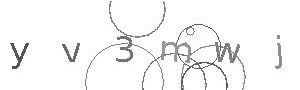

In [ ]:
Image.fromarray(imagem)

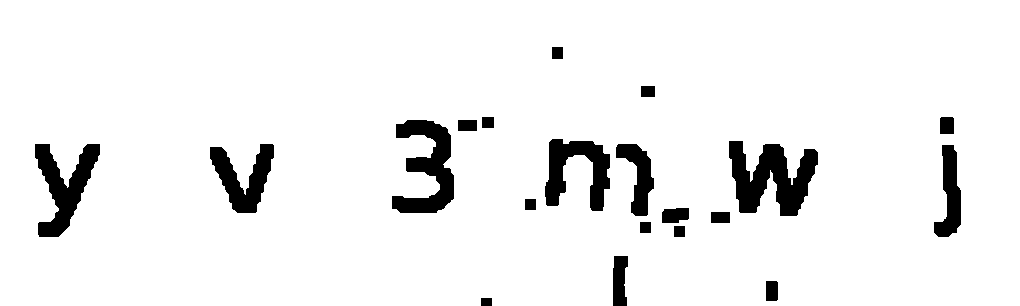

In [ ]:
Image.fromarray(imagem_tratada)

In [ ]:
# importar o modelo que a gente treinou e importar o tradutor
with open("rotulos_modelo_captcha_decode.dat", "rb") as arquivo_tradutor:
    lb = pickle.load(arquivo_tradutor)

modelo = load_model("modelo_treinado_captcha.hdf5")

# CÓDIGO DA COLETA
# texto = '''Tribunal Regional do Trabalho da 2ª Região

# 1001043-17.2016.5.02.0000
# 1001660-40.2017.5.02.0000
# 1002184-71.2016.5.02.0000
# 1004194-54.2017.5.02.0000
# 1028409-84.2023.5.02.0000
# 1ª Vara do Trabalho de Barueri

# 0000792-29.2015.5.02.0201
# 0001141-03.2013.5.02.0201
# 0002177-80.2013.5.02.0201
# 0002444-81.2015.5.02.0201
# 1000141-96.2023.5.02.0201
# 1000305-27.2024.5.02.0201
# 1000339-36.2023.5.02.0201
# 1000372-26.2023.5.02.0201
# 1000378-33.2023.5.02.0201
# 1000461-49.2023.5.02.0201
# 1000501-31.2023.5.02.0201
# 1000585-32.2023.5.02.0201
# 1000589-69.2023.5.02.0201
# 1000762-59.2024.5.02.0201
# 1000776-43.2024.5.02.0201
# 1000784-83.2022.5.02.0720
# 1000866-90.2020.5.02.0201
# 1000972-57.2017.5.02.0201
# 1000986-65.2022.5.02.0201
# 1000996-12.2022.5.02.0201
# 1000998-79.2022.5.02.0201
# 1001062-55.2023.5.02.0201
# 1001107-98.2019.5.02.0201
# 1001110-53.2019.5.02.0201
# 1001145-71.2023.5.02.0201
# 1001313-83.2017.5.02.0201
# 1001321-60.2017.5.02.0201
# 1001461-21.2022.5.02.0201
# 1001532-96.2017.5.02.0201
# 1001799-88.2022.5.02.0073
# 1001861-35.2022.5.02.0201
# 1001863-05.2022.5.02.0201
# 1002366-89.2023.5.02.0201
# 1ª Vara do Trabalho de Carapicuíba

# 0000764-10.2011.5.02.0231
# 1000218-15.2023.5.02.0231
# 1000240-73.2023.5.02.0231
# 1000626-06.2023.5.02.0231
# 1000627-88.2023.5.02.0231
# 1000911-67.2021.5.02.0231
# 1000966-81.2022.5.02.0231
# 1001080-83.2023.5.02.0231
# 1ª Vara do Trabalho de Cotia

# 1000040-36.2023.5.02.0241
# 1000086-07.2021.5.02.0011
# 1000156-08.2024.5.02.0241
# 1000205-49.2024.5.02.0241
# 1000280-64.2019.5.02.0241
# 1000284-96.2022.5.02.0241
# 1000311-45.2023.5.02.0241
# 1000345-59.2019.5.02.0241
# 1000351-66.2019.5.02.0241
# 1000368-29.2024.5.02.0241
# 1000373-51.2024.5.02.0241
# 1000381-04.2019.5.02.0241
# 1000393-76.2023.5.02.0241
# 1000458-08.2022.5.02.0241
# 1000618-96.2023.5.02.0241
# 1000647-49.2023.5.02.0241
# 1000649-19.2023.5.02.0241
# 1000659-44.2015.5.02.0241
# 1000751-51.2017.5.02.0241
# 1000879-95.2022.5.02.0241
# 1000910-28.2016.5.02.0241
# 1000994-58.2018.5.02.0241
# 1001016-43.2023.5.02.0241
# 1001143-78.2023.5.02.0241
# 1001153-25.2023.5.02.0241
# 1001233-86.2023.5.02.0241
# 1001246-85.2023.5.02.0241
# 1001412-88.2021.5.02.0241
# 1001515-61.2022.5.02.0241
# 1001642-70.2017.5.02.0371
# 1001727-48.2023.5.02.0241
# 1001783-52.2022.5.02.0068
# 1001846-87.2015.5.02.0241
# 1001879-33.2022.5.02.0241
# 1001957-32.2019.5.02.0241
# 1002043-61.2023.5.02.0241
# 1002170-09.2017.5.02.0241
# 1002264-54.2017.5.02.0241
# 1002361-44.2023.5.02.0241
# 1002601-43.2017.5.02.0241
# 1002762-92.2013.5.02.0241
# 1002901-05.2017.5.02.0241
# 1ª Vara do Trabalho de Diadema

# 0001279-18.2012.5.02.0261
# 0001917-51.2012.5.02.0261
# 1000340-98.2024.5.02.0261
# 1000920-65.2023.5.02.0261
# 1001521-52.2015.5.02.0261
# 1ª Vara do Trabalho de Franco da Rocha

# 0000190-64.2012.5.02.0291
# 1000063-89.2024.5.02.0291
# 1000064-74.2024.5.02.0291
# 1000131-36.2024.5.02.0292
# 1000134-91.2024.5.02.0291
# 1000136-61.2024.5.02.0291
# 1000147-95.2021.5.02.0291
# 1000187-43.2022.5.02.0291
# 1000188-28.2022.5.02.0291
# 1000216-25.2024.5.02.0291
# 1000251-82.2024.5.02.0291
# 1000253-52.2024.5.02.0291
# 1000395-61.2021.5.02.0291
# 1000419-70.2013.5.02.0291
# 1000503-22.2023.5.02.0291
# 1000508-44.2023.5.02.0291
# 1000604-98.2019.5.02.0291
# 1000637-49.2023.5.02.0291
# 1000651-04.2021.5.02.0291
# 1000696-42.2020.5.02.0291
# 1000762-17.2023.5.02.0291
# 1000838-38.2023.5.02.0292
# 1000864-39.2023.5.02.0291
# 1000904-21.2023.5.02.0291
# 1000905-06.2023.5.02.0291
# 1000929-68.2022.5.02.0291
# 1000982-49.2022.5.02.0291
# 1001080-34.2022.5.02.0291
# 1001100-88.2023.5.02.0291
# 1001110-35.2023.5.02.0291
# 1001111-20.2023.5.02.0291
# 1001112-39.2022.5.02.0291
# 1001252-73.2022.5.02.0291
# 1001396-13.2023.5.02.0291
# 1001421-26.2023.5.02.0291
# 1001483-03.2022.5.02.0291
# 1001668-04.2023.5.02.0292
# 1001672-44.2023.5.02.0291
# 1001685-43.2023.5.02.0291
# 1ª Vara do Trabalho de Guarujá

# 1000014-28.2018.5.02.0301
# 1000031-54.2024.5.02.0301
# 1000032-49.2018.5.02.0301
# 1000142-38.2024.5.02.0301
# 1000215-10.2024.5.02.0301
# 1000400-55.2018.5.02.0302
# 1000450-74.2024.5.02.0301
# 1000467-10.2024.5.02.0302
# 1000509-98.2020.5.02.0302
# 1000776-68.2023.5.02.0301
# 1000841-97.2022.5.02.0301
# 1000849-45.2020.5.02.0301
# 1000871-35.2022.5.02.0301
# 1000873-44.2018.5.02.0301
# 1000991-78.2022.5.02.0301
# 1000992-63.2022.5.02.0301
# 1001137-79.2023.5.02.0303
# 1001166-82.2016.5.02.0301
# 1001201-95.2023.5.02.0301
# 1001213-12.2023.5.02.0301
# 1001404-57.2023.5.02.0301
# 1001451-25.2023.5.02.0303
# 1001462-60.2023.5.02.0301
# 1001543-03.2023.5.02.0303
# 1ª Vara do Trabalho de Guarulhos

# 0001330-73.2012.5.02.0311
# 1000278-96.2024.5.02.0313
# 1000757-03.2021.5.02.0311
# 1001173-97.2023.5.02.0311
# 1001359-23.2023.5.02.0311
# 1001665-89.2023.5.02.0311
# 1001757-67.2023.5.02.0311
# 1ª Vara do Trabalho de Itapecerica da Serra

# 1000087-65.2022.5.02.0331
# 1000382-68.2023.5.02.0331
# 1000389-94.2022.5.02.0331
# 1000390-79.2022.5.02.0331
# 1000398-85.2024.5.02.0331
# 1000479-44.2018.5.02.0331
# 1000495-90.2021.5.02.0331
# 1000575-54.2021.5.02.0331
# 1000610-14.2021.5.02.0331
# 1000620-24.2022.5.02.0331
# 1000657-51.2022.5.02.0331
# 1000736-93.2023.5.02.0331
# 1000787-80.2018.5.02.0331
# 1000788-89.2023.5.02.0331
# 1000857-24.2023.5.02.0331
# 1000970-75.2023.5.02.0331
# 1001323-28.2017.5.02.0331
# 1001400-68.2016.5.02.0332
# 1ª Vara do Trabalho de Itaquaquecetuba

# 1000050-23.2013.5.02.0341
# 1000103-04.2013.5.02.0341
# 1000243-52.2024.5.02.0341
# 1000335-30.2024.5.02.0341
# 1000473-46.2014.5.02.0341
# 1000480-72.2013.5.02.0341
# 1000529-16.2013.5.02.0341
# 1000995-58.2023.5.02.0341
# 1000996-43.2023.5.02.0341
# 1001079-11.2013.5.02.0341
# 1001156-05.2022.5.02.0341
# 1001301-61.2022.5.02.0341
# 1001381-25.2022.5.02.0341
# 1001421-16.2019.5.02.0372
# 1001468-44.2023.5.02.0341
# 1001640-83.2023.5.02.0341
# 1001713-65.2017.5.02.0341
# 1ª Vara do Trabalho de Mauá

# 1001480-95.2023.5.02.0361
# 1ª Vara do Trabalho de Mogi das Cruzes

# 0001267-91.2014.5.02.0371
# 1000271-66.2020.5.02.0371
# 1000342-29.2024.5.02.0371
# 1000369-12.2024.5.02.0371
# 1000488-70.2024.5.02.0371
# 1000541-51.2024.5.02.0371
# 1000744-47.2023.5.02.0371
# 1000985-55.2022.5.02.0371
# 1001042-44.2020.5.02.0371
# 1001115-11.2023.5.02.0371
# 1001252-27.2022.5.02.0371
# 1001338-61.2023.5.02.0371
# 1001639-47.2019.5.02.0371
# 1ª Vara do Trabalho de Osasco

# 0001966-23.2012.5.02.0381
# 1000171-42.2024.5.02.0381
# 1000308-24.2024.5.02.0381
# 1000424-64.2023.5.02.0381
# 1000488-40.2024.5.02.0381
# 1000634-23.2020.5.02.0381
# 1000725-45.2022.5.02.0381
# 1000870-67.2023.5.02.0381
# 1000908-21.2019.5.02.0381
# 1001084-97.2019.5.02.0381
# 1001169-26.2021.5.02.0054
# 1001242-16.2023.5.02.0381
# 1001259-52.2023.5.02.0381
# 1001266-83.2019.5.02.0381
# 1001390-27.2023.5.02.0381
# 1001508-03.2023.5.02.0381
# 1001526-39.2014.5.02.0381
# 1001551-37.2023.5.02.0381
# 1001607-70.2023.5.02.0381
# 1001994-85.2023.5.02.0381
# 1002021-68.2023.5.02.0381
# 1ª Vara do Trabalho de Praia Grande

# 0000545-30.2015.5.02.0401
# 0001032-97.2015.5.02.0401
# 0001456-13.2013.5.02.0401
# 0002417-51.2013.5.02.0401
# 1000113-13.2023.5.02.0401
# 1000129-30.2024.5.02.0401
# 1000130-15.2024.5.02.0401
# 1000269-64.2024.5.02.0401
# 1000476-63.2024.5.02.0401
# 1000614-45.2015.5.02.0401
# 1000662-83.2024.5.02.0402
# 1000706-08.2024.5.02.0401
# 1000813-86.2023.5.02.0401
# 1000885-49.2018.5.02.0401
# 1001033-31.2016.5.02.0401
# 1001064-41.2022.5.02.0401
# 1001115-20.2020.5.02.0402
# 1001223-18.2021.5.02.0401
# 1001275-77.2022.5.02.0401
# 1001301-75.2022.5.02.0401
# 1001307-82.2022.5.02.0401
# 1001565-58.2023.5.02.0401
# 1001865-20.2023.5.02.0401
# 1ª Vara do Trabalho de Santana de Parnaíba

# 1000226-64.2024.5.02.0422
# 1000276-69.2019.5.02.0421
# 1000317-60.2024.5.02.0421
# 1000343-58.2024.5.02.0421
# 1000573-03.2024.5.02.0421
# 1000610-06.2019.5.02.0421
# 1001522-61.2023.5.02.0421
# 1001560-73.2023.5.02.0421
# 1001833-62.2017.5.02.0421
# 1ª Vara do Trabalho de Santo André

# 0078900-81.2003.5.02.0431
# 0246000-95.2002.5.02.0431
# 1000162-27.2024.5.02.0431
# 1000247-13.2024.5.02.0431
# 1000382-70.2024.5.02.0610
# 1000624-18.2023.5.02.0431
# 1000841-32.2021.5.02.0431
# 1001267-10.2022.5.02.0431
# 1ª Vara do Trabalho de Santos

# 0000961-09.2014.5.02.0441
# 0001355-21.2011.5.02.0441
# 0001891-61.2013.5.02.0441
# 0002027-63.2010.5.02.0441
# 0079700-06.2008.5.02.0441
# 1000069-49.2015.5.02.0441
# 1000072-86.2024.5.02.0441
# 1000089-59.2023.5.02.0441
# 1000122-15.2024.5.02.0441
# 1000142-06.2024.5.02.0441
# 1000149-95.2024.5.02.0441
# 1000167-19.2024.5.02.0441
# 1000176-49.2022.5.02.0441
# 1000203-95.2023.5.02.0441
# 1000315-35.2021.5.02.0441
# 1000514-23.2022.5.02.0441
# 1000525-57.2019.5.02.0441
# 1000597-05.2023.5.02.0441
# 1000740-67.2018.5.02.0441
# 1000774-03.2022.5.02.0441
# 1000850-32.2019.5.02.0441
# 1000858-72.2020.5.02.0441
# 1000913-18.2023.5.02.0441
# 1000918-74.2022.5.02.0441
# 1000972-50.2016.5.02.0441
# 1000996-34.2023.5.02.0441
# 1000997-19.2023.5.02.0441
# 1000998-04.2023.5.02.0441
# 1001193-86.2023.5.02.0441
# 1001219-84.2023.5.02.0441
# 1001303-85.2023.5.02.0441
# 1001310-77.2023.5.02.0441
# 1ª Vara do Trabalho de Suzano

# 0000617-77.2011.5.02.0491
# 1000023-26.2023.5.02.0491
# 1000044-65.2024.5.02.0491
# 1000045-50.2024.5.02.0491
# 1000076-70.2024.5.02.0491
# 1000077-55.2024.5.02.0491
# 1000083-96.2023.5.02.0491
# 1000090-88.2023.5.02.0491
# 1000139-32.2023.5.02.0491
# 1000144-20.2024.5.02.0491
# 1000178-34.2020.5.02.0491
# 1000200-53.2024.5.02.0491
# 1000217-26.2023.5.02.0491
# 1000217-94.2021.5.02.0491
# 1000218-74.2024.5.02.0491
# 1000241-20.2024.5.02.0491
# 1000245-57.2024.5.02.0491
# 1000251-64.2024.5.02.0491
# 1000281-36.2023.5.02.0491
# 1000302-12.2023.5.02.0491
# 1000432-65.2024.5.02.0491
# 1000469-92.2024.5.02.0491
# 1000511-44.2024.5.02.0491
# 1000630-73.2022.5.02.0491
# 1000669-85.2013.5.02.0491
# 1000672-88.2023.5.02.0491
# 1000674-58.2023.5.02.0491
# 1000681-25.2018.5.02.0071
# 1000688-42.2023.5.02.0491
# 1000710-03.2023.5.02.0491
# 1000761-14.2023.5.02.0491
# 1000996-78.2023.5.02.0491
# 1001034-27.2022.5.02.0491
# 1001088-61.2020.5.02.0491
# 1001106-14.2022.5.02.0491
# 1001135-64.2022.5.02.0491
# 1001152-47.2015.5.02.0491
# 1001163-32.2022.5.02.0491
# 1001165-65.2023.5.02.0491
# 1001170-24.2022.5.02.0491
# 1001271-27.2023.5.02.0491
# 1001296-74.2022.5.02.0491
# 1001308-54.2023.5.02.0491
# 1001369-46.2022.5.02.0491
# 1001379-56.2023.5.02.0491
# 1001382-11.2023.5.02.0491
# 1001385-63.2023.5.02.0491
# 1001398-59.2023.5.02.0492
# 1001401-17.2023.5.02.0491
# 1001406-39.2023.5.02.0491
# 1001408-09.2023.5.02.0491
# 1001464-42.2023.5.02.0491
# 1001470-30.2015.5.02.0491
# 1001529-37.2023.5.02.0491
# 1001542-36.2023.5.02.0491
# 1001607-31.2023.5.02.0491
# 1001609-98.2023.5.02.0491
# 1001611-68.2023.5.02.0491
# 1001615-08.2023.5.02.0491
# 1001632-44.2023.5.02.0491
# 1001722-33.2015.5.02.0491
# 1ª Vara do Trabalho de São Bernardo do Campo

# 0000035-02.2013.5.02.0461
# 1000351-12.2024.5.02.0461
# 1000556-80.2020.5.02.0461
# 1000557-31.2021.5.02.0461
# 1000746-38.2023.5.02.0461
# 1000875-43.2023.5.02.0461
# 1000880-65.2023.5.02.0461
# 1001328-82.2016.5.02.0461
# 1001376-94.2023.5.02.0461
# 1001413-68.2016.5.02.0461
# 1001553-52.2023.5.02.0463
# 1001560-50.2023.5.02.0461
# 1001659-20.2023.5.02.0461
# 1001660-49.2016.5.02.0461
# 1001758-87.2023.5.02.0461
# 1002276-92.2014.5.02.0461
# 1002445-79.2014.5.02.0461
# 1ª Vara do Trabalho de São Caetano do Sul

# 0000822-69.2011.5.02.0471
# 1000048-02.2023.5.02.0471
# 1000086-14.2023.5.02.0471
# 1000908-03.2023.5.02.0471
# 1000909-85.2023.5.02.0471
# 1001221-95.2022.5.02.0471
# 1ª Vara do Trabalho de São Paulo

# 1000328-88.2024.5.02.0001
# 1000827-09.2023.5.02.0001
# 1000835-83.2023.5.02.0001
# 1000845-64.2022.5.02.0001
# 1000960-90.2019.5.02.0001
# 1000969-13.2023.5.02.0001
# 1001073-05.2023.5.02.0001
# 1001302-56.2017.5.02.0071
# 1001409-09.2023.5.02.0001
# 1001695-21.2022.5.02.0001
# 1001720-97.2023.5.02.0001
# 1001747-80.2023.5.02.0001
# 1001966-93.2023.5.02.0001
# 1ª Vara do Trabalho de São Paulo - Zona Leste

# 1000001-89.2024.5.02.0601
# 1000005-29.2024.5.02.0601
# 1000015-73.2024.5.02.0601
# 1000243-48.2024.5.02.0601
# 1000539-70.2024.5.02.0601
# 1000557-91.2024.5.02.0601
# 1000559-61.2024.5.02.0601
# 1000607-20.2024.5.02.0601
# 1000636-41.2022.5.02.0601
# 1000703-35.2024.5.02.0601
# 1000718-04.2024.5.02.0601
# 1000845-10.2022.5.02.0601
# 1001017-54.2019.5.02.0601
# 1001303-90.2023.5.02.0601
# 1001656-67.2022.5.02.0601
# 1001800-03.2020.5.02.0604
# 1001889-30.2023.5.02.0601
# 1001958-62.2023.5.02.0601
# 1002121-76.2022.5.02.0601
# 1002144-85.2023.5.02.0601
# 1002284-22.2023.5.02.0601
# 1002363-98.2023.5.02.0601
# 1002386-44.2023.5.02.0601
# 1ª Vara do Trabalho de São Paulo - Zona Sul

# 1000232-49.2020.5.02.0701
# 1000260-90.2015.5.02.0701
# 1000305-79.2024.5.02.0701
# 1000397-96.2020.5.02.0701
# 1000404-49.2024.5.02.0701
# 1000413-16.2021.5.02.0701
# 1000431-32.2024.5.02.0701
# 1000487-02.2023.5.02.0701
# 1000541-02.2022.5.02.0701
# 1000584-70.2021.5.02.0701
# 1000592-81.2020.5.02.0701
# 1000595-41.2017.5.02.0701
# 1000732-47.2022.5.02.0701
# 1001060-40.2023.5.02.0701
# 1001188-02.2019.5.02.0701
# 1001263-02.2023.5.02.0701
# 1001294-03.2015.5.02.0701
# 1001297-11.2022.5.02.0701
# 1001355-14.2022.5.02.0701
# 1001412-66.2021.5.02.0701
# 1001508-52.2019.5.02.0701
# 1001645-29.2022.5.02.0701
# 1001808-72.2023.5.02.0701
# 1001928-06.2023.5.02.0026
# 1ª Vara do Trabalho de São Vicente

# 1000049-30.2018.5.02.0481
# 1000115-34.2023.5.02.0481
# 1000159-53.2023.5.02.0481
# 1000203-72.2023.5.02.0481
# 1000266-34.2022.5.02.0481
# 1000302-76.2022.5.02.0481
# 1000504-82.2024.5.02.0481
# 1000552-75.2023.5.02.0481
# 1000714-70.2023.5.02.0481
# 1000796-82.2015.5.02.0481
# 1000982-66.2022.5.02.0447
# 1001438-84.2017.5.02.0481
# 1ª Vara do Trabalho de Taboão da Serra

# 1001126-09.2021.5.02.0501
# 1001143-45.2021.5.02.0501
# 1001206-36.2022.5.02.0501
# 1001420-90.2023.5.02.0501
# 1001585-40.2023.5.02.0501
# 2ª Vara do Trabalho de Barueri

# 0000231-02.2015.5.02.0202
# 0001282-19.2013.5.02.0202
# 1000401-15.2019.5.02.0202
# 1000452-50.2024.5.02.0202
# 1000571-11.2024.5.02.0202
# 1000619-67.2024.5.02.0202
# 1000629-48.2023.5.02.0202
# 1000642-13.2024.5.02.0202
# 1000736-58.2024.5.02.0202
# 1000854-39.2021.5.02.0202
# 1001038-34.2017.5.02.0202
# 1001088-50.2023.5.02.0202
# 1001097-22.2017.5.02.0202
# 1001872-61.2022.5.02.0202
# 1001873-46.2022.5.02.0202
# 1002033-37.2023.5.02.0202
# 1002137-29.2023.5.02.0202
# 1002296-69.2023.5.02.0202
# 2ª Vara do Trabalho de Carapicuíba

# 1000006-54.2024.5.02.0232
# 1000021-23.2024.5.02.0232
# 1000037-74.2024.5.02.0232
# 1000041-48.2023.5.02.0232
# 1000192-14.2023.5.02.0232
# 1000197-36.2023.5.02.0232
# 1000202-24.2024.5.02.0232
# 1000211-83.2024.5.02.0232
# 1000213-53.2024.5.02.0232
# 1000214-38.2024.5.02.0232
# 1000225-04.2023.5.02.0232
# 1000226-52.2024.5.02.0232
# 1000230-26.2023.5.02.0232
# 1000230-92.2024.5.02.0231
# 1000232-93.2023.5.02.0232
# 1000284-26.2022.5.02.0232
# 1000352-05.2024.5.02.0232
# 1000353-87.2024.5.02.0232
# 1000582-52.2021.5.02.0232
# 1000636-47.2023.5.02.0232
# 1000772-44.2023.5.02.0232
# 1001022-77.2023.5.02.0232
# 1001176-08.2017.5.02.0232
# 1001284-37.2017.5.02.0232
# 1001317-17.2023.5.02.0232
# 1001354-44.2023.5.02.0232
# 1001402-03.2023.5.02.0232
# 2ª Vara do Trabalho de Cotia

# 1000179-48.2024.5.02.0242
# 1000220-49.2023.5.02.0242
# 1000258-27.2024.5.02.0242
# 1000375-86.2022.5.02.0242
# 1000391-40.2022.5.02.0242
# 1000406-72.2023.5.02.0242
# 1000431-85.2023.5.02.0242
# 1000453-12.2024.5.02.0242
# 1000472-62.2017.5.02.0242
# 1000476-55.2024.5.02.0242
# 1000479-13.2024.5.02.0241
# 1000530-21.2024.5.02.0242
# 1000536-38.2018.5.02.0242
# 1000699-08.2024.5.02.0242
# 1000754-56.2024.5.02.0242
# 1000773-62.2024.5.02.0242
# 1000820-41.2021.5.02.0242
# 1000954-97.2023.5.02.0242
# 1001065-52.2021.5.02.0242
# 1001196-56.2023.5.02.0242
# 1001320-20.2015.5.02.0242
# 1001350-74.2023.5.02.0242
# 1001383-64.2023.5.02.0242
# 1001571-91.2022.5.02.0242
# 1001652-74.2021.5.02.0242
# 1001687-63.2023.5.02.0242
# 1001768-12.2023.5.02.0242
# 1001769-94.2023.5.02.0242
# 1001883-67.2022.5.02.0242
# 1001951-90.2017.5.02.0242
# 1001958-09.2022.5.02.0242
# 2ª Vara do Trabalho de Cubatão

# 1000075-26.2024.5.02.0252
# 1000109-06.2021.5.02.0252
# 1000125-23.2022.5.02.0252
# 1000153-53.2020.5.02.0254
# 1000161-85.2024.5.02.0255
# 1000266-62.2024.5.02.0255
# 1000291-84.2024.5.02.0252
# 1000293-82.2023.5.02.0254
# 1000365-12.2022.5.02.0252
# 1000401-54.2022.5.02.0252
# 1000575-63.2022.5.02.0252
# 1000585-15.2019.5.02.0252
# 1000610-23.2022.5.02.0252
# 1000675-72.2023.5.02.0255
# 1000720-79.2023.5.02.0254
# 1000739-28.2022.5.02.0252
# 1000744-50.2022.5.02.0252
# 1000802-19.2023.5.02.0252
# 1000827-32.2023.5.02.0252
# 1000828-17.2023.5.02.0252
# 1000842-98.2023.5.02.0252
# 1000901-77.2023.5.02.0255
# 1000904-35.2023.5.02.0254
# 1000929-45.2023.5.02.0255
# 1000947-69.2023.5.02.0254
# 1000950-21.2023.5.02.0255
# 1000984-05.2023.5.02.0252
# 1000997-04.2023.5.02.0252
# 2ª Vara do Trabalho de Diadema

# 0001423-86.2012.5.02.0262
# 0001852-19.2013.5.02.0262
# 1000014-38.2024.5.02.0262
# 1000059-42.2024.5.02.0262
# 1000106-16.2024.5.02.0262
# 1000183-25.2024.5.02.0262
# 1000282-92.2024.5.02.0262
# 1000283-77.2024.5.02.0262
# 1000334-93.2021.5.02.0262
# 1000370-33.2024.5.02.0262
# 1000444-87.2024.5.02.0262
# 1000693-72.2023.5.02.0262
# 2ª Vara do Trabalho de Franco da Rocha

# 1000036-09.2024.5.02.0291
# 1000170-67.2023.5.02.0292
# 1000223-14.2024.5.02.0292
# 1000224-96.2024.5.02.0292
# 1000245-72.2024.5.02.0292
# 1000275-10.2024.5.02.0292
# 1000404-15.2024.5.02.0292
# 1000411-07.2024.5.02.0292
# 1000525-77.2023.5.02.0292
# 1000530-02.2023.5.02.0292
# 1000553-29.2015.5.02.0291
# 1000791-64.2023.5.02.0292
# 1000804-63.2023.5.02.0292
# 1000835-54.2021.5.02.0292
# 1000888-35.2021.5.02.0292
# 1000892-46.2019.5.02.0291
# 1000898-79.2021.5.02.0292
# 1001005-89.2022.5.02.0292
# 1001016-84.2023.5.02.0292
# 1001114-69.2023.5.02.0292
# 1001117-24.2023.5.02.0292
# 1001118-09.2023.5.02.0292
# 1001119-91.2023.5.02.0292
# 1001129-14.2018.5.02.0292
# 1001166-65.2023.5.02.0292
# 1001352-35.2016.5.02.0292
# 1001380-66.2017.5.02.0292
# 1001440-29.2023.5.02.0292
# 1001444-66.2023.5.02.0292
# 1001446-36.2023.5.02.0292
# 1001510-46.2023.5.02.0292
# 1001644-73.2023.5.02.0292
# 1001690-62.2023.5.02.0292
# 1001696-69.2023.5.02.0292
# 2ª Vara do Trabalho de Guarujá

# 0174900-21.1998.5.02.0302
# 0204200-28.1998.5.02.0302
# 1000026-29.2024.5.02.0302
# 1000040-10.2024.5.02.0303
# 1000151-94.2024.5.02.0302
# 1000153-67.2024.5.02.0301
# 1000256-08.2023.5.02.0302
# 1000354-90.2023.5.02.0302
# 1000415-45.2023.5.02.0303
# 1000419-48.2024.5.02.0303
# 1000424-70.2024.5.02.0303
# 1000438-28.2022.5.02.0302
# 1000465-40.2024.5.02.0302
# 1000561-60.2021.5.02.0302
# 1000633-76.2023.5.02.0302
# 1000771-40.2023.5.02.0303
# 1000870-50.2022.5.02.0301
# 1000906-89.2022.5.02.0302
# 1001033-61.2021.5.02.0302
# 1001193-18.2023.5.02.0302
# 1001204-81.2022.5.02.0302
# 1001265-36.2022.5.02.0303
# 1001321-35.2023.5.02.0303
# 1001356-95.2023.5.02.0302
# 1001496-29.2023.5.02.0303
# 1001497-14.2023.5.02.0303
# 1001501-51.2023.5.02.0303
# 2ª Vara do Trabalho de Guarulhos

# 0002036-87.2011.5.02.0312
# 1000007-90.2024.5.02.0312
# 1000115-22.2024.5.02.0312
# 1000236-50.2024.5.02.0312
# 1000315-34.2021.5.02.0312
# 1000351-71.2024.5.02.0312
# 1000493-12.2023.5.02.0312
# 1000509-29.2024.5.02.0312
# 1001067-06.2021.5.02.0312
# 1001161-80.2023.5.02.0312
# 1001170-42.2023.5.02.0312
# 1001227-31.2021.5.02.0312
# 1001657-94.2023.5.02.0317
# 2ª Vara do Trabalho de Itapecerica da Serra

# 1000093-69.2022.5.02.0332
# 1000107-19.2023.5.02.0332
# 1000298-30.2024.5.02.0332
# 1000346-96.2018.5.02.0332
# 1000404-89.2024.5.02.0332
# 1000417-59.2022.5.02.0332
# 1000515-78.2021.5.02.0332
# 1000553-61.2019.5.02.0332
# 1000571-43.2023.5.02.0332
# 1000583-28.2021.5.02.0332
# 1000621-40.2021.5.02.0332
# 1000668-14.2021.5.02.0332
# 1000814-21.2022.5.02.0332
# 1000845-80.2018.5.02.0332
# 1000886-42.2021.5.02.0332
# 1000947-29.2023.5.02.0332
# 1001007-02.2023.5.02.0332
# 1001101-47.2023.5.02.0332
# 2ª Vara do Trabalho de Itaquaquecetuba

# 1000023-22.2022.5.02.0342
# 1000075-86.2020.5.02.0342
# 1000327-21.2022.5.02.0342
# 1000367-32.2024.5.02.0342
# 1000381-36.2012.5.02.0342
# 1000406-68.2020.5.02.0342
# 1000486-27.2023.5.02.0342
# 1000504-14.2024.5.02.0342
# 1000548-38.2021.5.02.0342
# 1000750-44.2023.5.02.0342
# 1000821-46.2023.5.02.0342
# 1000836-15.2023.5.02.0342
# 1000926-23.2023.5.02.0342
# 1001275-26.2023.5.02.0342
# 1001381-22.2022.5.02.0342
# 1001537-73.2023.5.02.0342
# 1001619-07.2023.5.02.0342
# 1001636-43.2023.5.02.0342
# 1001636-92.2013.5.02.0342
# 2ª Vara do Trabalho de Mauá

# 1000208-63.2023.5.02.0362
# 2ª Vara do Trabalho de Mogi das Cruzes

# 0000022-81.2010.5.02.0372
# 0002009-50.2013.5.02.0372
# 0231100-46.2009.5.02.0372
# 1000041-79.2024.5.02.0372
# 1000080-76.2024.5.02.0372
# 1000235-84.2021.5.02.0372
# 1000301-93.2023.5.02.0372
# 1000435-83.2024.5.02.0373
# 1000548-40.2024.5.02.0372
# 1001581-02.2023.5.02.0372
# 1001712-74.2023.5.02.0372
# 1001755-11.2023.5.02.0372
# 1001758-63.2023.5.02.0372
# 2ª Vara do Trabalho de Osasco

# 0002084-93.2012.5.02.0382
# 0002114-31.2012.5.02.0382
# 1000153-57.2020.5.02.0382
# 1000335-43.2020.5.02.0382
# 1000350-12.2020.5.02.0382
# 1000382-75.2024.5.02.0382
# 1000523-02.2021.5.02.0382
# 1000540-04.2022.5.02.0382
# 1000554-51.2023.5.02.0382
# 1000793-89.2022.5.02.0382
# 1000816-98.2023.5.02.0382
# 1000826-16.2021.5.02.0382
# 1000877-27.2021.5.02.0382
# 1000885-33.2023.5.02.0382
# 1001165-72.2021.5.02.0382
# 1001747-04.2023.5.02.0382
# 1001756-63.2023.5.02.0382
# 2ª Vara do Trabalho de Praia Grande

# 0000006-95.2014.5.02.0402
# 0000207-24.2013.5.02.0402
# 0000261-92.2010.5.02.0402
# 0000453-49.2015.5.02.0402
# 0000538-35.2015.5.02.0402
# 0000545-27.2015.5.02.0402
# 0001005-87.2010.5.02.0402
# 0001281-16.2013.5.02.0402
# 0001333-80.2011.5.02.0402
# 0001581-46.2011.5.02.0402
# 0001796-22.2011.5.02.0402
# 0001810-69.2012.5.02.0402
# 0002135-10.2013.5.02.0402
# 0002351-68.2013.5.02.0402
# 0002375-96.2013.5.02.0402
# 0002455-94.2012.5.02.0402
# 0002474-32.2014.5.02.0402
# 0002565-59.2013.5.02.0402
# 1000005-83.2020.5.02.0402
# 1000060-05.2018.5.02.0402
# 1000067-65.2016.5.02.0402
# 1000096-42.2021.5.02.0402
# 1000123-30.2018.5.02.0402
# 1000218-53.2024.5.02.0401
# 1000227-56.2017.5.02.0402
# 1000232-15.2016.5.02.0402
# 1000233-24.2021.5.02.0402
# 1000281-12.2023.5.02.0402
# 1000356-17.2024.5.02.0402
# 1000458-39.2024.5.02.0402
# 1000458-54.2015.5.02.0402
# 1000466-31.2015.5.02.0402
# 1000475-56.2016.5.02.0402
# 1000494-86.2021.5.02.0402
# 1000515-91.2023.5.02.0402
# 1000517-32.2021.5.02.0402
# 1000560-71.2018.5.02.0402
# 1000571-95.2021.5.02.0402
# 1000581-47.2018.5.02.0402
# 1000587-44.2024.5.02.0402
# 1000639-21.2016.5.02.0402
# 1000643-48.2022.5.02.0402
# 1000700-71.2016.5.02.0048
# 1000712-17.2021.5.02.0402
# 1000713-75.2016.5.02.0402
# 1000726-11.2015.5.02.0402
# 1000940-26.2020.5.02.0402
# 1001015-07.2016.5.02.0402
# 1001040-10.2022.5.02.0402
# 1001057-46.2022.5.02.0402
# 1001081-40.2023.5.02.0402
# 1001103-40.2019.5.02.0402
# 1001135-74.2021.5.02.0402
# 1001136-59.2021.5.02.0402
# 1001190-88.2022.5.02.0402
# 1001222-64.2020.5.02.0402
# 1001418-05.2018.5.02.0402
# 1001461-39.2018.5.02.0402
# 1001498-32.2019.5.02.0402
# 1001503-15.2023.5.02.0402
# 1001561-18.2023.5.02.0402
# 1001867-87.2023.5.02.0401
# 1001950-47.2016.5.02.0402
# 2ª Vara do Trabalho de Santana de Parnaíba

# 1000227-25.2019.5.02.0422
# 1000265-81.2012.5.02.0422
# 1000274-57.2023.5.02.0422
# 1000286-57.2012.5.02.0422
# 1000302-25.2023.5.02.0422
# 1000305-46.2024.5.02.0421
# 1000457-96.2021.5.02.0422
# 1000569-60.2024.5.02.0422
# 1001244-62.2020.5.02.0422
# 2ª Vara do Trabalho de Santo André

# 1000055-77.2024.5.02.0432
# 1000192-93.2023.5.02.0432
# 1000197-86.2021.5.02.0432
# 1000501-17.2023.5.02.0432
# 1001236-84.2022.5.02.0432
# 1001355-45.2022.5.02.0432
# 1001553-48.2023.5.02.0432
# 1002041-03.2023.5.02.0432
# 2ª Vara do Trabalho de Santos

# 0002900-41.2002.5.02.0442
# 0219600-64.2009.5.02.0442
# 1000078-27.2023.5.02.0442
# 1000078-90.2024.5.02.0442
# 1000129-04.2024.5.02.0442
# 1000139-48.2024.5.02.0442
# 1000145-55.2024.5.02.0442
# 1000150-74.2024.5.02.0443
# 1000283-22.2024.5.02.0442
# 1000374-74.2022.5.02.0445
# 1000401-71.2019.5.02.0442
# 1000401-86.2024.5.02.0445
# 1000410-48.2024.5.02.0445
# 1000643-91.2023.5.02.0441
# 1000685-40.2023.5.02.0442
# 1000783-25.2023.5.02.0442
# 1000830-96.2023.5.02.0442
# 1000831-81.2023.5.02.0442
# 1000834-36.2023.5.02.0442
# 1000909-75.2023.5.02.0442
# 1000930-61.2017.5.02.0442
# 1001006-75.2023.5.02.0442
# 1001027-51.2023.5.02.0442
# 1001031-88.2023.5.02.0442
# 1001068-18.2023.5.02.0442
# 1001100-23.2023.5.02.0442
# 1001175-62.2023.5.02.0442
# 1001198-08.2023.5.02.0442
# 1001873-15.2016.5.02.0442
# 2ª Vara do Trabalho de Suzano

# 1000001-28.2024.5.02.0492
# 1000042-92.2024.5.02.0492
# 1000043-77.2024.5.02.0492
# 1000051-54.2024.5.02.0492
# 1000059-31.2024.5.02.0492
# 1000081-26.2023.5.02.0492
# 1000148-98.2017.5.02.0492
# 1000165-90.2024.5.02.0492
# 1000220-75.2023.5.02.0492
# 1000234-30.2021.5.02.0492
# 1000252-27.2016.5.02.0492
# 1000301-24.2023.5.02.0492
# 1000325-28.2018.5.02.0492
# 1000356-38.2024.5.02.0492
# 1000362-79.2023.5.02.0492
# 1000368-52.2024.5.02.0492
# 1000389-62.2023.5.02.0492
# 1000426-55.2024.5.02.0492
# 1000436-02.2024.5.02.0492
# 1000451-39.2022.5.02.0492
# 1000523-89.2023.5.02.0492
# 1000656-05.2021.5.02.0492
# 1000666-78.2023.5.02.0492
# 1000668-48.2023.5.02.0492
# 1000672-85.2023.5.02.0492
# 1000673-73.2023.5.02.0491
# 1000675-43.2023.5.02.0491
# 1000681-81.2022.5.02.0492
# 1000728-65.2016.5.02.0492
# 1000785-39.2023.5.02.0492
# 1000893-40.2023.5.02.0372
# 1000972-81.2022.5.02.0492
# 1000991-53.2023.5.02.0492
# 1001007-41.2022.5.02.0492
# 1001009-74.2023.5.02.0492
# 1001011-44.2023.5.02.0492
# 1001165-04.2019.5.02.0492
# 1001183-20.2022.5.02.0492
# 1001184-68.2023.5.02.0492
# 1001210-69.2023.5.02.0491
# 1001310-21.2023.5.02.0492
# 1001312-25.2022.5.02.0492
# 1001376-98.2023.5.02.0492
# 1001394-22.2023.5.02.0492
# 1001395-07.2023.5.02.0492
# 1001396-89.2023.5.02.0492
# 1001402-96.2023.5.02.0492
# 1001487-82.2023.5.02.0492
# 1001532-86.2023.5.02.0492
# 1001544-03.2023.5.02.0492
# 1001554-47.2023.5.02.0492
# 1001603-98.2017.5.02.0492
# 1001605-58.2023.5.02.0492
# 1001624-64.2023.5.02.0492
# 1001633-26.2023.5.02.0492
# 1001720-89.2017.5.02.0492
# 1001764-45.2016.5.02.0492
# 1001900-76.2015.5.02.0492
# 2ª Vara do Trabalho de São Bernardo do Campo

# 1000078-45.2015.5.02.0462
# 1000147-06.2022.5.02.0374
# 1000445-59.2021.5.02.0462
# 1001099-80.2020.5.02.0462
# 1001122-26.2020.5.02.0462
# 1001578-68.2023.5.02.0462
# 1001692-07.2023.5.02.0462
# 1002541-86.2017.5.02.0462
# 2ª Vara do Trabalho de São Caetano do Sul

# 1001162-07.2022.5.02.0472
# 2ª Vara do Trabalho de São Paulo

# 0000077-07.2012.5.02.0002
# 0000146-10.2010.5.02.0002
# 0000664-97.2010.5.02.0002
# 0001797-09.2012.5.02.0002
# 0183500-77.2006.5.02.0002
# 1000015-95.2022.5.02.0002
# 1000096-73.2024.5.02.0002
# 1000147-84.2024.5.02.0002
# 1000173-82.2024.5.02.0002
# 1000248-24.2024.5.02.0002
# 1000357-38.2024.5.02.0002
# 1000760-85.2016.5.02.0002
# 1000960-92.2016.5.02.0002
# 1001113-81.2023.5.02.0002
# 1001135-47.2020.5.02.0002
# 1001177-62.2021.5.02.0002
# 1001224-02.2022.5.02.0002
# 1001247-79.2021.5.02.0002
# 1001594-44.2023.5.02.0002
# 1001691-49.2023.5.02.0065
# 1001860-31.2023.5.02.0002
# 1002146-53.2016.5.02.0002
# 2ª Vara do Trabalho de São Paulo - Zona Leste

# 1000057-22.2024.5.02.0602
# 1000332-05.2023.5.02.0602
# 1000429-68.2024.5.02.0602
# 1000430-58.2021.5.02.0602
# 1000599-40.2024.5.02.0602
# 1000686-93.2024.5.02.0602
# 1000689-82.2023.5.02.0602
# 1000693-85.2024.5.02.0602
# 1000696-40.2024.5.02.0602
# 1000699-63.2022.5.02.0602
# 1001148-84.2023.5.02.0602
# 1001205-05.2023.5.02.0602
# 1001330-70.2023.5.02.0602
# 1001453-73.2020.5.02.0602
# 1001484-88.2023.5.02.0602
# 1001631-51.2022.5.02.0602
# 1001733-39.2023.5.02.0602
# 1002107-55.2023.5.02.0602
# 1002150-89.2023.5.02.0602
# 1002162-06.2023.5.02.0602
# 1002223-61.2023.5.02.0602
# 1002227-98.2023.5.02.0602
# 1002253-96.2023.5.02.0602
# 2ª Vara do Trabalho de São Paulo - Zona Sul

# 1000013-33.2020.5.02.0702
# 1000112-02.2016.5.02.0004
# 1000259-58.2022.5.02.0702
# 1000331-11.2023.5.02.0702
# 1000378-48.2024.5.02.0702
# 1000422-67.2024.5.02.0702
# 1000428-74.2024.5.02.0702
# 1000851-49.2015.5.02.0702
# 1001030-70.2021.5.02.0702
# 1001728-08.2023.5.02.0702
# 2ª Vara do Trabalho de São Vicente

# 0000533-64.2015.5.02.0482
# 1000123-08.2023.5.02.0482
# 1000156-95.2023.5.02.0482
# 1000211-46.2023.5.02.0482
# 1000213-79.2024.5.02.0482
# 1000243-85.2022.5.02.0482
# 1000259-05.2023.5.02.0482
# 1000260-87.2023.5.02.0482
# 1000261-72.2023.5.02.0482
# 1000455-72.2023.5.02.0482
# 1000723-29.2023.5.02.0482
# 1001185-83.2023.5.02.0482
# 1001197-68.2021.5.02.0482
# 2ª Vara do Trabalho de Taboão da Serra

# 1000013-46.2023.5.02.0502
# 1000534-54.2024.5.02.0502
# 3ª Vara do Trabalho de Barueri

# 0000172-79.2013.5.02.0203
# 0001358-69.2015.5.02.0203
# 0002100-65.2013.5.02.0203
# 0002658-71.2012.5.02.0203
# 0003043-82.2013.5.02.0203
# 0003110-81.2012.5.02.0203
# 0003873-82.2012.5.02.0203
# 1000020-28.2024.5.02.0203
# 1000027-54.2023.5.02.0203
# 1000035-94.2024.5.02.0203
# 1000304-36.2024.5.02.0203
# 1000344-52.2023.5.02.0203
# 1000349-46.2024.5.02.0201
# 1000648-17.2024.5.02.0203
# 1001077-18.2023.5.02.0203
# 1001078-03.2023.5.02.0203
# 1001436-02.2022.5.02.0203
# 1001438-35.2023.5.02.0203
# 1002322-74.2017.5.02.0203
# 3ª Vara do Trabalho de Diadema

# 0000349-57.2013.5.02.0263
# 0001905-31.2012.5.02.0263
# 0093200-57.2009.5.02.0263
# 1000034-26.2024.5.02.0263
# 1000210-44.2020.5.02.0263
# 1000286-63.2023.5.02.0263
# 1000724-65.2018.5.02.0263
# 1000913-72.2020.5.02.0263
# 1001259-18.2023.5.02.0263
# 1001442-36.2016.5.02.0262
# 3ª Vara do Trabalho de Guarujá

# 1000003-83.2024.5.02.0302
# 1000004-75.2018.5.02.0303
# 1000151-97.2024.5.02.0301
# 1000291-28.2024.5.02.0303
# 1000371-92.2024.5.02.0302
# 1000409-38.2023.5.02.0303
# 1000423-85.2024.5.02.0303
# 1000455-03.2018.5.02.0303
# 1000593-62.2021.5.02.0303
# 1000595-32.2021.5.02.0303
# 1000653-67.2023.5.02.0302
# 1000764-48.2023.5.02.0303
# 1000810-71.2022.5.02.0303
# 1000908-56.2022.5.02.0303
# 1000944-98.2022.5.02.0303
# 1001000-34.2022.5.02.0303
# 1001002-10.2022.5.02.0301
# 1001034-09.2022.5.02.0303
# 1001213-06.2023.5.02.0303
# 1001220-95.2023.5.02.0303
# 1001436-56.2023.5.02.0303
# 1001452-10.2023.5.02.0303
# 1001453-92.2023.5.02.0303
# 3ª Vara do Trabalho de Guarulhos

# 1000001-80.2024.5.02.0313
# 1000108-27.2024.5.02.0313
# 1000171-28.2019.5.02.0313
# 1000185-36.2024.5.02.0313
# 1000234-77.2024.5.02.0313
# 1000386-96.2022.5.02.0313
# 1000407-04.2024.5.02.0313
# 1000408-86.2024.5.02.0313
# 1000459-05.2021.5.02.0313
# 1000601-04.2024.5.02.0313
# 1000710-23.2021.5.02.0313
# 1001172-09.2023.5.02.0313
# 1001178-16.2023.5.02.0313
# 1001581-82.2023.5.02.0313
# 1001817-34.2023.5.02.0313
# 1001875-37.2023.5.02.0313
# 3ª Vara do Trabalho de Mauá

# 1000075-81.2024.5.02.0363
# 1000219-55.2024.5.02.0363
# 3ª Vara do Trabalho de Mogi das Cruzes

# 0001084-17.2014.5.02.0373
# 0001728-57.2014.5.02.0373
# 1000195-31.2023.5.02.0373
# 1000293-79.2024.5.02.0373
# 1000362-14.2024.5.02.0373
# 1000514-38.2019.5.02.0373
# 1000587-05.2022.5.02.0373
# 1000601-52.2023.5.02.0373
# 1000646-03.2016.5.02.0373
# 1000649-11.2023.5.02.0373
# 1000716-73.2023.5.02.0373
# 1000852-07.2022.5.02.0373
# 1000872-95.2022.5.02.0373
# 1001023-61.2022.5.02.0373
# 1001087-08.2021.5.02.0373
# 1001298-73.2023.5.02.0373
# 1001625-52.2022.5.02.0373
# 1002172-68.2017.5.02.0373
# 3ª Vara do Trabalho de Osasco

# 0000116-88.2013.5.02.0383
# 0001962-77.2012.5.02.0383
# 0001969-69.2012.5.02.0383
# 0002081-38.2012.5.02.0383
# 0002107-36.2012.5.02.0383
# 1000044-98.2024.5.02.0383
# 1000155-53.2022.5.02.0383
# 1000213-22.2023.5.02.0383
# 1000259-79.2021.5.02.0383
# 1000267-85.2023.5.02.0383
# 1000293-20.2022.5.02.0383
# 1000341-08.2024.5.02.0383
# 1000500-48.2024.5.02.0383
# 1000642-91.2020.5.02.0383
# 1000825-57.2023.5.02.0383
# 1000873-16.2023.5.02.0383
# 1000924-66.2019.5.02.0383
# 1000942-82.2022.5.02.0383
# 1001010-37.2019.5.02.0383
# 1001222-24.2020.5.02.0383
# 1001291-51.2023.5.02.0383
# 1001362-24.2021.5.02.0383
# 1001362-53.2023.5.02.0383
# 1001404-49.2016.5.02.0383
# 1001422-94.2021.5.02.0383
# 1001512-34.2023.5.02.0383
# 1001619-78.2023.5.02.0383
# 1001638-75.2023.5.02.0386
# 1001646-98.2022.5.02.0382
# 1001695-39.2022.5.02.0383
# 1001770-44.2023.5.02.0383
# 1001838-91.2023.5.02.0383
# 3ª Vara do Trabalho de Santo André

# 1000058-29.2024.5.02.0433
# 1000059-14.2024.5.02.0433
# 1000329-38.2024.5.02.0433
# 1000401-25.2024.5.02.0433
# 1000467-05.2024.5.02.0433
# 3ª Vara do Trabalho de Santos

# 0001009-25.2015.5.02.0443
# 1000077-05.2024.5.02.0443
# 1000146-87.2017.5.02.0441
# 1000191-75.2023.5.02.0443
# 1000194-93.2024.5.02.0443
# 1000282-34.2024.5.02.0443
# 1000444-29.2024.5.02.0443
# 1000600-51.2023.5.02.0443
# 1000644-76.2023.5.02.0441
# 1000724-68.2022.5.02.0443
# 1000818-21.2019.5.02.0443
# 1000874-15.2023.5.02.0443
# 1000888-96.2023.5.02.0443
# 1000928-15.2022.5.02.0443
# 1000948-69.2023.5.02.0443
# 1001031-85.2023.5.02.0443
# 1001039-62.2023.5.02.0443
# 1001052-61.2023.5.02.0443
# 1001115-23.2022.5.02.0443
# 1001283-88.2023.5.02.0443
# 1001291-65.2023.5.02.0443
# 1001293-35.2023.5.02.0443
# 1001468-73.2016.5.02.0443
# 1001814-87.2017.5.02.0443
# 3ª Vara do Trabalho de São Bernardo do Campo

# 1000084-34.2024.5.02.0463
# 1000137-15.2024.5.02.0463
# 1000239-37.2024.5.02.0463
# 1000385-20.2020.5.02.0463
# 1000386-05.2020.5.02.0463
# 1000692-13.2016.5.02.0463
# 1001004-86.2016.5.02.0463
# 1001319-85.2014.5.02.0463
# 3ª Vara do Trabalho de São Caetano do Sul

# 1000108-66.2023.5.02.0473
# 1000370-79.2024.5.02.0473
# 1000471-53.2023.5.02.0473
# 1000870-19.2022.5.02.0473
# 1001315-03.2023.5.02.0473
# 1001316-85.2023.5.02.0473
# 1001699-34.2021.5.02.0473
# 1001761-74.2021.5.02.0473
# 1001857-55.2022.5.02.0473
# 3ª Vara do Trabalho de São Paulo

# 0001455-29.2011.5.02.0003
# 0002478-05.2014.5.02.0003
# 1000114-91.2024.5.02.0003
# 1000157-28.2024.5.02.0003
# 1000505-51.2021.5.02.0003
# 1000794-13.2023.5.02.0003
# 1001135-39.2023.5.02.0003
# 1001136-20.2016.5.02.0019
# 1001535-53.2023.5.02.0003
# 1001646-13.2018.5.02.0003
# 1001818-76.2023.5.02.0003
# 1001950-36.2023.5.02.0003
# 3ª Vara do Trabalho de São Paulo - Zona Leste

# 1000001-83.2024.5.02.0603
# 1000012-15.2024.5.02.0603
# 1000051-12.2024.5.02.0603
# 1000166-33.2024.5.02.0603
# 1000169-85.2024.5.02.0603
# 1000239-49.2017.5.02.0603
# 1000292-83.2024.5.02.0603
# 1000450-41.2024.5.02.0603
# 1000490-23.2024.5.02.0603
# 1000627-05.2024.5.02.0603
# 1000853-44.2023.5.02.0603
# 1000915-84.2023.5.02.0603
# 1001074-27.2023.5.02.0603
# 1001208-59.2020.5.02.0603
# 1001709-10.2023.5.02.0085
# 1001778-40.2023.5.02.0603
# 1002334-52.2017.5.02.0603
# 1002346-56.2023.5.02.0603
# 3ª Vara do Trabalho de São Paulo - Zona Sul

# 1000293-78.2023.5.02.0708
# 1000340-97.2024.5.02.0714
# 1000404-48.2021.5.02.0703
# 1000420-07.2018.5.02.0703
# 1000520-49.2024.5.02.0703
# 1000700-07.2020.5.02.0703
# 1000823-97.2023.5.02.0703
# 1000892-71.2019.5.02.0703
# 1000942-29.2021.5.02.0703
# 1001000-61.2023.5.02.0703
# 1001090-69.2023.5.02.0703
# 1001168-97.2022.5.02.0703
# 1001423-94.2018.5.02.0703
# 1001855-40.2023.5.02.0703
# 4ª Vara do Trabalho de Barueri

# 1000454-14.2024.5.02.0204
# 1000757-72.2017.5.02.0204
# 1000886-72.2020.5.02.0204
# 1001147-32.2023.5.02.0204
# 1001270-30.2023.5.02.0204
# 1001836-13.2022.5.02.0204
# 1001926-21.2022.5.02.0204
# 1002152-89.2023.5.02.0204
# 1002158-96.2023.5.02.0204
# 1002439-52.2023.5.02.0204
# 4ª Vara do Trabalho de Cubatão

# 0000065-03.2018.5.02.0254
# 0000641-06.2012.5.02.0254
# 1000001-63.2024.5.02.0254
# 1000002-48.2024.5.02.0254
# 1000028-52.2024.5.02.0252
# 1000108-15.2021.5.02.0254
# 1000152-26.2024.5.02.0255
# 1000158-36.2024.5.02.0254
# 1000164-40.2024.5.02.0255
# 1000197-38.2021.5.02.0254
# 1000199-76.2019.5.02.0254
# 1000207-87.2018.5.02.0254
# 1000229-38.2024.5.02.0254
# 1000231-05.2024.5.02.0255
# 1000243-19.2024.5.02.0255
# 1000246-74.2024.5.02.0254
# 1000255-36.2024.5.02.0254
# 1000256-21.2024.5.02.0254
# 1000265-77.2024.5.02.0255
# 1000267-47.2024.5.02.0255
# 1000298-13.2023.5.02.0252
# 1000300-40.2024.5.02.0254
# 1000310-23.2020.5.02.0255
# 1000326-53.2015.5.02.0254
# 1000344-74.2015.5.02.0254
# 1000376-35.2022.5.02.0254
# 1000460-36.2022.5.02.0254
# 1000469-92.2022.5.02.0255
# 1000499-96.2023.5.02.0254
# 1000577-27.2022.5.02.0254
# 1000624-64.2023.5.02.0254
# 1000630-08.2022.5.02.0254
# 1000632-41.2023.5.02.0254
# 1000640-15.2023.5.02.0255
# 1000641-03.2023.5.02.0254
# 1000706-32.2022.5.02.0254
# 1000787-44.2023.5.02.0254
# 1000826-75.2022.5.02.0254
# 1000828-45.2022.5.02.0254
# 1000834-52.2022.5.02.0254
# 1000844-62.2023.5.02.0254
# 1001026-48.2023.5.02.0254
# 1001040-32.2023.5.02.0254
# 4ª Vara do Trabalho de Diadema

# 1000017-84.2024.5.02.0264
# 1000113-02.2024.5.02.0264
# 1000163-72.2017.5.02.0264
# 1002449-91.2015.5.02.0264
# 4ª Vara do Trabalho de Guarulhos

# 0176900-26.1996.5.02.0314
# 1000102-17.2024.5.02.0314
# 1000232-07.2024.5.02.0314
# 1000353-35.2024.5.02.0314
# 1000436-22.2022.5.02.0314
# 1000565-56.2024.5.02.0314
# 1000856-27.2022.5.02.0314
# 1000870-74.2023.5.02.0314
# 1001175-58.2023.5.02.0314
# 1001176-43.2023.5.02.0314
# 1001177-28.2023.5.02.0314
# 1001246-60.2023.5.02.0314
# 1001250-97.2023.5.02.0314
# 1001333-50.2022.5.02.0314
# 1001394-71.2023.5.02.0314
# 1001447-52.2023.5.02.0314
# 1001794-85.2023.5.02.0314
# 4ª Vara do Trabalho de Mogi das Cruzes

# 1000096-92.2022.5.02.0374
# 1000134-36.2024.5.02.0374
# 1000166-12.2022.5.02.0374
# 1000300-10.2020.5.02.0374
# 1000426-21.2024.5.02.0374
# 1000472-78.2022.5.02.0374
# 1000492-98.2024.5.02.0374
# 1001069-18.2020.5.02.0374
# 1002067-88.2017.5.02.0374
# 4ª Vara do Trabalho de Osasco

# 0002081-35.2012.5.02.0384
# 1000252-82.2024.5.02.0383
# 1000254-49.2024.5.02.0384
# 1000347-22.2018.5.02.0384
# 1000406-68.2022.5.02.0384
# 1000420-52.2022.5.02.0384
# 1000460-63.2024.5.02.0384
# 1000556-15.2023.5.02.0384
# 1000628-36.2022.5.02.0384
# 1000643-73.2020.5.02.0384
# 1000870-55.2023.5.02.0385
# 1000927-57.2015.5.02.0384
# 1000989-19.2023.5.02.0384
# 1001076-72.2023.5.02.0384
# 1001345-82.2021.5.02.0384
# 1001438-74.2023.5.02.0384
# 1001484-57.2023.5.02.0386
# 1001516-68.2023.5.02.0384
# 1001580-78.2023.5.02.0384
# 1001586-85.2023.5.02.0384
# 1001748-80.2023.5.02.0384
# 4ª Vara do Trabalho de Santo André

# 1000183-91.2024.5.02.0434
# 1000478-31.2024.5.02.0434
# 1001088-67.2022.5.02.0434
# 1001129-68.2021.5.02.0434
# 1001639-13.2023.5.02.0434
# 1001651-61.2022.5.02.0434
# 4ª Vara do Trabalho de Santos

# 0129400-10.2006.5.02.0444
# 1000076-20.2024.5.02.0443
# 1000113-44.2024.5.02.0444
# 1000132-50.2024.5.02.0444
# 1000139-51.2024.5.02.0441
# 1000145-49.2024.5.02.0444
# 1000197-45.2024.5.02.0444
# 1000218-21.2024.5.02.0444
# 1000242-49.2024.5.02.0444
# 1000288-72.2023.5.02.0444
# 1000304-89.2024.5.02.0444
# 1000540-80.2020.5.02.0444
# 1000601-43.2017.5.02.0444
# 1000818-76.2023.5.02.0444
# 1000822-21.2020.5.02.0444
# 1000905-32.2023.5.02.0444
# 1000911-39.2023.5.02.0444
# 1000919-16.2023.5.02.0444
# 1000921-83.2023.5.02.0444
# 1000983-26.2023.5.02.0444
# 1000990-18.2023.5.02.0444
# 1001091-65.2017.5.02.0444
# 1001133-07.2023.5.02.0444
# 1001137-44.2023.5.02.0444
# 1001218-90.2023.5.02.0444
# 1001250-95.2023.5.02.0444
# 1001287-28.2023.5.02.0443
# 1001295-02.2023.5.02.0444
# 1002083-19.2017.5.02.0026
# 4ª Vara do Trabalho de São Bernardo do Campo

# 0000033-23.2013.5.02.0464
# 0002399-40.2010.5.02.0464
# 1000024-44.2013.5.02.0464
# 1000153-44.2016.5.02.0464
# 1000254-03.2024.5.02.0464
# 1000279-26.2018.5.02.0464
# 1000353-17.2017.5.02.0464
# 1000466-05.2016.5.02.0464
# 1000489-67.2024.5.02.0464
# 1000882-26.2023.5.02.0464
# 1001027-75.2022.5.02.0704
# 1001028-38.2021.5.02.0464
# 1001343-95.2023.5.02.0464
# 1001605-45.2023.5.02.0464
# 4ª Vara do Trabalho de São Paulo

# 1000062-92.2024.5.02.0004
# 1000119-89.2024.5.02.0011
# 1000127-87.2024.5.02.0004
# 1000202-29.2024.5.02.0004
# 1000244-83.2021.5.02.0004
# 1000249-37.2023.5.02.0004
# 1000515-87.2024.5.02.0004
# 1000543-55.2024.5.02.0004
# 1000837-18.2023.5.02.0045
# 1001715-03.2022.5.02.0004
# 1001718-55.2022.5.02.0004
# 4ª Vara do Trabalho de São Paulo - Zona Leste

# 1000018-19.2024.5.02.0604
# 1000274-63.2023.5.02.0614
# 1000297-05.2024.5.02.0604
# 1000353-72.2023.5.02.0604
# 1000354-57.2023.5.02.0604
# 1000483-28.2024.5.02.0604
# 1000540-46.2024.5.02.0604
# 1000541-31.2024.5.02.0604
# 1000637-51.2021.5.02.0604
# 1000669-51.2024.5.02.0604
# 1000945-87.2021.5.02.0604
# 1001519-13.2021.5.02.0604
# 1001878-60.2021.5.02.0604
# 1002018-26.2023.5.02.0604
# 1002225-25.2023.5.02.0604
# 1002241-76.2023.5.02.0604
# 1002418-40.2023.5.02.0604
# 4ª Vara do Trabalho de São Paulo - Zona Sul

# 1000013-85.2024.5.02.0704
# 1000097-86.2024.5.02.0704
# 1000144-60.2024.5.02.0704
# 1000276-20.2024.5.02.0704
# 1000277-05.2024.5.02.0704
# 1000430-09.2022.5.02.0704
# 1000468-84.2023.5.02.0704
# 1000495-38.2021.5.02.0704
# 1000514-39.2024.5.02.0704
# 1000549-38.2020.5.02.0704
# 1000599-06.2016.5.02.0704
# 1000684-16.2021.5.02.0704
# 1000863-81.2020.5.02.0704
# 1001090-37.2021.5.02.0704
# 1001115-60.2015.5.02.0704
# 1001234-11.2021.5.02.0704
# 1001308-75.2015.5.02.0704
# 1001344-39.2023.5.02.0704
# 1001765-29.2023.5.02.0704
# 1002013-39.2016.5.02.0704
# 5ª Vara do Trabalho de Barueri

# 1000114-67.2024.5.02.0205
# 1000220-29.2024.5.02.0205
# 1000358-98.2021.5.02.0205
# 1000359-15.2023.5.02.0205
# 1000441-12.2024.5.02.0205
# 1000559-22.2023.5.02.0205
# 1000840-12.2022.5.02.0205
# 1001091-93.2023.5.02.0205
# 1001097-03.2023.5.02.0205
# 1001251-26.2020.5.02.0205
# 1001272-94.2023.5.02.0205
# 1001304-07.2020.5.02.0205
# 1001900-83.2023.5.02.0205
# 1002027-21.2023.5.02.0205
# 1002194-38.2023.5.02.0205
# 1002336-86.2016.5.02.0205
# 1002462-05.2017.5.02.0205
# 5ª Vara do Trabalho de Cubatão

# 0000170-84.2012.5.02.0255
# 0000555-66.2011.5.02.0255
# 0001114-57.2010.5.02.0255
# 0048600-19.2002.5.02.0255
# 1000042-35.2021.5.02.0254
# 1000105-57.2021.5.02.0255
# 1000136-75.2024.5.02.0254
# 1000140-21.2024.5.02.0252
# 1000151-41.2024.5.02.0255
# 1000166-10.2024.5.02.0255
# 1000203-76.2020.5.02.0255
# 1000226-83.2024.5.02.0254
# 1000231-14.2024.5.02.0252
# 1000239-82.2024.5.02.0254
# 1000241-49.2024.5.02.0255
# 1000247-56.2024.5.02.0255
# 1000259-70.2024.5.02.0255
# 1000301-25.2024.5.02.0254
# 1000304-74.2024.5.02.0255
# 1000305-59.2024.5.02.0255
# 1000306-44.2024.5.02.0255
# 1000322-32.2023.5.02.0255
# 1000389-70.2018.5.02.0255
# 1000440-76.2021.5.02.0255
# 1000459-48.2022.5.02.0255
# 1000460-33.2022.5.02.0255
# 1000465-02.2015.5.02.0255
# 1000484-61.2022.5.02.0255
# 1000513-80.2023.5.02.0254
# 1000528-56.2017.5.02.0255
# 1000542-64.2022.5.02.0255
# 1000543-49.2022.5.02.0255
# 1000568-28.2023.5.02.0255
# 1000586-97.2019.5.02.0252
# 1000601-52.2022.5.02.0255
# 1000613-32.2023.5.02.0255
# 1000644-52.2023.5.02.0255
# 1000677-45.2023.5.02.0254
# 1000709-50.2023.5.02.0254
# 1000735-45.2023.5.02.0255
# 1000762-31.2023.5.02.0254
# 1000778-16.2022.5.02.0255
# 1000821-16.2023.5.02.0255
# 1000835-97.2023.5.02.0255
# 1000840-56.2022.5.02.0255
# 1000844-59.2023.5.02.0255
# 1000871-76.2022.5.02.0255
# 1000873-12.2023.5.02.0255
# 1000916-46.2023.5.02.0255
# 1000943-29.2023.5.02.0255
# 1000951-79.2018.5.02.0255
# 1001043-81.2023.5.02.0255
# 5ª Vara do Trabalho de Guarulhos

# 1000111-73.2024.5.02.0315
# 1000352-47.2024.5.02.0315
# 1000453-89.2021.5.02.0315
# 1000807-46.2023.5.02.0315
# 1000875-30.2022.5.02.0315
# 1000886-59.2022.5.02.0315
# 1001071-63.2023.5.02.0315
# 1001175-55.2023.5.02.0315
# 1001176-40.2023.5.02.0315
# 1001287-29.2020.5.02.0315
# 1001312-08.2021.5.02.0315
# 1001629-35.2023.5.02.0315
# 1001638-31.2022.5.02.0315
# 1001828-91.2022.5.02.0315
# 1001885-75.2023.5.02.0315
# 5ª Vara do Trabalho de Osasco

# 1000258-88.2021.5.02.0385
# 1000447-95.2023.5.02.0385
# 1000878-32.2023.5.02.0385
# 1000993-24.2021.5.02.0385
# 1001355-26.2021.5.02.0385
# 1001471-61.2023.5.02.0385
# 1001500-14.2023.5.02.0385
# 1001515-80.2023.5.02.0385
# 1001555-62.2023.5.02.0385
# 1001907-20.2023.5.02.0385
# 5ª Vara do Trabalho de Santo André

# 1000246-16.2024.5.02.0435
# 1000468-52.2022.5.02.0435
# 1000540-05.2023.5.02.0435
# 1001527-75.2022.5.02.0435
# 1001802-24.2022.5.02.0435
# 1001803-72.2023.5.02.0435
# 1001934-47.2023.5.02.0435
# 5ª Vara do Trabalho de Santos

# 0001873-96.2011.5.02.0445
# 1000121-18.2024.5.02.0445
# 1000135-02.2024.5.02.0445
# 1000138-54.2024.5.02.0445
# 1000140-24.2024.5.02.0445
# 1000204-34.2024.5.02.0445
# 1000397-49.2024.5.02.0445
# 1000400-04.2024.5.02.0445
# 1000818-73.2023.5.02.0445
# 1000849-93.2023.5.02.0445
# 1000886-28.2020.5.02.0445
# 1000912-21.2023.5.02.0445
# 1001000-59.2023.5.02.0445
# 1001087-15.2023.5.02.0445
# 1001141-78.2023.5.02.0445
# 1001167-76.2023.5.02.0445
# 1001189-37.2023.5.02.0445
# 1001239-73.2017.5.02.0445
# 1001457-04.2017.5.02.0445
# 5ª Vara do Trabalho de São Bernardo do Campo

# 1000054-90.2024.5.02.0465
# 1000102-54.2021.5.02.0465
# 1000169-14.2024.5.02.0465
# 1000425-06.2014.5.02.0465
# 1000439-43.2021.5.02.0465
# 1000439-72.2023.5.02.0465
# 1000878-64.2015.5.02.0465
# 1001582-96.2023.5.02.0465
# 1001592-58.2014.5.02.0465
# 1002127-16.2016.5.02.0465
# 5ª Vara do Trabalho de São Paulo

# 0002983-58.2012.5.02.0005
# 1000235-50.2023.5.02.0005
# 1000326-09.2024.5.02.0005
# 1000348-67.2024.5.02.0005
# 1000811-43.2023.5.02.0005
# 1000863-10.2021.5.02.0005
# 1000956-30.2019.5.02.0720
# 1001075-70.2017.5.02.0005
# 1001101-47.2022.5.02.0020
# 1001436-14.2022.5.02.0005
# 1001467-97.2023.5.02.0005
# 1001575-29.2023.5.02.0005
# 1002277-19.2016.5.02.0005
# 5ª Vara do Trabalho de São Paulo - Zona Leste

# 1000002-62.2024.5.02.0605
# 1000005-17.2024.5.02.0605
# 1000058-95.2024.5.02.0605
# 1000060-65.2024.5.02.0605
# 1000078-86.2024.5.02.0605
# 1000106-88.2023.5.02.0605
# 1000188-85.2024.5.02.0605
# 1000229-86.2023.5.02.0605
# 1000312-68.2024.5.02.0605
# 1000325-94.2024.5.02.0402
# 1000359-76.2023.5.02.0605
# 1000373-94.2022.5.02.0605
# 1000443-43.2024.5.02.0605
# 1000465-04.2024.5.02.0605
# 1000575-03.2024.5.02.0605
# 1000744-29.2020.5.02.0605
# 1000752-64.2024.5.02.0605
# 1000769-03.2024.5.02.0605
# 1001238-88.2020.5.02.0605
# 1001240-53.2023.5.02.0605
# 1001294-79.2017.5.02.0071
# 1001469-47.2022.5.02.0605
# 1001507-59.2022.5.02.0605
# 1001523-13.2022.5.02.0605
# 1001592-79.2021.5.02.0605
# 1001674-81.2019.5.02.0605
# 1001760-13.2023.5.02.0605
# 1001956-17.2022.5.02.0605
# 1002115-57.2022.5.02.0605
# 1002162-94.2023.5.02.0605
# 1002274-63.2023.5.02.0605
# 1002405-38.2023.5.02.0605
# 1002420-07.2023.5.02.0605
# 1002423-59.2023.5.02.0605
# 5ª Vara do Trabalho de São Paulo - Zona Sul

# 1000053-64.2024.5.02.0705
# 1000070-03.2024.5.02.0705
# 1000147-85.2019.5.02.0705
# 1000162-78.2024.5.02.0705
# 1000214-74.2024.5.02.0705
# 1000318-65.2021.5.02.0610
# 1000452-30.2023.5.02.0705
# 1000452-64.2022.5.02.0705
# 1000465-92.2024.5.02.0705
# 1000551-97.2023.5.02.0705
# 1000553-33.2024.5.02.0705
# 1000656-45.2021.5.02.0705
# 1001212-81.2020.5.02.0705
# 1001434-15.2021.5.02.0705
# 1001515-32.2019.5.02.0705
# 1001591-17.2023.5.02.0705
# 1001600-76.2023.5.02.0705
# 1001728-96.2023.5.02.0705
# 6ª Vara do Trabalho de Guarulhos

# 1000501-40.2024.5.02.0316
# 1000554-21.2024.5.02.0316
# 1000579-34.2024.5.02.0316
# 1001165-08.2023.5.02.0316
# 1001176-37.2023.5.02.0316
# 1001184-14.2023.5.02.0316
# 1001781-80.2023.5.02.0316
# 1001838-98.2023.5.02.0316
# 6ª Vara do Trabalho de Osasco

# 1000246-78.2024.5.02.0382
# 1000769-15.2023.5.02.0386
# 1000846-24.2023.5.02.0386
# 1001199-73.2023.5.02.0383
# 1001373-73.2023.5.02.0386
# 1002553-08.2015.5.02.0386
# 6ª Vara do Trabalho de Santos

# 1000004-58.2023.5.02.0446
# 1000056-88.2022.5.02.0446
# 1000121-15.2024.5.02.0446
# 1000133-06.2022.5.02.0444
# 1000140-21.2024.5.02.0446
# 1000142-88.2024.5.02.0446
# 1000146-28.2024.5.02.0446
# 1000182-47.2022.5.02.0444
# 1000192-17.2024.5.02.0446
# 1000193-70.2022.5.02.0446
# 1000201-47.2022.5.02.0446
# 1000211-23.2024.5.02.0446
# 1000268-41.2024.5.02.0446
# 1000277-15.2024.5.02.0442
# 1000291-84.2024.5.02.0446
# 1000316-05.2021.5.02.0446
# 1000345-50.2024.5.02.0446
# 1000374-37.2023.5.02.0446
# 1000394-91.2024.5.02.0446
# 1000530-93.2021.5.02.0446
# 1000658-55.2017.5.02.0446
# 1000695-19.2016.5.02.0446
# 1000800-49.2023.5.02.0446
# 1000824-77.2023.5.02.0446
# 1000894-94.2023.5.02.0446
# 1000946-90.2023.5.02.0446
# 1000969-36.2023.5.02.0446
# 1001011-85.2023.5.02.0446
# 1001017-92.2023.5.02.0446
# 1001057-74.2023.5.02.0446
# 1001061-58.2016.5.02.0446
# 1001088-94.2023.5.02.0446
# 1001144-30.2023.5.02.0446
# 1001205-85.2023.5.02.0446
# 1001215-32.2023.5.02.0446
# 6ª Vara do Trabalho de São Bernardo do Campo

# 1000283-47.2024.5.02.0466
# 1000312-97.2024.5.02.0466
# 1000338-45.2024.5.02.0030
# 1000541-67.2018.5.02.0466
# 1000737-71.2017.5.02.0466
# 1000834-61.2023.5.02.0466
# 1000838-11.2017.5.02.0466
# 1001061-51.2023.5.02.0466
# 1001238-88.2018.5.02.0466
# 1001478-72.2021.5.02.0466
# 6ª Vara do Trabalho de São Paulo

# 0001922-62.2012.5.02.0006
# 0002718-53.2012.5.02.0006
# 1000142-50.2024.5.02.0006
# 1000264-68.2021.5.02.0006
# 1000455-11.2024.5.02.0006
# 1000471-62.2024.5.02.0006
# 1000547-86.2024.5.02.0006
# 1000557-09.2019.5.02.0006
# 1000675-82.2019.5.02.0006
# 1000917-02.2023.5.02.0006
# 1001005-71.2023.5.02.0028
# 1001255-20.2016.5.02.0006
# 1001264-35.2023.5.02.0006
# 1001268-77.2022.5.02.0048
# 6ª Vara do Trabalho de São Paulo - Zona Leste

# 1000001-74.2024.5.02.0606
# 1000009-51.2024.5.02.0606
# 1000160-17.2024.5.02.0606
# 1000345-89.2023.5.02.0606
# 1000475-45.2024.5.02.0606
# 1000624-17.2019.5.02.0606
# 1000680-74.2024.5.02.0606
# 1000765-94.2023.5.02.0606
# 1001063-86.2023.5.02.0606
# 1001120-20.2022.5.02.0613
# 1001729-87.2023.5.02.0606
# 1002195-81.2023.5.02.0606
# 1002312-72.2023.5.02.0606
# 1002341-25.2023.5.02.0606
# 1002354-24.2023.5.02.0606
# 1002357-76.2023.5.02.0606
# 1002358-61.2023.5.02.0606
# 1002395-88.2023.5.02.0606
# 6ª Vara do Trabalho de São Paulo - Zona Sul

# 1000046-06.2023.5.02.0706
# 1000194-80.2024.5.02.0706
# 1000198-20.2024.5.02.0706
# 1000266-04.2023.5.02.0706
# 1000321-18.2024.5.02.0706
# 1000349-83.2024.5.02.0706
# 1000352-72.2023.5.02.0706
# 1000381-88.2024.5.02.0706
# 1000483-47.2023.5.02.0706
# 1000525-96.2023.5.02.0706
# 1000627-21.2023.5.02.0706
# 1000693-45.2016.5.02.0706
# 1000815-14.2023.5.02.0706
# 1000931-54.2022.5.02.0706
# 1001021-28.2023.5.02.0706
# 1001026-31.2015.5.02.0706
# 1001032-33.2018.5.02.0706
# 1001115-73.2023.5.02.0706
# 1001189-30.2023.5.02.0706
# 1001242-45.2022.5.02.0706
# 1001254-93.2021.5.02.0706
# 1001278-24.2021.5.02.0706
# 1001286-11.2015.5.02.0706
# 1001341-59.2015.5.02.0706
# 1001466-85.2019.5.02.0706
# 1001471-10.2019.5.02.0706
# 1001792-84.2015.5.02.0706
# 1001837-10.2023.5.02.0706
# 7ª Vara do Trabalho de Guarulhos

# 1000007-75.2024.5.02.0317
# 1000012-97.2024.5.02.0317
# 1000155-86.2024.5.02.0317
# 1000207-82.2024.5.02.0317
# 1000328-13.2024.5.02.0317
# 1000349-86.2024.5.02.0317
# 1000632-12.2024.5.02.0317
# 1001161-65.2023.5.02.0317
# 1001170-27.2023.5.02.0317
# 1001170-32.2020.5.02.0317
# 1001324-79.2022.5.02.0317
# 1001330-23.2021.5.02.0317
# 1001804-23.2023.5.02.0317
# 7ª Vara do Trabalho de Santos

# 0000834-53.2014.5.02.0447
# 0001666-52.2015.5.02.0447
# 0135000-95.2009.5.02.0447
# 1000023-61.2023.5.02.0447
# 1000077-90.2024.5.02.0447
# 1000137-63.2024.5.02.0447
# 1000142-85.2024.5.02.0447
# 1000145-40.2024.5.02.0447
# 1000150-62.2024.5.02.0447
# 1000162-76.2024.5.02.0447
# 1000203-43.2024.5.02.0447
# 1000204-28.2024.5.02.0447
# 1000249-32.2024.5.02.0447
# 1000425-11.2024.5.02.0447
# 1000766-26.2022.5.02.0441
# 1000785-32.2022.5.02.0441
# 1000902-68.2023.5.02.0447
# 1000920-44.2022.5.02.0441
# 1000948-91.2022.5.02.0447
# 1000954-64.2023.5.02.0447
# 1000980-62.2023.5.02.0447
# 1000984-02.2023.5.02.0447
# 1001016-07.2023.5.02.0447
# 1001036-95.2023.5.02.0447
# 1001061-11.2023.5.02.0447
# 1001062-93.2023.5.02.0447
# 7ª Vara do Trabalho de São Bernardo do Campo

# 1000306-87.2024.5.02.0467
# 1000307-72.2024.5.02.0467
# 1000333-41.2022.5.02.0467
# 1000559-80.2021.5.02.0467
# 1000709-27.2022.5.02.0467
# 1000846-72.2023.5.02.0467
# 1000888-24.2023.5.02.0467
# 1000990-17.2021.5.02.0467
# 1001027-73.2023.5.02.0467
# 1001296-15.2023.5.02.0467
# 1001678-57.2013.5.02.0467
# 1001760-39.2023.5.02.0467
# 1002543-80.2013.5.02.0467
# 7ª Vara do Trabalho de São Paulo

# 0175400-02.1998.5.02.0007
# 0186000-43.2002.5.02.0007
# 1000196-13.2024.5.02.0007
# 1000282-91.2018.5.02.0007
# 1000314-86.2024.5.02.0007
# 1000488-03.2021.5.02.0007
# 1000492-06.2022.5.02.0007
# 1000509-08.2023.5.02.0007
# 1001002-82.2023.5.02.0007
# 1001303-41.2017.5.02.0071
# 1001370-91.2023.5.02.0007
# 1001429-16.2022.5.02.0007
# 1001668-78.2023.5.02.0720
# 1001973-67.2023.5.02.0007
# 1001980-59.2023.5.02.0007
# 7ª Vara do Trabalho de São Paulo - Zona Leste

# 1000026-84.2024.5.02.0607
# 1000041-53.2024.5.02.0607
# 1000067-51.2024.5.02.0607
# 1000138-24.2022.5.02.0607
# 1000212-10.2024.5.02.0607
# 1000394-93.2024.5.02.0607
# 1000399-18.2024.5.02.0607
# 1000400-03.2024.5.02.0607
# 1000425-50.2023.5.02.0607
# 1000440-53.2022.5.02.0607
# 1000623-53.2024.5.02.0607
# 1000686-15.2023.5.02.0607
# 1001114-94.2023.5.02.0607
# 1001203-88.2021.5.02.0607
# 1001494-20.2023.5.02.0607
# 1001564-61.2023.5.02.0017
# 1001598-12.2023.5.02.0607
# 1001640-36.2023.5.02.0001
# 1001706-75.2022.5.02.0607
# 1001917-77.2023.5.02.0607
# 1001982-72.2023.5.02.0607
# 1002121-24.2023.5.02.0607
# 1002157-66.2023.5.02.0607
# 1002366-35.2023.5.02.0607
# 1002381-04.2023.5.02.0607
# 1002385-41.2023.5.02.0607
# 1002389-78.2023.5.02.0607
# 1002390-63.2023.5.02.0607
# 1002426-08.2023.5.02.0607
# 1002427-90.2023.5.02.0607
# 7ª Vara do Trabalho de São Paulo - Zona Sul

# 1000032-82.2024.5.02.0707
# 1000193-39.2017.5.02.0707
# 1000302-77.2022.5.02.0707
# 1000312-53.2024.5.02.0707
# 1000347-18.2021.5.02.0707
# 1000404-31.2024.5.02.0707
# 1000625-87.2019.5.02.0707
# 1000727-46.2018.5.02.0707
# 1000809-04.2023.5.02.0707
# 1001268-06.2023.5.02.0707
# 1001446-52.2023.5.02.0707
# 1001755-54.2015.5.02.0707
# 1001844-96.2023.5.02.0707
# 8ª Vara do Trabalho de Guarulhos

# 1000129-85.2024.5.02.0318
# 1000217-26.2024.5.02.0318
# 1000218-11.2024.5.02.0318
# 1000304-79.2024.5.02.0318
# 1000324-41.2022.5.02.0318
# 1000751-09.2020.5.02.0318
# 1000837-72.2023.5.02.0318
# 1001182-38.2023.5.02.0318
# 1001425-79.2023.5.02.0318
# 8ª Vara do Trabalho de São Bernardo do Campo

# 1000119-76.2024.5.02.0468
# 1000881-29.2023.5.02.0468
# 1000996-21.2021.5.02.0468
# 1001331-74.2020.5.02.0468
# 1002605-15.2016.5.02.0468
# 8ª Vara do Trabalho de São Paulo

# 0000016-55.2017.5.02.0008
# 0000018-25.2017.5.02.0008
# 0001147-70.2014.5.02.0008
# 0001311-35.2014.5.02.0008
# 0003149-47.2013.5.02.0008
# 0011000-55.2004.5.02.0008
# 0011001-40.2004.5.02.0008
# 1000096-65.2018.5.02.0008
# 1000178-08.2022.5.02.0089
# 1000233-71.2023.5.02.0008
# 1000257-02.2023.5.02.0008
# 1000290-26.2022.5.02.0008
# 1000350-62.2023.5.02.0008
# 1000441-21.2024.5.02.0008
# 1000493-85.2022.5.02.0008
# 1000532-14.2024.5.02.0008
# 1000600-61.2024.5.02.0008
# 1000609-23.2024.5.02.0008
# 1000673-67.2023.5.02.0008
# 1000709-46.2022.5.02.0008
# 1000797-50.2023.5.02.0008
# 1000859-90.2023.5.02.0008
# 1000968-41.2022.5.02.0008
# 1000973-29.2023.5.02.0008
# 1001103-87.2021.5.02.0008
# 1001138-47.2021.5.02.0008
# 1001156-85.2021.5.02.0067
# 1001169-67.2021.5.02.0008
# 1001174-55.2022.5.02.0008
# 1001288-66.2020.5.02.0039
# 1001346-65.2020.5.02.0008
# 1001349-15.2023.5.02.0008
# 1001400-26.2023.5.02.0008
# 1001481-72.2023.5.02.0008
# 1001533-05.2022.5.02.0008
# 1001558-52.2021.5.02.0008
# 1001783-04.2023.5.02.0008
# 1001793-48.2023.5.02.0008
# 1001822-98.2023.5.02.0008
# 1001898-25.2023.5.02.0008
# 1001905-17.2023.5.02.0008
# 8ª Vara do Trabalho de São Paulo - Zona Leste

# 1000002-24.2022.5.02.0608
# 1000024-14.2024.5.02.0608
# 1000095-16.2024.5.02.0608
# 1000184-39.2024.5.02.0608
# 1000205-15.2024.5.02.0608
# 1000276-22.2021.5.02.0608
# 1000332-55.2021.5.02.0608
# 1000347-53.2023.5.02.0608
# 1000366-30.2021.5.02.0608
# 1000409-59.2024.5.02.0608
# 1000452-93.2024.5.02.0608
# 1000456-82.2014.5.02.0608
# 1000465-63.2022.5.02.0608
# 1000480-95.2023.5.02.0608
# 1000612-26.2021.5.02.0608
# 1000641-71.2024.5.02.0608
# 1000764-06.2023.5.02.0608
# 1000966-02.2022.5.02.0613
# 1000995-04.2021.5.02.0608
# 1001013-59.2020.5.02.0608
# 1001741-32.2022.5.02.0608
# 1001982-67.2017.5.02.0612
# 1002144-98.2022.5.02.0608
# 1002229-50.2023.5.02.0608
# 1002319-58.2023.5.02.0608
# 1002406-14.2023.5.02.0608
# 1002413-06.2023.5.02.0608
# 1002446-93.2023.5.02.0608
# 1002459-92.2023.5.02.0608
# 8ª Vara do Trabalho de São Paulo - Zona Sul

# 1000007-03.2023.5.02.0708
# 1000101-14.2024.5.02.0708
# 1000129-79.2024.5.02.0708
# 1000361-96.2021.5.02.0708
# 1000371-38.2024.5.02.0708
# 1000425-04.2024.5.02.0708
# 1000485-74.2024.5.02.0708
# 1000565-43.2021.5.02.0708
# 1000583-93.2023.5.02.0708
# 1000592-55.2023.5.02.0708
# 1000796-41.2019.5.02.0708
# 1000894-55.2021.5.02.0708
# 1001000-22.2018.5.02.0708
# 1001101-83.2023.5.02.0708
# 1001470-77.2023.5.02.0708
# 1001817-13.2023.5.02.0708
# 1001849-18.2023.5.02.0708
# 9ª Vara do Trabalho de Guarulhos

# 1000011-09.2024.5.02.0319
# 1000063-05.2024.5.02.0319
# 1000108-09.2024.5.02.0319
# 1000115-98.2024.5.02.0319
# 1000452-87.2024.5.02.0319
# 1000513-79.2023.5.02.0319
# 1000578-74.2023.5.02.0319
# 1000588-84.2024.5.02.0319
# 1000618-56.2023.5.02.0319
# 1000844-61.2023.5.02.0319
# 1001028-17.2023.5.02.0319
# 1001111-33.2023.5.02.0319
# 1001138-16.2023.5.02.0319
# 1001772-12.2023.5.02.0319
# 9ª Vara do Trabalho de São Paulo

# 1000154-89.2023.5.02.0009
# 1000193-52.2024.5.02.0009
# 1000219-26.2019.5.02.0009
# 1000257-33.2022.5.02.0009
# 1000343-33.2024.5.02.0009
# 1000346-85.2024.5.02.0009
# 1000361-54.2024.5.02.0009
# 1000449-05.2018.5.02.0009
# 1000449-29.2023.5.02.0009
# 1000607-50.2024.5.02.0009
# 1001076-67.2022.5.02.0009
# 1001474-77.2023.5.02.0009
# 1001503-64.2022.5.02.0009
# 1001623-73.2023.5.02.0009
# 1001644-83.2022.5.02.0009
# 1001854-03.2023.5.02.0009
# 9ª Vara do Trabalho de São Paulo - Zona Leste

# 1000004-20.2024.5.02.0609
# 1000050-09.2024.5.02.0609
# 1000099-55.2021.5.02.0609
# 1000209-49.2024.5.02.0609
# 1000210-34.2024.5.02.0609
# 1000221-63.2024.5.02.0609
# 1000229-40.2024.5.02.0609
# 1000259-75.2024.5.02.0609
# 1000326-40.2024.5.02.0609
# 1000368-26.2023.5.02.0609
# 1000477-40.2023.5.02.0609
# 1000530-21.2023.5.02.0609
# 1000562-95.2024.5.02.0607
# 1000943-34.2023.5.02.0609
# 1001206-87.2023.5.02.0602
# 1001298-44.2023.5.02.0609
# 1001588-59.2023.5.02.0609
# 1001606-80.2023.5.02.0609
# 1001744-62.2014.5.02.0609
# 1001837-10.2023.5.02.0609
# 1001999-39.2022.5.02.0609
# 1002090-95.2023.5.02.0609
# 1002273-66.2023.5.02.0609
# 1002356-82.2023.5.02.0609
# 9ª Vara do Trabalho de São Paulo - Zona Sul

# 1000011-03.2024.5.02.0709
# 1000073-53.2018.5.02.0709
# 1000189-61.2024.5.02.0705
# 1000216-66.2023.5.02.0709
# 1000311-62.2024.5.02.0709
# 1000458-88.2024.5.02.0709
# 1000468-35.2024.5.02.0709
# 1000472-87.2024.5.02.0704
# 1000743-52.2022.5.02.0709
# 1000755-32.2023.5.02.0709
# 1000906-71.2018.5.02.0709
# 1001021-87.2021.5.02.0709
# 1001066-91.2021.5.02.0709
# 1001135-55.2023.5.02.0709
# 1001252-17.2021.5.02.0709
# 1001315-42.2021.5.02.0709
# 1001555-94.2022.5.02.0709
# 1001803-07.2015.5.02.0709
# 1001987-60.2015.5.02.0709
# 1002171-45.2017.5.02.0709
# 10ª Vara do Trabalho de Guarulhos

# 1000102-96.2024.5.02.0320
# 1000117-65.2024.5.02.0320
# 1000240-34.2022.5.02.0320
# 1000322-02.2021.5.02.0320
# 1000856-03.2023.5.02.0052
# 1001157-19.2023.5.02.0320
# 1001158-04.2023.5.02.0320
# 1001159-86.2023.5.02.0320
# 1001168-48.2023.5.02.0320
# 1001229-06.2023.5.02.0320
# 1001321-52.2021.5.02.0320
# 1001519-21.2023.5.02.0320
# 10ª Vara do Trabalho de São Paulo

# 0001021-14.2014.5.02.0010
# 0001896-47.2015.5.02.0010
# 1000214-59.2023.5.02.0010
# 1000219-52.2021.5.02.0010
# 1000290-49.2024.5.02.0010
# 1000404-85.2024.5.02.0010
# 1000408-25.2024.5.02.0010
# 1000487-38.2023.5.02.0010
# 1000543-03.2024.5.02.0086
# 1000616-87.2016.5.02.0010
# 1001112-72.2023.5.02.0010
# 1001162-98.2023.5.02.0010
# 1001693-24.2022.5.02.0010
# 1001763-41.2022.5.02.0010
# 10ª Vara do Trabalho de São Paulo - Zona Leste

# 1000001-62.2024.5.02.0610
# 1000024-08.2024.5.02.0610
# 1000081-26.2024.5.02.0610
# 1000348-32.2023.5.02.0610
# 1000349-17.2023.5.02.0610
# 1000458-94.2024.5.02.0610
# 1000491-89.2021.5.02.0610
# 1000592-24.2024.5.02.0610
# 1000751-64.2024.5.02.0610
# 1000886-13.2023.5.02.0610
# 1001230-91.2023.5.02.0610
# 1001289-79.2023.5.02.0610
# 1001295-86.2023.5.02.0610
# 1001391-38.2022.5.02.0610
# 1001411-63.2021.5.02.0610
# 1001577-27.2023.5.02.0610
# 1001791-18.2023.5.02.0610
# 1002083-03.2023.5.02.0610
# 1002207-83.2023.5.02.0610
# 1002287-38.2023.5.02.0613
# 1002329-96.2023.5.02.0610
# 1002357-64.2023.5.02.0610
# 1002373-18.2023.5.02.0610
# 1002387-02.2023.5.02.0610
# 1002421-74.2023.5.02.0610
# 10ª Vara do Trabalho de São Paulo - Zona Sul

# 1000127-74.2022.5.02.0710
# 1000170-40.2024.5.02.0710
# 1000396-55.2018.5.02.0710
# 1000397-30.2024.5.02.0710
# 1000529-87.2024.5.02.0710
# 1001121-15.2016.5.02.0710
# 1001746-05.2023.5.02.0710
# 11ª Vara do Trabalho de Guarulhos

# 1000118-47.2024.5.02.0321
# 1000119-32.2024.5.02.0321
# 1000133-16.2024.5.02.0321
# 1000188-64.2024.5.02.0321
# 1001043-14.2022.5.02.0321
# 1001174-52.2023.5.02.0321
# 1001175-37.2023.5.02.0321
# 1001176-22.2023.5.02.0321
# 1001177-07.2023.5.02.0321
# 1001382-07.2021.5.02.0321
# 1001421-67.2022.5.02.0321
# 11ª Vara do Trabalho de São Paulo

# 0000986-17.2015.5.02.0011
# 0001860-02.2015.5.02.0011
# 0002476-11.2014.5.02.0011
# 1000103-77.2020.5.02.0011
# 1000151-94.2024.5.02.0011
# 1000315-64.2021.5.02.0011
# 1000499-88.2019.5.02.0011
# 1000534-19.2017.5.02.0011
# 1000567-96.2023.5.02.0011
# 1000573-69.2024.5.02.0011
# 1000684-87.2023.5.02.0011
# 1000946-13.2018.5.02.0011
# 1001197-31.2018.5.02.0011
# 1001504-48.2019.5.02.0011
# 1001531-60.2021.5.02.0011
# 1001533-59.2023.5.02.0011
# 1001739-73.2023.5.02.0011
# 1002006-45.2023.5.02.0011
# 1002020-29.2023.5.02.0011
# 11ª Vara do Trabalho de São Paulo - Zona Leste

# 1000071-76.2024.5.02.0611
# 1000121-05.2024.5.02.0611
# 1000306-43.2024.5.02.0611
# 1000309-95.2024.5.02.0611
# 1000371-72.2023.5.02.0611
# 1000396-51.2024.5.02.0611
# 1000414-72.2024.5.02.0611
# 1000624-26.2024.5.02.0611
# 1000713-49.2024.5.02.0611
# 1001070-63.2023.5.02.0611
# 1001184-17.2014.5.02.0611
# 1001218-45.2021.5.02.0611
# 1001236-66.2021.5.02.0611
# 1001272-40.2023.5.02.0611
# 1001372-92.2023.5.02.0611
# 1001596-06.2018.5.02.0611
# 1001598-97.2023.5.02.0611
# 1001629-20.2023.5.02.0611
# 1001688-76.2021.5.02.0611
# 1001740-04.2023.5.02.0611
# 1001794-67.2023.5.02.0611
# 1002278-82.2023.5.02.0611
# 1002280-52.2023.5.02.0611
# 1002348-02.2023.5.02.0611
# 1002395-73.2023.5.02.0611
# 11ª Vara do Trabalho de São Paulo - Zona Sul

# 1000022-26.2024.5.02.0711
# 1000024-93.2024.5.02.0711
# 1000261-30.2024.5.02.0711
# 1000303-79.2024.5.02.0711
# 1000325-74.2023.5.02.0711
# 1000387-80.2024.5.02.0711
# 1000400-79.2024.5.02.0711
# 1000415-45.2023.5.02.0012
# 1000458-77.2022.5.02.0606
# 1000552-30.2024.5.02.0711
# 1000728-77.2022.5.02.0711
# 1000934-91.2022.5.02.0711
# 1001088-80.2020.5.02.0711
# 1001361-54.2023.5.02.0711
# 1001364-77.2021.5.02.0711
# 1001380-30.2016.5.02.0089
# 1001636-03.2023.5.02.0711
# 1001755-08.2016.5.02.0711
# 1001786-81.2023.5.02.0711
# 1001802-16.2015.5.02.0711
# 12ª Vara do Trabalho de Guarulhos

# 1000066-48.2024.5.02.0322
# 1000151-34.2024.5.02.0322
# 1000254-41.2024.5.02.0322
# 1000348-86.2024.5.02.0322
# 1000756-48.2022.5.02.0322
# 1000895-34.2021.5.02.0322
# 1001060-13.2023.5.02.0322
# 1001068-87.2023.5.02.0322
# 1001112-09.2023.5.02.0322
# 1001179-76.2020.5.02.0322
# 1001184-93.2023.5.02.0322
# 1001185-78.2023.5.02.0322
# 1001717-52.2023.5.02.0322
# 1001720-07.2023.5.02.0322
# 1001814-52.2023.5.02.0322
# 1001902-90.2023.5.02.0322
# 12ª Vara do Trabalho de São Paulo

# 0001329-10.2015.5.02.0012
# 0002412-66.2012.5.02.0012
# 1000365-82.2024.5.02.0012
# 1000432-91.2017.5.02.0012
# 1000603-43.2019.5.02.0088
# 1000626-52.2021.5.02.0012
# 1000746-27.2023.5.02.0012
# 1001129-73.2021.5.02.0012
# 1001234-79.2023.5.02.0012
# 1001657-61.2022.5.02.0016
# 1001968-30.2023.5.02.0012
# 12ª Vara do Trabalho de São Paulo - Zona Leste

# 1000040-53.2024.5.02.0612
# 1000162-66.2024.5.02.0612
# 1000295-11.2024.5.02.0612
# 1000333-23.2024.5.02.0612
# 1000456-21.2024.5.02.0612
# 1000470-05.2024.5.02.0612
# 1000521-16.2024.5.02.0612
# 1000670-46.2023.5.02.0612
# 1000692-70.2024.5.02.0612
# 1000745-51.2024.5.02.0612
# 1000747-21.2024.5.02.0612
# 1001206-91.2022.5.02.0612
# 1001382-80.2016.5.02.0612
# 1001563-52.2014.5.02.0612
# 1002047-04.2022.5.02.0607
# 1002100-67.2022.5.02.0612
# 1002133-23.2023.5.02.0612
# 1002232-90.2023.5.02.0612
# 1002286-56.2023.5.02.0612
# 1002301-25.2023.5.02.0612
# 1002355-88.2023.5.02.0612
# 1002382-71.2023.5.02.0612
# 1002383-56.2023.5.02.0612
# 1002442-44.2023.5.02.0612
# 12ª Vara do Trabalho de São Paulo - Zona Sul

# 1000080-26.2024.5.02.0712
# 1000091-36.2016.5.02.0712
# 1000181-97.2023.5.02.0712
# 1000368-71.2024.5.02.0712
# 1000470-06.2018.5.02.0712
# 1000484-82.2021.5.02.0712
# 1000541-03.2021.5.02.0712
# 1000588-06.2023.5.02.0712
# 1000887-51.2021.5.02.0712
# 1001653-70.2022.5.02.0712
# 1001820-53.2023.5.02.0712
# 1001961-82.2017.5.02.0712
# 13ª Vara do Trabalho de Guarulhos

# 1000095-37.2020.5.02.0323
# 1000209-34.2024.5.02.0323
# 1001388-08.2021.5.02.0323
# 1001718-34.2023.5.02.0323
# 13ª Vara do Trabalho de São Paulo

# 0002604-30.2011.5.02.0013
# 1000031-48.2022.5.02.0067
# 1000140-59.2024.5.02.0013
# 1000404-13.2023.5.02.0013
# 1000469-71.2024.5.02.0013
# 1000484-40.2024.5.02.0013
# 1001073-37.2021.5.02.0013
# 1001228-47.2017.5.02.0056
# 1001737-97.2023.5.02.0013
# 1001850-51.2023.5.02.0013
# 13ª Vara do Trabalho de São Paulo - Zona Leste

# 1000091-32.2022.5.02.0613
# 1000165-18.2024.5.02.0613
# 1000285-66.2021.5.02.0613
# 1000348-91.2021.5.02.0613
# 1000447-56.2024.5.02.0613
# 1000500-47.2018.5.02.0613
# 1000510-54.2023.5.02.0601
# 1000662-32.2024.5.02.0613
# 1000766-29.2021.5.02.0613
# 1000823-13.2022.5.02.0613
# 1000871-50.2014.5.02.0613
# 1000883-25.2018.5.02.0613
# 1001053-55.2022.5.02.0613
# 1001214-78.2023.5.02.0080
# 1001232-62.2017.5.02.0613
# 1001411-20.2022.5.02.0613
# 1001521-92.2017.5.02.0613
# 1001583-25.2023.5.02.0613
# 1001967-55.2022.5.02.0602
# 1001976-47.2023.5.02.0613
# 1002179-09.2023.5.02.0613
# 1002297-03.2023.5.02.0607
# 1002355-85.2023.5.02.0613
# 1002410-36.2023.5.02.0613
# 13ª Vara do Trabalho de São Paulo - Zona Sul

# 1000111-43.2024.5.02.0713
# 1000121-39.2014.5.02.0713
# 1000161-69.2024.5.02.0713
# 1000177-23.2024.5.02.0713
# 1000259-54.2024.5.02.0713
# 1000426-71.2024.5.02.0713
# 1000460-46.2024.5.02.0713
# 1000750-95.2023.5.02.0713
# 1000923-61.2019.5.02.0713
# 1001401-98.2021.5.02.0713
# 1001411-74.2023.5.02.0713
# 1001755-55.2023.5.02.0713
# 1001851-70.2023.5.02.0713
# 1001903-76.2017.5.02.0713
# 14ª Vara do Trabalho de São Paulo

# 0000083-46.2010.5.02.0014
# 0000146-71.2010.5.02.0014
# 0000161-06.2011.5.02.0014
# 0001949-50.2014.5.02.0014
# 0002633-14.2010.5.02.0014
# 0164900-40.2004.5.02.0014
# 0167800-54.2008.5.02.0014
# 1000147-48.2024.5.02.0014
# 1000183-37.2017.5.02.0014
# 1000242-78.2024.5.02.0014
# 1000372-44.2019.5.02.0014
# 1000378-75.2024.5.02.0014
# 1000387-71.2023.5.02.0014
# 1000695-10.2023.5.02.0014
# 1000696-65.2019.5.02.0715
# 1000888-25.2023.5.02.0014
# 1001033-52.2021.5.02.0014
# 1001065-57.2021.5.02.0014
# 1001271-03.2023.5.02.0014
# 1001283-51.2022.5.02.0014
# 1001286-69.2023.5.02.0014
# 1001324-91.2017.5.02.0014
# 1001351-35.2021.5.02.0014
# 1001695-45.2023.5.02.0014
# 14ª Vara do Trabalho de São Paulo - Zona Leste

# 1000051-76.2024.5.02.0614
# 1000069-34.2023.5.02.0614
# 1000119-26.2024.5.02.0614
# 1000201-57.2024.5.02.0614
# 1000262-49.2023.5.02.0614
# 1000283-88.2024.5.02.0614
# 1000284-73.2024.5.02.0614
# 1000462-22.2024.5.02.0614
# 1000509-30.2023.5.02.0614
# 1000533-24.2024.5.02.0614
# 1000565-29.2024.5.02.0614
# 1000589-04.2017.5.02.0614
# 1000685-72.2024.5.02.0614
# 1000687-42.2024.5.02.0614
# 1000982-16.2023.5.02.0614
# 1000997-76.2022.5.02.0013
# 1001054-42.2019.5.02.0614
# 1001313-32.2022.5.02.0614
# 1001666-48.2017.5.02.0614
# 1001788-78.2023.5.02.0605
# 1002011-72.2021.5.02.0614
# 1002107-53.2022.5.02.0614
# 1002182-92.2022.5.02.0614
# 1002386-05.2023.5.02.0614
# 1002405-11.2023.5.02.0614
# 1002476-91.2015.5.02.0614
# 14ª Vara do Trabalho de São Paulo - Zona Sul

# 1000006-34.2024.5.02.0465
# 1000089-79.2024.5.02.0714
# 1000195-41.2024.5.02.0714
# 1000364-72.2017.5.02.0714
# 1000416-24.2024.5.02.0714
# 1000429-23.2024.5.02.0714
# 1000437-97.2024.5.02.0714
# 1000577-05.2022.5.02.0714
# 1000689-37.2023.5.02.0714
# 1000730-77.2018.5.02.0714
# 1001033-52.2022.5.02.0714
# 1001054-91.2023.5.02.0714
# 1001073-05.2020.5.02.0714
# 1001129-43.2017.5.02.0714
# 1001160-53.2023.5.02.0714
# 1001286-84.2015.5.02.0714
# 1001488-90.2017.5.02.0714
# 1001985-41.2016.5.02.0714
# 15ª Vara do Trabalho de São Paulo

# 0000861-71.2014.5.02.0015
# 0001858-25.2012.5.02.0015
# 0002787-29.2010.5.02.0015
# 0048500-61.2009.5.02.0015
# 1000020-10.2024.5.02.0015
# 1000063-44.2024.5.02.0015
# 1000100-71.2024.5.02.0015
# 1000134-56.2018.5.02.0015
# 1000151-19.2023.5.02.0015
# 1000166-56.2021.5.02.0015
# 1000295-56.2024.5.02.0015
# 1000409-92.2024.5.02.0015
# 1000428-35.2023.5.02.0015
# 1000450-48.2021.5.02.0085
# 1000460-74.2022.5.02.0015
# 1000505-44.2023.5.02.0015
# 1000612-59.2021.5.02.0015
# 1000861-10.2021.5.02.0015
# 1000892-59.2023.5.02.0015
# 1000942-56.2021.5.02.0015
# 1000949-19.2019.5.02.0015
# 1001001-44.2021.5.02.0015
# 1001057-09.2023.5.02.0015
# 1001104-80.2023.5.02.0015
# 1001220-57.2021.5.02.0015
# 1001620-03.2023.5.02.0015
# 1001915-40.2023.5.02.0015
# 1002080-97.2017.5.02.0015
# 15ª Vara do Trabalho de São Paulo - Zona Sul

# 1000211-89.2024.5.02.0715
# 1000400-67.2024.5.02.0715
# 1000514-06.2024.5.02.0715
# 1000580-83.2024.5.02.0715
# 1000703-18.2023.5.02.0715
# 1000768-13.2023.5.02.0715
# 1000814-12.2017.5.02.0715
# 1000831-09.2021.5.02.0715
# 1000851-97.2021.5.02.0715
# 1000860-25.2022.5.02.0715
# 1000864-62.2022.5.02.0715
# 1000911-70.2021.5.02.0715
# 1001068-72.2023.5.02.0715
# 1001234-07.2023.5.02.0715
# 1001426-76.2023.5.02.0702
# 1001469-47.2018.5.02.0715
# 1001556-27.2023.5.02.0715
# 1001601-31.2023.5.02.0715
# 1001852-49.2023.5.02.0715
# 1001859-41.2023.5.02.0715
# 16ª Vara do Trabalho de São Paulo

# 1000062-56.2024.5.02.0016
# 1000163-93.2024.5.02.0016
# 1000369-54.2017.5.02.0016
# 1000431-50.2024.5.02.0016
# 1001065-27.2016.5.02.0016
# 1001315-84.2021.5.02.0016
# 1001637-70.2022.5.02.0016
# 1001699-13.2022.5.02.0016
# 1001726-59.2023.5.02.0016
# 1001919-74.2023.5.02.0016
# 1001936-13.2023.5.02.0016
# 1001937-95.2023.5.02.0016
# 16ª Vara do Trabalho de São Paulo - Zona Sul

# 1000049-67.2019.5.02.0716
# 1000150-31.2024.5.02.0716
# 1000155-53.2024.5.02.0716
# 1000356-45.2024.5.02.0716
# 1000756-93.2023.5.02.0716
# 1000792-19.2015.5.02.0716
# 1000935-95.2021.5.02.0716
# 1000962-78.2021.5.02.0716
# 1001105-33.2022.5.02.0716
# 1001827-43.2017.5.02.0716
# 1001837-87.2017.5.02.0716
# 17ª Vara do Trabalho de São Paulo

# 1000178-59.2024.5.02.0017
# 1000199-69.2023.5.02.0017
# 1000221-93.2024.5.02.0017
# 1000248-76.2024.5.02.0017
# 1000487-17.2023.5.02.0017
# 1000688-09.2023.5.02.0017
# 1000836-93.2018.5.02.0017
# 1001127-88.2021.5.02.0017
# 1001215-54.2023.5.02.0083
# 1001366-24.2023.5.02.0017
# 1001511-80.2023.5.02.0017
# 1001750-21.2022.5.02.0017
# 1001823-56.2023.5.02.0017
# 1001902-35.2023.5.02.0017
# 1001915-34.2023.5.02.0017
# 1001950-91.2023.5.02.0017
# 17ª Vara do Trabalho de São Paulo - Zona Sul

# 1000135-93.2023.5.02.0717
# 1000412-75.2024.5.02.0717
# 1000414-45.2024.5.02.0717
# 1000525-29.2024.5.02.0717
# 1000868-59.2023.5.02.0717
# 1000914-48.2023.5.02.0717
# 1000945-71.2023.5.02.0716
# 1001066-33.2022.5.02.0717
# 1001085-39.2022.5.02.0717
# 1001139-68.2023.5.02.0717
# 1001368-72.2016.5.02.0717
# 18ª Vara do Trabalho de São Paulo

# 0002059-76.2010.5.02.0018
# 0002150-69.2010.5.02.0018
# 0003209-24.2012.5.02.0018
# 1000089-33.2024.5.02.0018
# 1000195-29.2023.5.02.0018
# 1000333-84.2019.5.02.0422
# 1000506-83.2024.5.02.0018
# 1001022-45.2020.5.02.0018
# 1001151-16.2021.5.02.0018
# 1001478-87.2023.5.02.0018
# 1001600-03.2023.5.02.0018
# 1001681-83.2022.5.02.0018
# 1001937-89.2023.5.02.0018
# 18ª Vara do Trabalho de São Paulo - Zona Sul

# 1000189-22.2024.5.02.0718
# 1000218-72.2024.5.02.0718
# 1000241-70.2023.5.02.0712
# 1000245-26.2022.5.02.0718
# 1000273-57.2023.5.02.0718
# 1000278-45.2024.5.02.0718
# 1000583-29.2024.5.02.0718
# 1000606-53.2016.5.02.0718
# 1000694-47.2023.5.02.0718
# 1000772-75.2022.5.02.0718
# 1000793-17.2023.5.02.0718
# 1000805-02.2021.5.02.0718
# 1000908-38.2023.5.02.0718
# 1001109-69.2019.5.02.0718
# 1001188-09.2023.5.02.0718
# 1001482-61.2023.5.02.0718
# 1001594-40.2017.5.02.0718
# 1001667-80.2015.5.02.0718
# 19ª Vara do Trabalho de São Paulo

# 0000365-93.2015.5.02.0019
# 0002187-20.2015.5.02.0019
# 1000063-66.2023.5.02.0019
# 1000181-76.2022.5.02.0019
# 1000186-30.2024.5.02.0019
# 1000265-43.2023.5.02.0019
# 1000303-89.2022.5.02.0019
# 1000357-55.2022.5.02.0019
# 1000440-08.2021.5.02.0019
# 1000462-20.2023.5.02.0044
# 1000471-67.2017.5.02.0019
# 1000484-27.2021.5.02.0019
# 1000520-35.2022.5.02.0019
# 1000855-20.2023.5.02.0019
# 1001155-55.2018.5.02.0019
# 1001204-23.2023.5.02.0019
# 1001224-48.2022.5.02.0019
# 1001228-27.2018.5.02.0019
# 1001293-94.2017.5.02.0071
# 1001355-28.2019.5.02.0019
# 1001363-34.2021.5.02.0019
# 1001412-75.2021.5.02.0019
# 1001499-94.2022.5.02.0019
# 1001793-15.2023.5.02.0019
# 1001804-44.2023.5.02.0019
# 1001865-02.2023.5.02.0019
# 1001893-67.2023.5.02.0019
# 1001943-93.2023.5.02.0019
# 1002699-28.2016.5.02.0608
# 19ª Vara do Trabalho de São Paulo - Zona Sul

# 1000013-40.2024.5.02.0719
# 1000349-44.2024.5.02.0719
# 1000369-35.2024.5.02.0719
# 1000448-19.2021.5.02.0719
# 1000570-27.2024.5.02.0719
# 1000655-57.2017.5.02.0719
# 1000694-71.2023.5.02.0613
# 1000765-85.2019.5.02.0719
# 1000879-53.2021.5.02.0719
# 1001058-84.2021.5.02.0719
# 1001082-78.2022.5.02.0719
# 1001221-64.2021.5.02.0719
# 1001405-54.2020.5.02.0719
# 1001454-27.2022.5.02.0719
# 1001489-50.2023.5.02.0719
# 1001612-82.2022.5.02.0719
# 1001622-29.2022.5.02.0719
# 1001645-38.2023.5.02.0719
# 20ª Vara do Trabalho de São Paulo

# 0002226-14.2015.5.02.0020
# 1000126-54.2024.5.02.0020
# 1000173-96.2022.5.02.0020
# 1000236-53.2024.5.02.0020
# 1000378-62.2021.5.02.0020
# 1000423-95.2023.5.02.0020
# 1000457-70.2023.5.02.0020
# 1000486-86.2024.5.02.0020
# 1000498-47.2017.5.02.0020
# 1000666-10.2021.5.02.0020
# 1000799-81.2023.5.02.0020
# 1000857-55.2021.5.02.0020
# 1000940-08.2020.5.02.0020
# 1000942-70.2023.5.02.0020
# 1001190-07.2021.5.02.0020
# 1001209-52.2017.5.02.0020
# 1001475-29.2023.5.02.0020
# 1001492-65.2023.5.02.0020
# 1001493-17.2023.5.02.0613
# 1001499-57.2023.5.02.0020
# 1001826-02.2023.5.02.0020
# 1001900-56.2023.5.02.0020
# 1001993-29.2017.5.02.0020
# 20ª Vara do Trabalho de São Paulo - Zona Sul

# 1000098-28.2021.5.02.0720
# 1000154-61.2021.5.02.0720
# 1000174-52.2021.5.02.0720
# 1000240-27.2024.5.02.0720
# 1000321-73.2024.5.02.0720
# 1000323-43.2024.5.02.0720
# 1000325-98.2023.5.02.0703
# 1000374-54.2024.5.02.0720
# 1000376-97.2019.5.02.0720
# 1000378-91.2024.5.02.0720
# 1000381-46.2024.5.02.0720
# 1000597-07.2024.5.02.0720
# 1000749-40.2023.5.02.0607
# 1000759-36.2023.5.02.0720
# 1000795-49.2021.5.02.0720
# 1001038-90.2021.5.02.0720
# 1001207-09.2023.5.02.0720
# 1001442-50.2023.5.02.0081
# 1001530-36.2023.5.02.0066
# 1001566-56.2023.5.02.0720
# 1001627-48.2022.5.02.0720
# 1001898-33.2017.5.02.0720
# 21ª Vara do Trabalho de São Paulo

# 1000238-98.2016.5.02.0021
# 1000253-67.2016.5.02.0021
# 1000452-79.2022.5.02.0021
# 1000517-06.2024.5.02.0021
# 1000857-47.2024.5.02.0021
# 1001557-91.2022.5.02.0021
# 1001601-76.2023.5.02.0021
# 1002109-22.2023.5.02.0021
# 1002156-93.2023.5.02.0021
# 22ª Vara do Trabalho de São Paulo

# 1000057-84.2022.5.02.0022
# 1000103-59.2024.5.02.0004
# 1000301-86.2017.5.02.0022
# 1000338-16.2017.5.02.0022
# 1000363-53.2022.5.02.0022
# 1000380-89.2022.5.02.0022
# 1000599-39.2021.5.02.0022
# 1000942-35.2021.5.02.0022
# 1000973-55.2021.5.02.0022
# 1001175-61.2023.5.02.0022
# 1001214-21.2023.5.02.0002
# 1001232-79.2023.5.02.0022
# 1001471-25.2019.5.02.0022
# 1001513-35.2023.5.02.0022
# 1001610-35.2023.5.02.0022
# 1001814-79.2023.5.02.0022
# 23ª Vara do Trabalho de São Paulo

# 0000470-92.2014.5.02.0023
# 1000127-30.2024.5.02.0023
# 1000234-11.2023.5.02.0023
# 1000285-22.2023.5.02.0023
# 1000381-42.2020.5.02.0023
# 1000470-31.2021.5.02.0023
# 1000503-50.2023.5.02.0023
# 1000582-29.2023.5.02.0023
# 1000616-38.2022.5.02.0023
# 1000882-59.2021.5.02.0023
# 1001277-27.2016.5.02.0023
# 1001571-79.2016.5.02.0023
# 1001889-18.2023.5.02.0023
# 1001929-97.2023.5.02.0023
# 24ª Vara do Trabalho de São Paulo

# 1000095-03.2016.5.02.0024
# 1000177-92.2020.5.02.0024
# 1000463-31.2024.5.02.0024
# 1000505-85.2021.5.02.0024
# 1000920-34.2022.5.02.0024
# 1000960-16.2022.5.02.0024
# 1001822-60.2017.5.02.0024
# 1001837-19.2023.5.02.0024
# 1001898-74.2023.5.02.0024
# 25ª Vara do Trabalho de São Paulo

# 0000330-86.2013.5.02.0025
# 0000818-07.2014.5.02.0025
# 0001064-71.2012.5.02.0025
# 0001602-47.2015.5.02.0025
# 0001981-90.2012.5.02.0025
# 0002442-33.2010.5.02.0025
# 1000280-96.2020.5.02.0025
# 1000337-39.2016.5.02.0063
# 1000417-83.2017.5.02.0025
# 1000482-34.2024.5.02.0025
# 1001022-44.2023.5.02.0049
# 1001306-66.2019.5.02.0025
# 1001447-80.2022.5.02.0025
# 1001555-75.2023.5.02.0025
# 1001728-36.2022.5.02.0025
# 1001908-18.2023.5.02.0025
# 26ª Vara do Trabalho de São Paulo

# 0001632-79.2015.5.02.0026
# 1000070-03.2024.5.02.0026
# 1000230-28.2024.5.02.0026
# 1000241-91.2023.5.02.0026
# 1000360-18.2024.5.02.0026
# 1000364-55.2024.5.02.0026
# 1000371-81.2023.5.02.0026
# 1000853-29.2023.5.02.0026
# 1000937-30.2023.5.02.0026
# 1001038-09.2019.5.02.0026
# 1001254-96.2021.5.02.0026
# 1001327-34.2022.5.02.0026
# 1001328-19.2022.5.02.0026
# 1001342-08.2019.5.02.0026
# 1001371-94.2023.5.02.0292
# 1001500-57.2023.5.02.0015
# 1001634-51.2023.5.02.0026
# 1001701-16.2023.5.02.0026
# 1001890-91.2023.5.02.0026
# 27ª Vara do Trabalho de São Paulo

# 0000456-96.2014.5.02.0027
# 1000222-82.2023.5.02.0027
# 1000247-95.2023.5.02.0027
# 1000315-71.2024.5.02.0007
# 1000911-29.2023.5.02.0027
# 1000947-71.2023.5.02.0027
# 1001267-92.2021.5.02.0027
# 1001308-54.2022.5.02.0082
# 1001626-71.2023.5.02.0027
# 1001822-41.2023.5.02.0027
# 28ª Vara do Trabalho de São Paulo

# 0000309-38.2012.5.02.0028
# 0002866-32.2011.5.02.0028
# 1000177-75.2023.5.02.0028
# 1000341-97.2024.5.02.0030
# 1000496-82.2019.5.02.0028
# 1000732-92.2023.5.02.0028
# 1001210-03.2023.5.02.0028
# 1001278-50.2023.5.02.0028
# 1001365-74.2021.5.02.0028
# 1001486-34.2023.5.02.0028
# 1001814-61.2023.5.02.0028
# 1001822-38.2023.5.02.0028
# 1001911-61.2023.5.02.0028
# 1001997-32.2023.5.02.0028
# 29ª Vara do Trabalho de São Paulo

# 1000277-90.2024.5.02.0029
# 1000610-23.2016.5.02.0029
# 1000686-42.2019.5.02.0029
# 1001143-35.2023.5.02.0029
# 1001711-85.2022.5.02.0029
# 1001837-41.2023.5.02.0049
# 30ª Vara do Trabalho de São Paulo

# 0002478-55.2013.5.02.0030
# 1000022-32.2024.5.02.0030
# 1000105-48.2024.5.02.0030
# 1000262-21.2024.5.02.0030
# 1000463-13.2024.5.02.0030
# 1000603-81.2023.5.02.0030
# 1001062-83.2023.5.02.0030
# 1001770-24.2023.5.02.0034
# 1001806-78.2023.5.02.0030
# 31ª Vara do Trabalho de São Paulo

# 0000578-05.2011.5.02.0031
# 0107300-39.2006.5.02.0031
# 1000361-85.2024.5.02.0031
# 1000404-91.2024.5.02.0008
# 1000431-05.2024.5.02.0031
# 1000547-45.2023.5.02.0031
# 1000644-50.2020.5.02.0031
# 1000764-93.2020.5.02.0031
# 1001378-30.2022.5.02.0031
# 1001628-29.2023.5.02.0031
# 32ª Vara do Trabalho de São Paulo

# 0001660-05.2010.5.02.0032
# 0001979-02.2012.5.02.0032
# 0002145-68.2011.5.02.0032
# 0002832-45.2011.5.02.0032
# 0047500-72.2009.5.02.0032
# 0122100-40.2004.5.02.0032
# 1000244-62.2022.5.02.0032
# 1000331-47.2024.5.02.0032
# 1000415-12.2016.5.02.0070
# 1000477-64.2019.5.02.0032
# 1001511-45.2017.5.02.0032
# 1001946-19.2017.5.02.0032
# 33ª Vara do Trabalho de São Paulo

# 0000512-14.2014.5.02.0033
# 1000060-35.2024.5.02.0033
# 1000236-44.2024.5.02.0023
# 1000310-68.2024.5.02.0033
# 1000423-32.2018.5.02.0033
# 1000461-34.2024.5.02.0033
# 1000697-25.2020.5.02.0033
# 1000942-02.2021.5.02.0033
# 1001050-60.2023.5.02.0033
# 1001884-92.2023.5.02.0088
# 1001989-40.2023.5.02.0033
# 34ª Vara do Trabalho de São Paulo

# 1000048-57.2020.5.02.0034
# 1000157-03.2022.5.02.0034
# 1000235-26.2024.5.02.0034
# 1000245-41.2022.5.02.0034
# 1000284-67.2024.5.02.0034
# 1000420-64.2024.5.02.0034
# 1000489-33.2023.5.02.0034
# 1000595-58.2024.5.02.0034
# 1000881-07.2022.5.02.0034
# 35ª Vara do Trabalho de São Paulo

# 0000446-67.2010.5.02.0035
# 0001110-30.2012.5.02.0035
# 1000241-11.2016.5.02.0035
# 1000251-74.2024.5.02.0035
# 1000298-87.2020.5.02.0035
# 1000325-02.2022.5.02.0035
# 1001189-11.2020.5.02.0035
# 1001203-24.2022.5.02.0035
# 1001271-37.2023.5.02.0035
# 1001325-37.2022.5.02.0035
# 1001350-84.2021.5.02.0035
# 1001371-89.2023.5.02.0035
# 1001490-84.2022.5.02.0035
# 1001819-62.2023.5.02.0035
# 1001827-73.2022.5.02.0035
# 1001908-85.2023.5.02.0035
# 1001913-10.2023.5.02.0035
# 1001930-46.2023.5.02.0035
# 1001962-51.2023.5.02.0035
# 36ª Vara do Trabalho de São Paulo

# 0000348-74.2013.5.02.0036
# 0001523-35.2015.5.02.0036
# 0002744-87.2014.5.02.0036
# 1000140-87.2024.5.02.0036
# 1000222-89.2022.5.02.0036
# 1000327-95.2024.5.02.0036
# 1000457-85.2024.5.02.0036
# 1000608-51.2024.5.02.0036
# 1000779-42.2023.5.02.0036
# 1000886-86.2023.5.02.0036
# 1001027-08.2023.5.02.0036
# 1001393-81.2022.5.02.0036
# 1001823-96.2023.5.02.0036
# 1001869-85.2023.5.02.0036
# 1001932-13.2023.5.02.0036
# 37ª Vara do Trabalho de São Paulo

# 0001550-83.2013.5.02.0037
# 1000291-50.2024.5.02.0037
# 1000550-16.2022.5.02.0037
# 1000717-04.2020.5.02.0037
# 1000967-71.2019.5.02.0037
# 1001092-05.2020.5.02.0037
# 1001244-58.2017.5.02.0037
# 1001404-78.2020.5.02.0037
# 1001417-09.2022.5.02.0037
# 1001697-77.2022.5.02.0037
# 1001781-44.2023.5.02.0037
# 1001890-58.2023.5.02.0037
# 1001891-43.2023.5.02.0037
# 38ª Vara do Trabalho de São Paulo

# 0000609-04.2011.5.02.0038
# 0001216-80.2012.5.02.0038
# 0002319-93.2010.5.02.0038
# 0032400-30.2007.5.02.0038
# 0066100-26.2009.5.02.0038
# 1000042-77.2016.5.02.0038
# 1000043-81.2024.5.02.0038
# 1000150-96.2022.5.02.0038
# 1000301-91.2024.5.02.0038
# 1000328-79.2021.5.02.0038
# 1000401-90.2017.5.02.0038
# 1000436-06.2024.5.02.0038
# 1000600-10.2020.5.02.0038
# 1000610-20.2021.5.02.0038
# 1000794-39.2022.5.02.0038
# 1000800-12.2023.5.02.0038
# 1000868-59.2023.5.02.0038
# 1000874-66.2023.5.02.0038
# 1000884-57.2016.5.02.0038
# 1000919-41.2021.5.02.0038
# 1001146-70.2017.5.02.0038
# 1001379-04.2016.5.02.0038
# 1001379-62.2020.5.02.0038
# 1001484-05.2021.5.02.0038
# 1001497-67.2022.5.02.0038
# 1001571-29.2019.5.02.0038
# 1001682-71.2023.5.02.0038
# 1001863-72.2023.5.02.0038
# 1002417-31.2023.5.02.0612
# 39ª Vara do Trabalho de São Paulo

# 0008200-87.2006.5.02.0039
# 0138000-42.2004.5.02.0039
# 1000024-77.2021.5.02.0039
# 1000049-85.2024.5.02.0039
# 1000107-59.2022.5.02.0039
# 1000363-31.2024.5.02.0039
# 1001358-31.2023.5.02.0087
# 1001514-66.2023.5.02.0039
# 1001527-65.2023.5.02.0039
# 1001908-73.2023.5.02.0039
# 1002000-61.2017.5.02.0039
# 1002060-34.2017.5.02.0039
# 40ª Vara do Trabalho de São Paulo

# 1000011-70.2024.5.02.0040
# 1000954-58.2022.5.02.0040
# 1001001-95.2023.5.02.0040
# 1001174-61.2019.5.02.0040
# 1001277-29.2023.5.02.0040
# 1001668-91.2017.5.02.0040
# 41ª Vara do Trabalho de São Paulo

# 0001947-33.2013.5.02.0041
# 1000188-75.2017.5.02.0041
# 1000327-80.2024.5.02.0041
# 1000433-42.2024.5.02.0041
# 1000510-51.2024.5.02.0041
# 1000680-91.2022.5.02.0041
# 1000966-35.2023.5.02.0041
# 1001044-34.2020.5.02.0041
# 1001255-02.2022.5.02.0041
# 1001671-67.2022.5.02.0041
# 1001934-76.2023.5.02.0005
# 42ª Vara do Trabalho de São Paulo

# 0000878-26.2014.5.02.0042
# 0001007-31.2014.5.02.0042
# 1000119-24.2024.5.02.0065
# 1000219-48.2024.5.02.0042
# 1000309-56.2024.5.02.0042
# 1000422-10.2024.5.02.0042
# 1000542-87.2023.5.02.0042
# 1001419-61.2022.5.02.0042
# 1001794-28.2023.5.02.0042
# 43ª Vara do Trabalho de São Paulo

# 0001080-34.2013.5.02.0043
# 0001383-48.2013.5.02.0043
# 0218900-25.1989.5.02.0043
# 1000017-44.2024.5.02.0051
# 1000067-94.2024.5.02.0043
# 1000126-53.2022.5.02.0043
# 1000183-47.2017.5.02.0043
# 1000189-82.2017.5.02.0066
# 1000368-75.2023.5.02.0043
# 1000419-23.2022.5.02.0043
# 1000672-74.2023.5.02.0043
# 1000853-46.2021.5.02.0043
# 1001559-92.2022.5.02.0043
# 1001917-23.2023.5.02.0043
# 1001952-80.2023.5.02.0043
# 44ª Vara do Trabalho de São Paulo

# 0000459-97.2014.5.02.0044
# 0001929-66.2014.5.02.0044
# 1000327-71.2024.5.02.0044
# 1000572-82.2024.5.02.0044
# 1000788-53.2018.5.02.0044
# 1000855-19.2023.5.02.0084
# 1000903-40.2019.5.02.0044
# 1001086-06.2022.5.02.0044
# 1001476-73.2022.5.02.0044
# 1001609-57.2018.5.02.0044
# 1001638-34.2023.5.02.0044
# 1001670-39.2023.5.02.0044
# 1001706-86.2019.5.02.0702
# 1002185-21.2016.5.02.0044
# 45ª Vara do Trabalho de São Paulo

# 0001439-75.2013.5.02.0045
# 0001931-33.2014.5.02.0045
# 0002381-39.2015.5.02.0045
# 1000029-81.2021.5.02.0045
# 1000057-44.2024.5.02.0045
# 1000105-03.2024.5.02.0045
# 1000122-78.2020.5.02.0045
# 1000142-30.2024.5.02.0045
# 1000241-97.2024.5.02.0045
# 1000255-18.2023.5.02.0045
# 1000355-36.2024.5.02.0045
# 1000399-36.2016.5.02.0045
# 1000515-32.2022.5.02.0045
# 1000551-06.2024.5.02.0045
# 1001152-17.2021.5.02.0045
# 1001175-60.2021.5.02.0045
# 1001179-39.2017.5.02.0045
# 1001797-71.2023.5.02.0045
# 46ª Vara do Trabalho de São Paulo

# 0000758-34.2015.5.02.0046
# 0001431-27.2015.5.02.0046
# 0191600-54.2004.5.02.0046
# 1000153-64.2023.5.02.0087
# 1000183-91.2024.5.02.0046
# 1000283-29.2020.5.02.0291
# 1000299-97.2024.5.02.0046
# 1000313-86.2021.5.02.0046
# 1000420-96.2022.5.02.0046
# 1000492-20.2021.5.02.0046
# 1000541-56.2024.5.02.0046
# 1000825-45.2016.5.02.0046
# 1001380-18.2023.5.02.0046
# 1001409-39.2021.5.02.0046
# 1001504-69.2021.5.02.0046
# 1001598-46.2023.5.02.0046
# 1001890-31.2023.5.02.0046
# 1001931-41.2016.5.02.0014
# 47ª Vara do Trabalho de São Paulo

# 0178800-25.2003.5.02.0047
# 1000184-44.2022.5.02.0047
# 1000195-39.2023.5.02.0047
# 1000233-17.2024.5.02.0047
# 1000257-45.2024.5.02.0047
# 1000423-77.2024.5.02.0047
# 1000550-93.2016.5.02.0047
# 1000828-50.2023.5.02.0047
# 1001196-06.2016.5.02.0047
# 1001289-56.2022.5.02.0047
# 1002006-34.2023.5.02.0047
# 48ª Vara do Trabalho de São Paulo

# 0119900-12.2004.5.02.0048
# 0120000-64.2004.5.02.0048
# 1000034-94.2021.5.02.0048
# 1000035-79.2021.5.02.0048
# 1000036-64.2021.5.02.0048
# 1000038-34.2021.5.02.0048
# 1000039-19.2021.5.02.0048
# 1000040-04.2021.5.02.0048
# 1000043-56.2021.5.02.0048
# 1000044-41.2021.5.02.0048
# 1000046-11.2021.5.02.0048
# 1000048-78.2021.5.02.0048
# 1000050-48.2021.5.02.0048
# 1000057-40.2021.5.02.0048
# 1000059-10.2021.5.02.0048
# 1000060-92.2021.5.02.0048
# 1000065-17.2021.5.02.0048
# 1000066-02.2021.5.02.0048
# 1000067-84.2021.5.02.0048
# 1000068-69.2021.5.02.0048
# 1000071-24.2021.5.02.0048
# 1000072-09.2021.5.02.0048
# 1000076-46.2021.5.02.0048
# 1000077-31.2021.5.02.0048
# 1000078-16.2021.5.02.0048
# 1000082-53.2021.5.02.0048
# 1000083-38.2021.5.02.0048
# 1000084-23.2021.5.02.0048
# 1000090-59.2023.5.02.0048
# 1000092-97.2021.5.02.0048
# 1000094-67.2021.5.02.0048
# 1000095-52.2021.5.02.0048
# 1000104-14.2021.5.02.0048
# 1000105-96.2021.5.02.0048
# 1000106-81.2021.5.02.0048
# 1000109-36.2021.5.02.0048
# 1000110-21.2021.5.02.0048
# 1000111-06.2021.5.02.0048
# 1000113-73.2021.5.02.0048
# 1000114-58.2021.5.02.0048
# 1000123-20.2021.5.02.0048
# 1000124-05.2021.5.02.0048
# 1000128-42.2021.5.02.0048
# 1000131-94.2021.5.02.0048
# 1000133-64.2021.5.02.0048
# 1000134-49.2021.5.02.0048
# 1000134-78.2023.5.02.0048
# 1000137-33.2023.5.02.0048
# 1000139-03.2023.5.02.0048
# 1000140-85.2023.5.02.0048
# 1000142-26.2021.5.02.0048
# 1000143-11.2021.5.02.0048
# 1000144-93.2021.5.02.0048
# 1000145-78.2021.5.02.0048
# 1000146-63.2021.5.02.0048
# 1000147-48.2021.5.02.0048
# 1000160-47.2021.5.02.0048
# 1000161-32.2021.5.02.0048
# 1000162-17.2021.5.02.0048
# 1000163-02.2021.5.02.0048
# 1000164-84.2021.5.02.0048
# 1000166-54.2021.5.02.0048
# 1000169-09.2021.5.02.0048
# 1000212-43.2021.5.02.0048
# 1000213-28.2021.5.02.0048
# 1000214-13.2021.5.02.0048
# 1000215-95.2021.5.02.0048
# 1000226-03.2016.5.02.0048
# 1000263-88.2020.5.02.0048
# 1000290-32.2024.5.02.0048
# 1000410-15.2024.5.02.0068
# 1000412-04.2022.5.02.0052
# 1000414-41.2022.5.02.0062
# 1000417-65.2022.5.02.0039
# 1000418-50.2022.5.02.0039
# 1000419-08.2022.5.02.0048
# 1000419-88.2022.5.02.0086
# 1000420-36.2022.5.02.0066
# 1000421-96.2022.5.02.0041
# 1000422-60.2022.5.02.0048
# 1000423-45.2022.5.02.0048
# 1000424-68.2022.5.02.0003
# 1000425-12.2022.5.02.0049
# 1000425-95.2022.5.02.0086
# 1000426-15.2022.5.02.0043
# 1000427-53.2022.5.02.0090
# 1000429-48.2022.5.02.0017
# 1000432-83.2022.5.02.0055
# 1000433-58.2022.5.02.0026
# 1000434-16.2022.5.02.0035
# 1000437-47.2022.5.02.0042
# 1000442-85.2022.5.02.0069
# 1000476-26.2022.5.02.0048
# 1000477-11.2022.5.02.0048
# 1000481-48.2022.5.02.0048
# 1000482-33.2022.5.02.0048
# 1000483-18.2022.5.02.0048
# 1000484-03.2022.5.02.0048
# 1000485-85.2022.5.02.0048
# 1000486-70.2022.5.02.0048
# 1000487-55.2022.5.02.0048
# 1000488-40.2022.5.02.0048
# 1000489-25.2022.5.02.0048
# 1000490-10.2022.5.02.0048
# 1000491-92.2022.5.02.0048
# 1000492-77.2022.5.02.0048
# 1000493-62.2022.5.02.0048
# 1000494-47.2022.5.02.0048
# 1000495-32.2022.5.02.0048
# 1000496-17.2022.5.02.0048
# 1000497-02.2022.5.02.0048
# 1000498-84.2022.5.02.0048
# 1000499-69.2022.5.02.0048
# 1000500-54.2022.5.02.0048
# 1000501-39.2022.5.02.0048
# 1000502-24.2022.5.02.0048
# 1000503-09.2022.5.02.0048
# 1000504-91.2022.5.02.0048
# 1000505-76.2022.5.02.0048
# 1000506-61.2022.5.02.0048
# 1000507-46.2022.5.02.0048
# 1000508-31.2022.5.02.0048
# 1000509-16.2022.5.02.0048
# 1000510-98.2022.5.02.0048
# 1000511-83.2022.5.02.0048
# 1000512-68.2022.5.02.0048
# 1000513-53.2022.5.02.0048
# 1000514-38.2022.5.02.0048
# 1000515-23.2022.5.02.0048
# 1000517-90.2022.5.02.0048
# 1000518-75.2022.5.02.0048
# 1000519-60.2022.5.02.0048
# 1000520-45.2022.5.02.0048
# 1000521-30.2022.5.02.0048
# 1000522-15.2022.5.02.0048
# 1000523-97.2022.5.02.0048
# 1000524-82.2022.5.02.0048
# 1000525-67.2022.5.02.0048
# 1000526-52.2022.5.02.0048
# 1000527-37.2022.5.02.0048
# 1000528-22.2022.5.02.0048
# 1000529-07.2022.5.02.0048
# 1000530-89.2022.5.02.0048
# 1000531-74.2022.5.02.0048
# 1000535-14.2022.5.02.0048
# 1000536-96.2022.5.02.0048
# 1000537-81.2022.5.02.0048
# 1000538-66.2022.5.02.0048
# 1000539-51.2022.5.02.0048
# 1000540-36.2022.5.02.0048
# 1000541-21.2022.5.02.0048
# 1000542-06.2022.5.02.0048
# 1000543-88.2022.5.02.0048
# 1000544-73.2022.5.02.0048
# 1000545-58.2022.5.02.0048
# 1000546-43.2022.5.02.0048
# 1000547-28.2022.5.02.0048
# 1000548-13.2022.5.02.0048
# 1000549-95.2022.5.02.0048
# 1000550-80.2022.5.02.0048
# 1000551-65.2022.5.02.0048
# 1000552-50.2022.5.02.0048
# 1000553-35.2022.5.02.0048
# 1000554-20.2022.5.02.0048
# 1000788-07.2019.5.02.0048
# 1000940-89.2018.5.02.0048
# 1001012-21.2019.5.02.0055
# 1001049-98.2021.5.02.0048
# 1001050-83.2021.5.02.0048
# 1001051-34.2022.5.02.0048
# 1001051-68.2021.5.02.0048
# 1001052-53.2021.5.02.0048
# 1001057-75.2021.5.02.0048
# 1001058-60.2021.5.02.0048
# 1001059-45.2021.5.02.0048
# 1001060-30.2021.5.02.0048
# 1001061-15.2021.5.02.0048
# 1001062-97.2021.5.02.0048
# 1001063-82.2021.5.02.0048
# 1001066-37.2021.5.02.0048
# 1001068-07.2021.5.02.0048
# 1001069-89.2021.5.02.0048
# 1001070-74.2021.5.02.0048
# 1001071-59.2021.5.02.0048
# 1001072-44.2021.5.02.0048
# 1001073-29.2021.5.02.0048
# 1001074-14.2021.5.02.0048
# 1001075-96.2021.5.02.0048
# 1001076-81.2021.5.02.0048
# 1001077-66.2021.5.02.0048
# 1001078-51.2021.5.02.0048
# 1001079-36.2021.5.02.0048
# 1001103-64.2021.5.02.0048
# 1001104-49.2021.5.02.0048
# 1001105-34.2021.5.02.0048
# 1001106-19.2021.5.02.0048
# 1001107-04.2021.5.02.0048
# 1001108-86.2021.5.02.0048
# 1001121-85.2021.5.02.0048
# 1001122-70.2021.5.02.0048
# 1001123-55.2021.5.02.0048
# 1001125-25.2021.5.02.0048
# 1001126-10.2021.5.02.0048
# 1001140-91.2021.5.02.0048
# 1001141-76.2021.5.02.0048
# 1001146-98.2021.5.02.0048
# 1001147-83.2021.5.02.0048
# 1001148-68.2021.5.02.0048
# 1001149-53.2021.5.02.0048
# 1001150-38.2021.5.02.0048
# 1001151-23.2021.5.02.0048
# 1001152-08.2021.5.02.0048
# 1001154-75.2021.5.02.0048
# 1001155-60.2021.5.02.0048
# 1001156-45.2021.5.02.0048
# 1001157-30.2021.5.02.0048
# 1001158-15.2021.5.02.0048
# 1001159-97.2021.5.02.0048
# 1001160-82.2021.5.02.0048
# 1001161-67.2021.5.02.0048
# 1001162-52.2021.5.02.0048
# 1001163-37.2021.5.02.0048
# 1001164-22.2021.5.02.0048
# 1001165-07.2021.5.02.0048
# 1001166-89.2021.5.02.0048
# 1001167-74.2021.5.02.0048
# 1001168-59.2021.5.02.0048
# 1001169-44.2021.5.02.0048
# 1001170-29.2021.5.02.0048
# 1001171-14.2021.5.02.0048
# 1001172-96.2021.5.02.0048
# 1001173-81.2021.5.02.0048
# 1001174-66.2021.5.02.0048
# 1001175-51.2021.5.02.0048
# 1001185-71.2023.5.02.0001
# 1001231-84.2021.5.02.0048
# 1001233-54.2021.5.02.0048
# 1001234-39.2021.5.02.0048
# 1001236-09.2021.5.02.0048
# 1001237-91.2021.5.02.0048
# 1001238-76.2021.5.02.0048
# 1001239-61.2021.5.02.0048
# 1001240-46.2021.5.02.0048
# 1001242-16.2021.5.02.0048
# 1001243-98.2021.5.02.0048
# 1001244-83.2021.5.02.0048
# 1001257-82.2021.5.02.0048
# 1001258-67.2021.5.02.0048
# 1001259-52.2021.5.02.0048
# 1001260-37.2021.5.02.0048
# 1001261-22.2021.5.02.0048
# 1001263-89.2021.5.02.0048
# 1001264-74.2021.5.02.0048
# 1001265-59.2021.5.02.0048
# 1001266-44.2021.5.02.0048
# 1001267-29.2021.5.02.0048
# 1001268-14.2021.5.02.0048
# 1001269-96.2021.5.02.0048
# 1001354-87.2018.5.02.0048
# 1001371-55.2020.5.02.0048
# 1001372-40.2020.5.02.0048
# 1001373-25.2020.5.02.0048
# 1001374-10.2020.5.02.0048
# 1001375-92.2020.5.02.0048
# 1001376-77.2020.5.02.0048
# 1001377-62.2020.5.02.0048
# 1001379-32.2020.5.02.0048
# 1001381-02.2020.5.02.0048
# 1001382-84.2020.5.02.0048
# 1001383-69.2020.5.02.0048
# 1001384-54.2020.5.02.0048
# 1001385-39.2020.5.02.0048
# 1001387-09.2020.5.02.0048
# 1001388-91.2020.5.02.0048
# 1001389-76.2020.5.02.0048
# 1001391-46.2020.5.02.0048
# 1001392-31.2020.5.02.0048
# 1001393-16.2020.5.02.0048
# 1001395-83.2020.5.02.0048
# 1001396-68.2020.5.02.0048
# 1001399-23.2020.5.02.0048
# 1001402-75.2020.5.02.0048
# 1001404-45.2020.5.02.0048
# 1001405-30.2020.5.02.0048
# 1001406-15.2020.5.02.0048
# 1001407-97.2020.5.02.0048
# 1001408-82.2020.5.02.0048
# 1001409-67.2020.5.02.0048
# 1001410-52.2020.5.02.0048
# 1001411-37.2020.5.02.0048
# 1001412-22.2020.5.02.0048
# 1001413-07.2020.5.02.0048
# 1001414-89.2020.5.02.0048
# 1001416-59.2020.5.02.0048
# 1001418-29.2020.5.02.0048
# 1001419-14.2020.5.02.0048
# 1001420-96.2020.5.02.0048
# 1001422-66.2020.5.02.0048
# 1001423-51.2020.5.02.0048
# 1001424-36.2020.5.02.0048
# 1001426-06.2020.5.02.0048
# 1001428-73.2020.5.02.0048
# 1001429-58.2020.5.02.0048
# 1001430-43.2020.5.02.0048
# 1001431-28.2020.5.02.0048
# 1001432-13.2020.5.02.0048
# 1001434-80.2020.5.02.0048
# 1001435-65.2020.5.02.0048
# 1001436-50.2020.5.02.0048
# 1001437-35.2020.5.02.0048
# 1001438-20.2020.5.02.0048
# 1001439-05.2020.5.02.0048
# 1001440-87.2020.5.02.0048
# 1001442-57.2020.5.02.0048
# 1001443-42.2020.5.02.0048
# 1001444-27.2020.5.02.0048
# 1001445-12.2020.5.02.0048
# 1001446-94.2020.5.02.0048
# 1001447-79.2020.5.02.0048
# 1001448-64.2020.5.02.0048
# 1001449-49.2020.5.02.0048
# 1001450-34.2020.5.02.0048
# 1001451-19.2020.5.02.0048
# 1001452-04.2020.5.02.0048
# 1001453-86.2020.5.02.0048
# 1001455-56.2020.5.02.0048
# 1001456-41.2020.5.02.0048
# 1001457-26.2020.5.02.0048
# 1001458-11.2020.5.02.0048
# 1001459-93.2020.5.02.0048
# 1001460-78.2020.5.02.0048
# 1001461-63.2020.5.02.0048
# 1001462-48.2020.5.02.0048
# 1001465-03.2020.5.02.0048
# 1001517-91.2023.5.02.0048
# 1001833-07.2023.5.02.0048
# 1002308-60.2023.5.02.0048
# 49ª Vara do Trabalho de São Paulo

# 0001508-27.2015.5.02.0049
# 0002147-16.2013.5.02.0049
# 0002274-22.2011.5.02.0049
# 1000034-86.2024.5.02.0049
# 1000170-83.2024.5.02.0049
# 1000192-44.2024.5.02.0049
# 1000211-94.2017.5.02.0049
# 1000238-38.2021.5.02.0049
# 1000338-56.2022.5.02.0049
# 1000347-81.2023.5.02.0049
# 1000485-14.2024.5.02.0049
# 1000506-29.2020.5.02.0049
# 1000578-45.2022.5.02.0049
# 1000599-50.2024.5.02.0049
# 1000769-56.2023.5.02.0049
# 1000858-50.2021.5.02.0049
# 1001015-52.2023.5.02.0049
# 1001330-51.2021.5.02.0049
# 1002037-48.2023.5.02.0049
# 50ª Vara do Trabalho de São Paulo

# 1000046-34.2023.5.02.0050
# 1000245-61.2020.5.02.0050
# 1000275-57.2024.5.02.0050
# 1000334-45.2024.5.02.0050
# 1000357-88.2024.5.02.0050
# 1000433-20.2021.5.02.0050
# 1000457-76.2020.5.02.0052
# 1000471-66.2020.5.02.0050
# 1000502-86.2020.5.02.0050
# 1000578-42.2022.5.02.0050
# 1000653-18.2021.5.02.0050
# 1000687-27.2020.5.02.0050
# 1000887-34.2020.5.02.0050
# 1001138-47.2023.5.02.0050
# 1001152-65.2022.5.02.0050
# 1001317-78.2023.5.02.0050
# 1001460-38.2021.5.02.0050
# 1001539-80.2022.5.02.0050
# 1001814-92.2023.5.02.0050
# 1001898-40.2016.5.02.0050
# 1001912-77.2023.5.02.0050
# 1001934-38.2023.5.02.0050
# 51ª Vara do Trabalho de São Paulo

# 0224100-27.2005.5.02.0051
# 1000246-38.2023.5.02.0051
# 1000474-13.2023.5.02.0051
# 1000751-68.2019.5.02.0051
# 1000801-89.2022.5.02.0051
# 1001263-80.2021.5.02.0051
# 1001695-31.2023.5.02.0051
# 1001698-83.2023.5.02.0051
# 1001739-84.2022.5.02.0051
# 52ª Vara do Trabalho de São Paulo

# 1000073-44.2023.5.02.0720
# 1000307-90.2023.5.02.0052
# 1000491-12.2024.5.02.0052
# 1000606-33.2024.5.02.0052
# 1000846-90.2022.5.02.0052
# 1000987-07.2019.5.02.0023
# 1001005-47.2019.5.02.0049
# 1001008-43.2019.5.02.0003
# 1001028-41.2019.5.02.0033
# 1001042-62.2019.5.02.0053
# 1001319-42.2023.5.02.0052
# 1001624-28.2023.5.02.0601
# 1001655-80.2022.5.02.0052
# 1001664-08.2023.5.02.0052
# 1001685-62.2023.5.02.0026
# 1001765-45.2023.5.02.0052
# 53ª Vara do Trabalho de São Paulo

# 0000487-38.2014.5.02.0053
# 0001681-39.2015.5.02.0053
# 0001905-50.2010.5.02.0053
# 0002648-55.2013.5.02.0053
# 1000064-80.2022.5.02.0053
# 1000166-34.2024.5.02.0053
# 1000352-28.2022.5.02.0053
# 1000366-46.2021.5.02.0053
# 1000500-68.2024.5.02.0053
# 1000768-59.2023.5.02.0053
# 1001007-63.2023.5.02.0053
# 1001071-62.2022.5.02.0068
# 1001323-47.2021.5.02.0053
# 1001372-20.2023.5.02.0053
# 1001496-42.2019.5.02.0053
# 1001532-45.2023.5.02.0053
# 54ª Vara do Trabalho de São Paulo

# 0000744-94.2013.5.02.0054
# 0001785-96.2013.5.02.0054
# 0002318-55.2013.5.02.0054
# 1000220-70.2019.5.02.0054
# 1000250-32.2024.5.02.0054
# 1000603-72.2024.5.02.0054
# 1000635-82.2021.5.02.0054
# 1000748-02.2022.5.02.0054
# 1000880-59.2022.5.02.0054
# 1001099-97.2016.5.02.0049
# 1001273-47.2023.5.02.0054
# 1001456-28.2017.5.02.0054
# 1001656-25.2023.5.02.0054
# 1001673-95.2022.5.02.0054
# 1001976-75.2023.5.02.0054
# 55ª Vara do Trabalho de São Paulo

# 0009400-96.1997.5.02.0055
# 0108800-39.2004.5.02.0055
# 0108870-56.2004.5.02.0055
# 1000199-23.2021.5.02.0055
# 1000316-09.2024.5.02.0055
# 1000485-30.2023.5.02.0055
# 1000551-44.2022.5.02.0055
# 1000781-52.2023.5.02.0055
# 1001001-94.2016.5.02.0055
# 1001136-57.2022.5.02.0068
# 1001171-66.2016.5.02.0055
# 1001339-92.2021.5.02.0055
# 1001573-06.2023.5.02.0055
# 1001599-04.2023.5.02.0055
# 1001689-85.2018.5.02.0055
# 1001848-96.2016.5.02.0055
# 1001967-13.2023.5.02.0055
# 1001983-64.2023.5.02.0055
# 56ª Vara do Trabalho de São Paulo

# 0000467-72.2013.5.02.0056
# 0001377-65.2014.5.02.0056
# 0002931-69.2013.5.02.0056
# 1000029-43.2024.5.02.0056
# 1000030-96.2022.5.02.0056
# 1000181-91.2024.5.02.0056
# 1000193-76.2022.5.02.0056
# 1000398-37.2024.5.02.0056
# 1000727-83.2023.5.02.0056
# 1000858-29.2021.5.02.0056
# 1000906-30.2023.5.02.0084
# 1001131-47.2017.5.02.0056
# 1001132-90.2021.5.02.0056
# 1001221-55.2017.5.02.0056
# 1001270-33.2016.5.02.0056
# 1001536-44.2021.5.02.0056
# 1001574-85.2023.5.02.0056
# 1001606-32.2019.5.02.0056
# 1001818-14.2023.5.02.0056
# 1001835-50.2023.5.02.0056
# 57ª Vara do Trabalho de São Paulo

# 0000588-34.2012.5.02.0057
# 0001096-09.2014.5.02.0057
# 1000053-68.2024.5.02.0057
# 1000092-65.2024.5.02.0057
# 1000655-93.2023.5.02.0057
# 1000699-83.2021.5.02.0057
# 1001134-23.2022.5.02.0057
# 1001225-79.2023.5.02.0057
# 1001431-30.2022.5.02.0057
# 1001848-46.2023.5.02.0057
# 58ª Vara do Trabalho de São Paulo

# 0000168-26.2012.5.02.0058
# 0000548-15.2013.5.02.0058
# 0001090-96.2014.5.02.0058
# 0001234-36.2015.5.02.0058
# 0001603-30.2015.5.02.0058
# 0003159-38.2013.5.02.0058
# 0114900-25.2009.5.02.0058
# 1000308-57.2023.5.02.0058
# 1000576-77.2024.5.02.0058
# 1001249-12.2020.5.02.0058
# 1001404-10.2023.5.02.0058
# 1001467-35.2023.5.02.0058
# 1001653-92.2022.5.02.0058
# 1001675-19.2023.5.02.0058
# 1001676-38.2022.5.02.0058
# 1001747-06.2023.5.02.0058
# 1001848-43.2023.5.02.0058
# 1001871-86.2023.5.02.0058
# 1001910-83.2023.5.02.0058
# 1001923-82.2023.5.02.0058
# 1002253-26.2016.5.02.0058
# 59ª Vara do Trabalho de São Paulo

# 0000040-66.2013.5.02.0059
# 0000862-26.2011.5.02.0059
# 0001386-81.2015.5.02.0059
# 0001770-44.2015.5.02.0059
# 0001881-28.2015.5.02.0059
# 1000006-88.2024.5.02.0059
# 1000007-73.2024.5.02.0059
# 1000336-90.2021.5.02.0059
# 1000348-75.2019.5.02.0059
# 1000393-40.2023.5.02.0059
# 1000587-06.2024.5.02.0059
# 1000600-05.2024.5.02.0059
# 1000719-39.2019.5.02.0059
# 1000891-39.2023.5.02.0059
# 1001235-88.2021.5.02.0059
# 1001299-98.2021.5.02.0059
# 1001640-90.2022.5.02.0059
# 1001836-26.2023.5.02.0059
# 1001962-35.2016.5.02.0055
# 60ª Vara do Trabalho de São Paulo

# 0000598-35.2013.5.02.0060
# 0001773-98.2012.5.02.0060
# 1000008-60.2021.5.02.0060
# 1000022-83.2017.5.02.0060
# 1000039-75.2024.5.02.0060
# 1000132-72.2023.5.02.0060
# 1000169-02.2023.5.02.0060
# 1000220-54.2022.5.02.0381
# 1000228-53.2024.5.02.0060
# 1000257-06.2024.5.02.0060
# 1000269-20.2024.5.02.0060
# 1000272-48.2019.5.02.0060
# 1000375-24.2019.5.02.0717
# 1000380-04.2024.5.02.0060
# 1000689-59.2023.5.02.0060
# 1000764-69.2021.5.02.0060
# 1000795-60.2019.5.02.0060
# 1000804-80.2023.5.02.0060
# 1000827-26.2023.5.02.0060
# 1000892-21.2023.5.02.0060
# 1001368-64.2020.5.02.0060
# 1001492-42.2023.5.02.0060
# 1001541-83.2023.5.02.0060
# 1001648-64.2022.5.02.0060
# 1001938-55.2017.5.02.0060
# 1002269-71.2016.5.02.0060
# 61ª Vara do Trabalho de São Paulo

# 0000688-69.2015.5.02.0061
# 1000255-04.2022.5.02.0061
# 1000475-65.2023.5.02.0061
# 1000495-56.2023.5.02.0061
# 1000603-51.2024.5.02.0061
# 1000755-07.2021.5.02.0061
# 1000796-03.2023.5.02.0061
# 1000854-40.2022.5.02.0061
# 1000856-73.2023.5.02.0061
# 1001114-25.2019.5.02.0061
# 1001332-24.2017.5.02.0061
# 62ª Vara do Trabalho de São Paulo

# 0000181-08.2015.5.02.0062
# 1000040-88.2023.5.02.0062
# 1000234-54.2024.5.02.0062
# 1000235-39.2024.5.02.0062
# 1000266-59.2024.5.02.0062
# 1000901-74.2023.5.02.0062
# 1000909-51.2023.5.02.0062
# 1001039-17.2018.5.02.0062
# 1001076-44.2018.5.02.0062
# 1001106-74.2021.5.02.0062
# 1001538-25.2023.5.02.0062
# 63ª Vara do Trabalho de São Paulo

# 0001066-87.2013.5.02.0063
# 1000132-29.2024.5.02.0063
# 1000474-40.2024.5.02.0063
# 1001067-06.2023.5.02.0063
# 1001706-24.2023.5.02.0063
# 1001821-79.2022.5.02.0063
# 1001853-50.2023.5.02.0063
# 64ª Vara do Trabalho de São Paulo

# 0000025-14.2015.5.02.0064
# 1000044-85.2024.5.02.0064
# 1000569-67.2024.5.02.0064
# 1000703-75.2016.5.02.0064
# 1000895-95.2022.5.02.0064
# 1001043-72.2023.5.02.0064
# 1001342-20.2021.5.02.0064
# 1001437-50.2021.5.02.0064
# 1001868-16.2023.5.02.0064
# 1001925-34.2023.5.02.0064
# 65ª Vara do Trabalho de São Paulo

# 1000006-70.2024.5.02.0065
# 1000126-16.2024.5.02.0065
# 1000204-37.2017.5.02.0006
# 1000253-51.2024.5.02.0065
# 1000354-30.2020.5.02.0065
# 1000400-14.2023.5.02.0065
# 1000461-69.2023.5.02.0065
# 1000496-29.2023.5.02.0065
# 1000864-72.2022.5.02.0065
# 1001119-30.2022.5.02.0065
# 1001442-45.2016.5.02.0065
# 1001773-80.2023.5.02.0065
# 1001841-94.2022.5.02.0055
# 1001875-05.2023.5.02.0065
# 66ª Vara do Trabalho de São Paulo

# 0000973-47.2015.5.02.0066
# 0001102-57.2012.5.02.0066
# 1000246-90.2023.5.02.0066
# 1000250-93.2024.5.02.0066
# 1000371-58.2023.5.02.0066
# 1000432-84.2021.5.02.0066
# 1000498-93.2023.5.02.0066
# 1000521-05.2024.5.02.0066
# 1000688-27.2021.5.02.0066
# 1000696-72.2019.5.02.0066
# 1000738-29.2016.5.02.0066
# 1000761-67.2019.5.02.0066
# 1000815-91.2023.5.02.0066
# 1001040-82.2021.5.02.0066
# 1001391-21.2022.5.02.0066
# 1001712-40.2023.5.02.0060
# 1001838-72.2023.5.02.0066
# 1001915-81.2023.5.02.0066
# 67ª Vara do Trabalho de São Paulo

# 0000510-73.2013.5.02.0067
# 0000936-17.2015.5.02.0067
# 0003163-48.2013.5.02.0067
# 1000205-57.2022.5.02.0067
# 1000267-63.2023.5.02.0067
# 1000635-14.2019.5.02.0067
# 1000653-98.2020.5.02.0067
# 1000938-91.2020.5.02.0067
# 1001239-33.2023.5.02.0067
# 1001291-97.2021.5.02.0067
# 1001412-57.2023.5.02.0067
# 1001473-49.2022.5.02.0067
# 1001544-51.2022.5.02.0067
# 1001600-50.2023.5.02.0067
# 1001925-25.2023.5.02.0067
# 68ª Vara do Trabalho de São Paulo

# 0178800-30.2001.5.02.0068
# 1000120-34.2023.5.02.0068
# 1000146-95.2024.5.02.0068
# 1000211-95.2024.5.02.0713
# 1000261-19.2024.5.02.0068
# 1000638-92.2021.5.02.0068
# 1000675-51.2023.5.02.0068
# 1000812-33.2023.5.02.0068
# 1000816-70.2023.5.02.0068
# 1000866-67.2021.5.02.0068
# 1001191-76.2020.5.02.0068
# 1001292-08.2021.5.02.0706
# 1001423-83.2023.5.02.0068
# 1001544-57.2022.5.02.0065
# 1001658-50.2023.5.02.0068
# 1001690-89.2022.5.02.0068
# 1001901-91.2023.5.02.0068
# 1001945-13.2023.5.02.0068
# 69ª Vara do Trabalho de São Paulo

# 1000116-67.2018.5.02.0069
# 1000208-35.2024.5.02.0069
# 1000351-63.2020.5.02.0069
# 1000361-39.2022.5.02.0069
# 1000379-89.2024.5.02.0069
# 1000682-23.2023.5.02.0010
# 1001066-08.2020.5.02.0069
# 1001271-66.2022.5.02.0069
# 1001825-64.2023.5.02.0069
# 1001891-44.2023.5.02.0069
# 70ª Vara do Trabalho de São Paulo

# 0000891-72.2013.5.02.0070
# 1000188-85.2017.5.02.0070
# 1000262-54.2024.5.02.0601
# 1000356-21.2024.5.02.0045
# 1000918-91.2020.5.02.0070
# 1000937-92.2023.5.02.0070
# 1001174-05.2018.5.02.0070
# 1001272-87.2018.5.02.0070
# 1001905-25.2023.5.02.0070
# 1001930-38.2023.5.02.0070
# 71ª Vara do Trabalho de São Paulo

# 0001497-05.2010.5.02.0071
# 0002522-82.2012.5.02.0071
# 0009100-08.2005.5.02.0071
# 0298400-94.2005.5.02.0071
# 1000061-03.2024.5.02.0071
# 1000184-98.2024.5.02.0071
# 1000213-51.2024.5.02.0071
# 1000226-50.2024.5.02.0071
# 1000300-41.2023.5.02.0071
# 1000308-18.2023.5.02.0071
# 1000356-74.2023.5.02.0071
# 1000475-98.2024.5.02.0071
# 1000526-80.2022.5.02.0071
# 1000678-94.2023.5.02.0071
# 1000697-08.2020.5.02.0071
# 1000730-95.2020.5.02.0071
# 1001020-42.2022.5.02.0071
# 1001030-23.2021.5.02.0071
# 1001474-85.2023.5.02.0071
# 1001641-39.2022.5.02.0071
# 1001666-28.2017.5.02.0071
# 1001833-35.2023.5.02.0071
# 1001846-34.2023.5.02.0071
# 1001907-89.2023.5.02.0071
# 1002175-90.2016.5.02.0071
# 72ª Vara do Trabalho de São Paulo

# 0000214-02.2014.5.02.0072
# 1000127-48.2022.5.02.0072
# 1000138-43.2023.5.02.0072
# 1000162-37.2024.5.02.0072
# 1000180-05.2017.5.02.0072
# 1000337-75.2017.5.02.0072
# 1000444-17.2020.5.02.0072
# 1000458-35.2019.5.02.0072
# 1000559-67.2022.5.02.0072
# 1000642-49.2023.5.02.0072
# 1000650-65.2019.5.02.0072
# 1001344-39.2016.5.02.0072
# 1001508-91.2022.5.02.0072
# 1001620-26.2023.5.02.0072
# 1001762-30.2023.5.02.0072
# 1001788-28.2023.5.02.0072
# 73ª Vara do Trabalho de São Paulo

# 0064800-94.2004.5.02.0073
# 1000128-30.2022.5.02.0073
# 1000452-83.2023.5.02.0073
# 1000616-92.2016.5.02.0073
# 1000856-32.2022.5.02.0086
# 1001240-34.2022.5.02.0073
# 1001242-04.2022.5.02.0073
# 1001339-43.2018.5.02.0073
# 1001490-67.2022.5.02.0073
# 1001802-09.2023.5.02.0073
# 1001827-32.2017.5.02.0073
# 1001917-30.2023.5.02.0073
# 74ª Vara do Trabalho de São Paulo

# 0000012-48.2016.5.02.0074
# 0000546-26.2015.5.02.0074
# 0000922-80.2013.5.02.0074
# 0113900-15.2004.5.02.0074
# 1000123-34.2024.5.02.0074
# 1000254-09.2024.5.02.0074
# 1000495-51.2022.5.02.0074
# 1000748-05.2023.5.02.0074
# 1000894-46.2023.5.02.0074
# 1001087-95.2022.5.02.0074
# 1001206-22.2023.5.02.0074
# 1001475-61.2023.5.02.0074
# 1001927-71.2023.5.02.0074
# 75ª Vara do Trabalho de São Paulo

# 0000319-04.2013.5.02.0075
# 0001407-09.2015.5.02.0075
# 0002204-19.2014.5.02.0075
# 0002916-77.2012.5.02.0075
# 1000043-04.2023.5.02.0075
# 1000336-08.2022.5.02.0075
# 1000672-46.2021.5.02.0075
# 1001109-87.2021.5.02.0075
# 1001486-87.2023.5.02.0075
# 1001627-53.2016.5.02.0075
# 1001688-06.2019.5.02.0075
# 1001934-60.2023.5.02.0075
# 1001997-11.2018.5.02.0609
# 76ª Vara do Trabalho de São Paulo

# 0210700-46.1997.5.02.0076
# 1000143-40.2017.5.02.0601
# 1000515-71.2024.5.02.0074
# 1000532-72.2022.5.02.0076
# 1000730-75.2023.5.02.0076
# 1000735-34.2022.5.02.0076
# 1000919-87.2022.5.02.0076
# 1000967-91.2021.5.02.0719
# 1001001-84.2023.5.02.0076
# 1001241-44.2021.5.02.0076
# 1001256-76.2022.5.02.0076
# 1001392-10.2021.5.02.0076
# 1001487-06.2022.5.02.0076
# 1001663-82.2022.5.02.0076
# 1001744-94.2023.5.02.0076
# 1001747-49.2023.5.02.0076
# 1001950-11.2023.5.02.0076
# 77ª Vara do Trabalho de São Paulo

# 0001890-33.2015.5.02.0077
# 0001896-11.2013.5.02.0077
# 0002828-67.2011.5.02.0077
# 0128800-23.2006.5.02.0077
# 0192800-95.2007.5.02.0077
# 1000042-76.2024.5.02.0077
# 1000184-17.2023.5.02.0077
# 1000232-73.2023.5.02.0077
# 1000460-82.2022.5.02.0077
# 1000465-36.2024.5.02.0077
# 1000534-68.2024.5.02.0077
# 1000544-15.2024.5.02.0077
# 1000546-82.2024.5.02.0077
# 1000556-34.2021.5.02.0077
# 1000723-85.2020.5.02.0077
# 1000791-35.2020.5.02.0077
# 1000861-18.2021.5.02.0077
# 1000867-30.2018.5.02.0077
# 1000918-02.2022.5.02.0077
# 1001231-60.2022.5.02.0077
# 1001286-11.2022.5.02.0077
# 1001343-39.2016.5.02.0077
# 1001358-32.2021.5.02.0077
# 1001375-44.2016.5.02.0077
# 1001665-59.2016.5.02.0077
# 1001725-22.2022.5.02.0077
# 78ª Vara do Trabalho de São Paulo

# 1000015-90.2024.5.02.0078
# 1000079-03.2024.5.02.0078
# 1000110-33.2018.5.02.0078
# 1000462-25.2017.5.02.0078
# 1000471-40.2024.5.02.0078
# 1000488-76.2024.5.02.0078
# 1000534-02.2023.5.02.0078
# 1000690-63.2018.5.02.0078
# 1000883-39.2022.5.02.0078
# 1001435-67.2023.5.02.0078
# 1001661-72.2023.5.02.0078
# 1001927-59.2023.5.02.0078
# 79ª Vara do Trabalho de São Paulo

# 0001455-53.2015.5.02.0079
# 0002144-39.2011.5.02.0079
# 1000011-50.2024.5.02.0079
# 1000119-60.2016.5.02.0079
# 1000247-36.2023.5.02.0079
# 1000297-28.2024.5.02.0079
# 1000297-67.2020.5.02.0079
# 1000408-12.2024.5.02.0079
# 1000823-68.2019.5.02.0079
# 1000896-06.2020.5.02.0079
# 1000921-53.2019.5.02.0079
# 1001003-79.2022.5.02.0079
# 1001045-94.2023.5.02.0079
# 1001262-16.2018.5.02.0079
# 1001323-03.2020.5.02.0079
# 1001491-39.2019.5.02.0079
# 1001557-46.2019.5.02.0070
# 80ª Vara do Trabalho de São Paulo

# 0001330-53.2013.5.02.0080
# 1000098-03.2024.5.02.0080
# 1000235-19.2023.5.02.0080
# 1000716-84.2020.5.02.0080
# 1000741-63.2021.5.02.0080
# 1000928-71.2021.5.02.0080
# 1000968-82.2023.5.02.0080
# 1001403-66.2017.5.02.0080
# 1001538-05.2022.5.02.0080
# 1001759-90.2019.5.02.0080
# 81ª Vara do Trabalho de São Paulo

# 0000841-76.2014.5.02.0081
# 1000026-47.2023.5.02.0081
# 1000038-27.2024.5.02.0081
# 1000159-55.2024.5.02.0081
# 1000365-69.2024.5.02.0081
# 1000486-34.2023.5.02.0081
# 1000540-63.2024.5.02.0081
# 1000623-84.2021.5.02.0081
# 1000670-92.2020.5.02.0081
# 1000863-10.2020.5.02.0081
# 1000979-76.2019.5.02.0040
# 1001007-76.2023.5.02.0081
# 1001014-05.2022.5.02.0081
# 1001341-18.2020.5.02.0081
# 1001475-11.2021.5.02.0081
# 1001573-25.2023.5.02.0081
# 1001696-57.2022.5.02.0081
# 1001761-18.2023.5.02.0081
# 1001908-44.2023.5.02.0081
# 82ª Vara do Trabalho de São Paulo

# 0000607-91.2014.5.02.0082
# 0000915-93.2015.5.02.0082
# 0001501-09.2010.5.02.0082
# 0002923-48.2012.5.02.0082
# 0003104-49.2012.5.02.0082
# 1000091-39.2023.5.02.0082
# 1000193-08.2016.5.02.0082
# 1000349-15.2024.5.02.0082
# 1000383-87.2024.5.02.0082
# 1000405-53.2021.5.02.0082
# 1000440-13.2021.5.02.0082
# 1000441-27.2023.5.02.0082
# 1000566-92.2023.5.02.0082
# 1000610-19.2020.5.02.0082
# 1000900-73.2016.5.02.0082
# 1001078-75.2023.5.02.0082
# 1001105-05.2016.5.02.0082
# 1001126-73.2019.5.02.0082
# 1001155-94.2017.5.02.0082
# 1001168-83.2023.5.02.0082
# 1001305-11.2017.5.02.0071
# 1001377-23.2021.5.02.0082
# 1001464-42.2022.5.02.0082
# 1001530-27.2019.5.02.0082
# 1001544-69.2023.5.02.0082
# 83ª Vara do Trabalho de São Paulo

# 0002395-74.2013.5.02.0083
# 1000008-32.2024.5.02.0003
# 1000114-89.2017.5.02.0083
# 1000197-61.2024.5.02.0083
# 1000231-36.2024.5.02.0083
# 1000327-56.2021.5.02.0083
# 1000533-87.2023.5.02.0087
# 1000723-18.2022.5.02.0012
# 1000769-85.2022.5.02.0083
# 1000818-92.2023.5.02.0083
# 1001185-19.2023.5.02.0083
# 1001666-79.2023.5.02.0083
# 1001747-62.2022.5.02.0083
# 1001870-26.2023.5.02.0083
# 1001921-37.2023.5.02.0083
# 84ª Vara do Trabalho de São Paulo

# 0001499-91.2014.5.02.0084
# 0148500-56.2009.5.02.0084
# 1000183-74.2024.5.02.0084
# 1000308-42.2024.5.02.0084
# 1000311-65.2022.5.02.0084
# 1000411-49.2024.5.02.0084
# 1000501-57.2024.5.02.0084
# 1000531-29.2023.5.02.0084
# 1000612-41.2024.5.02.0084
# 1000801-53.2023.5.02.0084
# 1001127-60.2020.5.02.0070
# 1001242-68.2022.5.02.0084
# 1001434-35.2021.5.02.0084
# 1001560-61.2016.5.02.0084
# 1001752-55.2023.5.02.0049
# 1001847-77.2023.5.02.0084
# 1001941-25.2023.5.02.0084
# 1001954-24.2023.5.02.0084
# 85ª Vara do Trabalho de São Paulo

# 1000007-29.2023.5.02.0085
# 1000088-41.2024.5.02.0085
# 1000165-50.2024.5.02.0085
# 1000301-86.2020.5.02.0085
# 1000308-10.2022.5.02.0085
# 1000324-90.2024.5.02.0085
# 1000643-05.2017.5.02.0085
# 1000748-80.2022.5.02.0707
# 1000891-58.2023.5.02.0085
# 1001219-22.2022.5.02.0085
# 1001352-30.2023.5.02.0085
# 1001426-84.2023.5.02.0085
# 1001474-14.2021.5.02.0085
# 1001478-22.2019.5.02.0085
# 1001502-45.2022.5.02.0085
# 1001671-71.2018.5.02.0085
# 1001699-97.2022.5.02.0085
# 1001834-75.2023.5.02.0085
# 1001959-87.2016.5.02.0085
# 86ª Vara do Trabalho de São Paulo

# 0000494-91.2015.5.02.0086
# 0002410-97.2014.5.02.0086
# 0344800-87.2006.5.02.0086
# 1000311-59.2022.5.02.0086
# 1000344-78.2024.5.02.0086
# 1000347-33.2024.5.02.0086
# 1000474-39.2022.5.02.0086
# 1000564-47.2022.5.02.0086
# 1000936-06.2016.5.02.0086
# 1000968-64.2023.5.02.0086
# 1001222-08.2021.5.02.0086
# 1001247-21.2021.5.02.0086
# 1001369-39.2018.5.02.0086
# 1001652-86.2023.5.02.0086
# 1001707-47.2017.5.02.0086
# 1001928-20.2023.5.02.0086
# 87ª Vara do Trabalho de São Paulo

# 0000010-39.2016.5.02.0087
# 0002385-52.2012.5.02.0087
# 0366500-19.2006.5.02.0087
# 1000057-15.2024.5.02.0087
# 1000063-27.2021.5.02.0087
# 1000153-73.2022.5.02.0063
# 1000485-94.2024.5.02.0087
# 1000678-51.2020.5.02.0087
# 1000722-36.2021.5.02.0087
# 1000768-54.2023.5.02.0087
# 1000933-77.2018.5.02.0087
# 1000944-04.2021.5.02.0087
# 1001157-83.2016.5.02.0087
# 1001218-94.2023.5.02.0087
# 1001317-98.2022.5.02.0087
# 1001489-74.2021.5.02.0087
# 1001553-50.2022.5.02.0087
# 1001588-44.2021.5.02.0087
# 1001716-93.2023.5.02.0087
# 1001784-43.2023.5.02.0087
# 1001979-28.2023.5.02.0087
# 1002142-18.2017.5.02.0087
# 88ª Vara do Trabalho de São Paulo

# 1000073-97.2023.5.02.0088
# 1000086-67.2021.5.02.0088
# 1000136-88.2024.5.02.0088
# 1000147-20.2024.5.02.0088
# 1000309-20.2021.5.02.0088
# 1000310-97.2024.5.02.0088
# 1000326-22.2022.5.02.0088
# 1000625-96.2022.5.02.0088
# 1000729-25.2021.5.02.0088
# 1000855-07.2023.5.02.0088
# 1001354-25.2022.5.02.0088
# 1001589-55.2023.5.02.0088
# 1001622-45.2023.5.02.0088
# 1001648-77.2022.5.02.0088
# 1001662-27.2023.5.02.0088
# 1001695-17.2023.5.02.0088
# 1001786-10.2023.5.02.0088
# 1001918-67.2023.5.02.0088
# 89ª Vara do Trabalho de São Paulo

# 0051900-60.2006.5.02.0089
# 1000032-30.2023.5.02.0089
# 1000560-11.2016.5.02.0089
# 1000680-10.2023.5.02.0089
# 1001080-24.2023.5.02.0089
# 1001403-63.2022.5.02.0089
# 1001506-03.2023.5.02.0391
# 1001545-67.2022.5.02.0089
# 1001666-95.2022.5.02.0089
# 1001776-60.2023.5.02.0089
# 1001908-23.2023.5.02.0088
# 90ª Vara do Trabalho de São Paulo

# 0000881-94.2015.5.02.0090
# 1000046-74.2024.5.02.0090
# 1000134-15.2024.5.02.0090
# 1000193-03.2024.5.02.0090
# 1000427-87.2021.5.02.0090
# 1000560-95.2022.5.02.0090
# 1000741-96.2022.5.02.0090
# 1001429-59.2022.5.02.0704
# 1001940-22.2023.5.02.0090
# 1001945-44.2023.5.02.0090
# Cejusc Barueri

# 1000324-33.2024.5.02.0201
# Cejusc Leste

# 1000136-27.2024.5.02.0076
# 1001025-27.2021.5.02.0612
# Cejusc Ruy Barbosa

# 1000166-74.2024.5.02.0072
# Cejusc Sul

# 1000052-04.2023.5.02.0709
# 1001293-47.2022.5.02.0709
# 1001317-42.2022.5.02.0720
# Saneamento Processos Arquivados

# 0000322-48.2013.5.02.0401
# 0000599-62.2014.5.02.0067
# 0001130-30.2014.5.02.0074
# 0189400-80.2004.5.02.0044
# 0273800-21.2006.5.02.0088
# Vara do Trabalho de Arujá

# 1000019-03.2024.5.02.0281
# 1000143-42.2024.5.02.0521
# 1000159-93.2024.5.02.0521
# 1000569-54.2024.5.02.0521
# 1001377-93.2023.5.02.0521
# Vara do Trabalho de Caieiras

# 1000165-41.2016.5.02.0211
# 1000261-75.2024.5.02.0211
# 1000431-81.2023.5.02.0211
# 1000792-51.2023.5.02.0065
# 1000832-80.2023.5.02.0211
# 1000925-43.2023.5.02.0211
# 1000948-86.2023.5.02.0211
# 1001199-07.2023.5.02.0211
# 1001467-61.2023.5.02.0211
# Vara do Trabalho de Cajamar

# 1000051-96.2021.5.02.0221
# 1000292-02.2023.5.02.0221
# 1000396-91.2023.5.02.0221
# 1000410-12.2022.5.02.0221
# 1002001-48.2018.5.02.0221
# 1002076-14.2023.5.02.0221
# 1002190-50.2023.5.02.0221
# 1002289-30.2017.5.02.0221
# Vara do Trabalho de Embu das Artes

# 1000131-75.2019.5.02.0271
# 1000137-43.2023.5.02.0271
# 1000241-45.2017.5.02.0271
# 1000629-35.2023.5.02.0271
# 1000668-08.2018.5.02.0271
# 1000790-84.2019.5.02.0271
# 1000826-53.2024.5.02.0271
# 1000957-67.2020.5.02.0271
# 1001083-88.2018.5.02.0271
# 1001119-28.2021.5.02.0271
# 1001139-19.2021.5.02.0271
# 1001170-68.2023.5.02.0271
# 1001205-96.2021.5.02.0271
# 1001237-43.2017.5.02.0271
# 1001299-73.2023.5.02.0271
# 1001311-87.2023.5.02.0271
# 1001463-48.2017.5.02.0271
# 1001464-33.2017.5.02.0271
# 1001542-85.2021.5.02.0271
# 1001913-78.2023.5.02.0271
# 1002022-68.2018.5.02.0271
# 1002148-79.2022.5.02.0271
# 1002422-09.2023.5.02.0271
# 1002458-51.2023.5.02.0271
# Vara do Trabalho de Ferraz de Vasconcelos

# 1000037-24.2024.5.02.0281
# 1000151-31.2022.5.02.0281
# 1000363-18.2023.5.02.0281
# 1000495-75.2023.5.02.0281
# Vara do Trabalho de Itapevi

# 0035900-09.2008.5.02.0511
# 1000144-57.2024.5.02.0511
# 1000155-86.2024.5.02.0511
# 1000459-56.2022.5.02.0511
# 1000802-67.2013.5.02.0511
# 1000852-78.2022.5.02.0511
# 1001301-36.2022.5.02.0511
# 1001790-39.2023.5.02.0511
# 1002130-22.2019.5.02.0511
# 1002302-22.2023.5.02.0511
# 1002322-47.2022.5.02.0511
# Vara do Trabalho de Jandira

# 1000069-81.2022.5.02.0351
# 1000123-76.2024.5.02.0351
# 1000420-20.2023.5.02.0351
# 1001083-37.2021.5.02.0351
# Vara do Trabalho de Poá

# 1000008-66.2023.5.02.0391
# 1000030-27.2023.5.02.0391
# 1000031-12.2023.5.02.0391
# 1000106-17.2024.5.02.0391
# 1000129-60.2024.5.02.0391
# 1000161-65.2024.5.02.0391
# 1000205-84.2024.5.02.0391
# 1000238-11.2023.5.02.0391
# 1000243-96.2024.5.02.0391
# 1000253-43.2024.5.02.0391
# 1000263-87.2024.5.02.0391
# 1000270-79.2024.5.02.0391
# 1000285-48.2024.5.02.0391
# 1000303-69.2024.5.02.0391
# 1000304-54.2024.5.02.0391
# 1000334-89.2024.5.02.0391
# 1000335-74.2024.5.02.0391
# 1000345-21.2024.5.02.0391
# 1000371-19.2024.5.02.0391
# 1000408-46.2024.5.02.0391
# 1000442-21.2024.5.02.0391
# 1000457-87.2024.5.02.0391
# 1000465-64.2024.5.02.0391
# 1000479-48.2024.5.02.0391
# 1000489-92.2024.5.02.0391
# 1000513-23.2024.5.02.0391
# 1000676-71.2022.5.02.0391
# 1000960-45.2023.5.02.0391
# 1001000-61.2022.5.02.0391
# 1001007-53.2022.5.02.0391
# 1001012-12.2021.5.02.0391
# 1001188-20.2023.5.02.0391
# 1001293-94.2023.5.02.0391
# 1001462-81.2023.5.02.0391
# Vara do Trabalho de Ribeirão Pires

# 0000490-49.2015.5.02.0411
# 0070500-31.2009.5.02.0411
# 1000058-95.2024.5.02.0411
# 1000085-78.2024.5.02.0411
# 1000110-91.2024.5.02.0411
# 1000181-93.2024.5.02.0411
# 1000185-33.2024.5.02.0411
# 1000200-36.2023.5.02.0411
# 1000289-25.2024.5.02.0411
# 1000776-97.2021.5.02.0411
# 1001401-63.2023.5.02.0411
# 1001499-48.2023.5.02.0411
# 1001626-93.2017.5.02.0411
# 1001631-18.2017.5.02.0411'''


# processos_virtuais = []
# for index, linha in enumerate(texto.split('\n')):
#     linha = linha.replace('.','').replace('-','').strip()
#     if linha.isdigit():
#         processos_virtuais.append(linha)
# 'quantidade de processos virtuais: '+str(len(processos_virtuais))

# if os.path.isfile('resultados_TRT_1_grau_virtual.pkl'):
#     with open('resultados_TRT_1_grau_virtual.pkl', 'rb') as f:
#         resultados_TRT_1_grau_virtual = pickle.load(f)
# else:
#     resultados_TRT_1_grau_virtual = pd.DataFrame()
#     resultados_TRT_1_grau_virtual['numero_processo'] = ''
#     resultados_TRT_1_grau_virtual['titulo'] = ''
#     resultados_TRT_1_grau_virtual['conteudo_capa'] = ''
#     resultados_TRT_1_grau_virtual['historico_movimentacao'] = ''
#     resultados_TRT_1_grau_virtual['2° Grau'] = ''
# resultados_TRT_1_grau_virtual

# processos_ainda_nao_scaneados = []
# for row in (range(len(processos_virtuais))):
#     numero_processo = processos_virtuais[row] # Número do processo
#     if numero_processo not in resultados_TRT_1_grau_virtual['numero_processo'].unique():
#         processos_ainda_nao_scaneados.append(numero_processo)

# print(len(processos_virtuais))

# driver = webdriver.Firefox()
# driver.maximize_window()

# for numero_processo in tqdm(processos_ainda_nao_scaneados):
#     segundo_grau = False # Pressume inicialmente que não é do 2° grau
#     driver.get('https://pje.trt2.jus.br/consultaprocessual/') # Acessa site
#     elemento_campo_pesquisa = driver.find_elements(By.ID,'nrProcessoInput')
#     while len(elemento_campo_pesquisa)<1:# Aguarda enquanto o campo de pesquisa é renderizado
#         elemento_campo_pesquisa = driver.find_elements(By.ID,'nrProcessoInput')
#     elemento_campo_pesquisa[0].send_keys(numero_processo) # Insere o número do processo no campo de pesquisa
#     driver.find_element(By.CLASS_NAME,'fa').click() # Clica em pesquisar
#     # Caso tenha 2° do processo...
#     elemento_possivel_2_grau = driver.find_elements(By.XPATH,"//*[contains(text(),'2° Grau')]")
#     if len(elemento_possivel_2_grau)>0:
#         elemento_possivel_2_grau = driver.find_elements(By.XPATH,"//*[contains(text(),'2° Grau')]")
#         for e in elemento_possivel_2_grau:
#             if '2° Grau' in e.text:
#                 e.click()
#                 segundo_grau = True
#     time.sleep(1)
#     counter = 0
#     while len(driver.find_elements(By.XPATH, "//*[contains(text(),'Digite os caracteres exibidos na imagem')]"))==0:
#         time.sleep(0.1)
#         counter+=1
#         if counter == 100:
#             break

#     # Aguarda o Captcha ser resolvido
#     while len(driver.find_elements(By.XPATH, "//*[contains(text(),'Digite os caracteres exibidos na imagem')]"))>0:
#         elemento_captcha = driver.find_elements(By.ID,'imagemCaptcha')
#         while len(elemento_captcha)!=1:
#             elemento_captcha = driver.find_elements(By.ID,'imagemCaptcha')
#         while True:
#             try:
#                 captcha = elemento_captcha[0].screenshot_as_png # Captura a imagem do captcha
#                 break
#             except:
#                 time.sleep(0.5)
#         #print('Tentando advinhar captcha')
#         #texto_captcha = resolve_captcha(captcha)
#         texto_captcha = resolve_captcha_modelo(captcha)
#         #print('Palavra reconhecida:',texto_captcha)
#         driver.find_element(By.ID,'captchaInput').send_keys(texto_captcha) # Insere o texto no campo captcha
#         driver.find_element(By.ID,'btnEnviar').click() # Clica para consultar
#         time.sleep(1)
#         if len(driver.find_elements(By.XPATH, "//*[contains(text(),'Selecionar Todos')]"))>0:
#             #print("Resolvi o captcha")
#             # Se chegou nessa etapa, é pq conseguiu acessar e consequentemente, o captcha estava correto
#             #with open(r'\\10.7.1.90\Gerencia Corporativa Juridica_ Compliance e Meio Ambiente\fim_ponte_joao_vieira\projetos\captchas\{}.png'.format(texto_captcha), 'wb') as file:
#             with open(r'C:\Users\u11029\Pictures\captchas\{}.png'.format(texto_captcha), 'wb') as file:
#                 file.write(captcha)
#             break
#         else:
#             #print("Não consegui resolver o captcha")
#             time.sleep(1)
#             texto_captcha = resolve_captcha_tesseract(captcha)
#             #print('Opa!Tentando pelo tesseract:',texto_captcha)
#             driver.find_element(By.ID,'captchaInput').send_keys(texto_captcha) # Insere o texto no campo captcha
#             driver.find_element(By.ID,'btnEnviar').click() # Clica para consultar
#             time.sleep(1)
#             if len(driver.find_elements(By.XPATH, "//*[contains(text(),'Selecionar Todos')]"))>0:
#                 with open(r'C:\Users\u11029\Pictures\captchas\{}.png'.format(texto_captcha), 'wb') as file:
#                     file.write(captcha)
#                 break
#             else:
#                 time.sleep(3)

#     # Caso tenha 2° do processo...
#     elemento_possivel_2_grau = driver.find_elements(By.XPATH,"//*[contains(text(),'2° Grau')]")
#     if len(elemento_possivel_2_grau)>0:
#         for e in elemento_possivel_2_grau:
#             if '2° Grau' in e.text:
#                 e.click()
#                 segundo_grau = True

#     if len(driver.find_elements(By.XPATH, "//*[contains(text(),'Selecionar Todos')]"))>0:
#         # Se for um caso de segredo de justiça
#         if len(driver.find_elements(By.XPATH, "//*[contains(text(),'se encontra em segredo de justiça')]"))>0:
#             dados_processo = {
#                 'numero_processo':numero_processo,
#                 'titulo':'segredo de justiça',
#                 'conteudo_capa':'segredo de justiça',
#                 'historico_movimentacao':'segredo de justiça',
#                 '2° Grau':segundo_grau
#                 }
#             # Adiciona os dados do processo ao DataFrame resultados_TRT_1_grau_virtual
#             resultados_TRT_1_grau_virtual = pd.concat([resultados_TRT_1_grau_virtual, pd.DataFrame(dados_processo, index=[0])], ignore_index=True)
#             # Salva o df mais atualizado
#             with open('resultados_TRT_1_grau_virtual.pkl', 'wb') as f:
#                 pickle.dump(resultados_TRT_1_grau_virtual, f)
#         else:
#             elemento_titulo_detalhes = driver.find_elements(By.ID,'titulo-detalhes')
#             while len(elemento_titulo_detalhes)<1:
#                 elemento_titulo_detalhes = driver.find_elements(By.ID,'titulo-detalhes')
#             # if len(driver.find_elements(By.XPATH, "//*[contains(text(),'Desafio vencido')]"))>0:
#             #     break
#             elemento_titulo_detalhes[0].click() # Clica para abrir as informações de capa do processo
#             conteudo_capa = driver.find_element(By.ID,'colunas-dados-processo').text # Captura as informações de capa
#             driver.find_element(By.CLASS_NAME,'fa-window-close').click() # Fecha a janela que foi aberta
#             historico_movimentacao = driver.find_element(By.CLASS_NAME,'pje-timeline').text # Captura o histórico de movimentação
#             titulo = driver.find_element(By.XPATH,'/html/body/pje-root/main/pje-detalhe-processo/div[2]/mat-card[1]/div[1]/h1').text # Captura título
#             dados_processo = {
#                 'numero_processo':numero_processo,
#                 'titulo':titulo,
#                 'conteudo_capa':conteudo_capa,
#                 'historico_movimentacao':historico_movimentacao,
#                 '2° Grau':segundo_grau
#                 }
#             # Adiciona os dados do processo ao DataFrame resultados_TRT_1_grau_virtual
#             resultados_TRT_1_grau_virtual = pd.concat([resultados_TRT_1_grau_virtual, pd.DataFrame(dados_processo, index=[0])], ignore_index=True)
#             # Salva o df mais atualizado
#             with open('resultados_TRT_1_grau_virtual.pkl', 'wb') as f:
#                 pickle.dump(resultados_TRT_1_grau_virtual, f)

# driver.delete_all_cookies()
# driver.close()

# df_1 = pd.DataFrame(columns=['Número do processo',
# 'Órgão julgador colegiado',
# 'Órgão julgador',
# 'Relator',
# 'Distribuído',
# 'Autuado',
# 'Valor da causa',
# 'Assunto(s)',
# 'Polo ativo',
# 'Polo passivo',
# 'Outros interessados'
# ])
# for index in tqdm(range(len(resultados_TRT_1_grau_virtual))):
#     valor_celula = resultados_TRT_1_grau_virtual['conteudo_capa'][index]
#     infos = valor_celula.split('\n')
#     dados = {}
#     for index_linha, linha in enumerate(infos):
#         for coluna in df_1.columns:
#             if coluna not in ['Polo ativo','Polo passivo','Outros interessados']:
#                 if linha==coluna+':':
#                     dados[coluna] = infos[index_linha+1]
#     numero_processo	= resultados_TRT_1_grau_virtual['numero_processo'][index]
#     dados['Número do processo'] = numero_processo
#     polo_ativo = valor_celula[valor_celula.find('Polo ativo\n')+len('Polo ativo\n'):valor_celula.find('Polo passivo\n')]
#     polo_passivo = valor_celula[valor_celula.find('Polo passivo\n')+len('Polo passivo\n'):valor_celula.find('Outros interessados\n')]
#     outros_interessados = valor_celula[valor_celula.find('Outros interessados\n')+len('Outros interessados\n'):valor_celula.find('Fim do modal de mais detalhes do processo. Pressione TAB para fechá-lo, ou shift+tab para voltar.\n')]
#     dados['Polo ativo'] = polo_ativo
#     dados['Polo passivo'] = polo_passivo
#     dados['Outros interessados'] = outros_interessados
#     df_1 = pd.concat([df_1, pd.DataFrame(dados, index=[0])], ignore_index=True)
# processos_garoa_trt_1_grau = pd.concat([df_1, resultados_TRT_1_grau_virtual[['historico_movimentacao', '2° Grau']]], axis=1, ignore_index=False)
# processos_garoa_trt_1_grau['2° Grau'] = processos_garoa_trt_1_grau['2° Grau'].replace(True,'Sim').replace(False,'Não')
# processos_garoa_trt_1_grau['Autuado'] = pd.to_datetime(processos_garoa_trt_1_grau['Autuado'], format='%d/%m/%Y %H:%M')

# processos_garoa_trt_1_grau['Status'] = 'Ativo'

# for row in range(len(processos_garoa_trt_1_grau)):
#     valor_celula = processos_garoa_trt_1_grau['historico_movimentacao'][row]
#     termos = ['Arquivados os autos definitivamente','arquivado definitivamente','suspenso']
#     for termo in termos:
#         if termo.lower() in valor_celula.lower():
#             status = 'Encerrado'
#             if termo == 'suspenso':
#                 status = 'Suspenso'
#             processos_garoa_trt_1_grau['Status'][row] = status
# processos_garoa_trt_1_grau.to_excel('processos_garoa_trt_1_grau.xlsx',index=False)